# **Homework 1: COVID-19 Cases Prediction (Regression)**

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Familiarize yourself with PyTorch.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2022-spring@googlegroups.com

# Download data
If the Google Drive links below do not work, you can download data from [Kaggle](https://www.kaggle.com/c/ml2022spring-hw1/data), and upload data manually to the workspace.

!gdown --id '1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS' --output covid.train.csv
!gdown --id '1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg' --output covid.test.csv

# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# sklearn
from sklearn.metrics import r2_score

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Some Utility Functions

You do not need to modify this part.

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size],
                                        generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

# Dataset

In [3]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)


    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [4]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        #input_dim is the num of features we selected
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm1d(10),
            nn.Dropout(0.1),
            
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

# Feature Selection
Choose features you deem useful by modifying the function below.

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

features = pd.read_csv('./covid.train.csv')
x_data, y_data = features.iloc[:, 0:117], features.iloc[:, 117]

#try choose your k best features
k = 24
selector = SelectKBest(score_func=f_regression, k=k)
result = selector.fit(x_data, y_data)

#result.scores_ inclues scores for each features
#np.argsort sort scores in ascending order by index, we reverse it to make it descending.
idx = np.argsort(result.scores_)[::-1]
print(f'Top {k} Best feature score ')
print(result.scores_[idx[:k]])

print(f'\nTop {k} Best feature index ')
print(idx[:k])

print(f'\nTop {k} Best feature name')
print(x_data.columns[idx[:k]])

selected_idx = list(np.sort(idx[:k]))
print(selected_idx)
print(x_data.columns[selected_idx])

Top 24 Best feature score 
[90072.43401367 42336.37370139 26889.70377033 18870.55811361
 11290.79919656 10849.62638725 10420.334481   10365.26105926
 10055.85024148  9859.62690961  9636.4254885   9330.74236337
  9180.16305651  8703.90128488  7857.10815311  7840.26399997
  7669.80626316  7634.02832221  7471.14168359  7427.81602428
  7379.57519499  7350.43226583  7200.10012107  7189.72334257]

Top 24 Best feature index 
[101  85  69  53 104  88 105  72  89  56  73  40  57  41 103 102  87  86
  71  70  55  54  39  38]

Top 24 Best feature name
Index(['tested_positive.3', 'tested_positive.2', 'tested_positive.1',
       'tested_positive', 'hh_cmnty_cli.4', 'hh_cmnty_cli.3',
       'nohh_cmnty_cli.4', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.3',
       'hh_cmnty_cli.1', 'nohh_cmnty_cli.2', 'hh_cmnty_cli',
       'nohh_cmnty_cli.1', 'nohh_cmnty_cli', 'ili.4', 'cli.4', 'ili.3',
       'cli.3', 'ili.2', 'cli.2', 'ili.1', 'cli.1', 'ili', 'cli'],
      dtype='object')
[38, 39, 40, 41, 53, 54, 55, 56, 5

In [6]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = selected_idx
        # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Training Loop

In [7]:
def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape = np.mean(numerator / denominator) * 100
    return smape


def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    bi

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    correct,total = 0,0
    
    train_losses = []
    val_losses = []
    train_r2scores = []  # List to store training accuracies
    val_r2scores = []    # List to store validation accuracies
    train_smapes = []  # List to store training accuracies
    val_smapes = []    # List to store validation accuracies

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []
        true_values = []
        predicted_values = []
        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
#             print(y)
            pred = model(x) 
#             print(pred)
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            true_values.extend(y.tolist())  # Add the actual target value to the list
            predicted_values.extend(pred.tolist())  # Add the target values predicted by the model to the list
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
            
        scheduler.step() 

        mean_train_loss = sum(loss_record)/len(loss_record)
        train_r2score = r2_score(true_values, predicted_values) 
        train_smape = calculate_smape(true_values, predicted_values)
        train_losses.append(mean_train_loss)
        train_r2scores.append(train_r2score)
        train_smapes.append(train_smape)


        model.eval() # Set your model to evaluation mode.
        loss_record = []
        true_values = []
        predicted_values = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
                true_values.extend(y.tolist())  
                predicted_values.extend(pred.tolist())  
            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        val_r2score = r2_score(true_values, predicted_values)
        val_smape = calculate_smape(true_values, predicted_values)
        val_losses.append(mean_valid_loss)
        val_r2scores.append(val_r2score)
        val_smapes.append(val_smape)
        
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train r2_score: {train_r2score:.4f}, Valid r2_score: {val_r2score:.4f}')
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train smape: {train_smape:.4f}, Valid smape: {val_smape:.4f}')
        # 需要加个accuracy
        print()
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            break
    return train_losses, val_losses, train_r2scores, val_r2scores, train_smapes, val_smapes

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-5,              
    'early_stop': 500,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [9]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days) 
# test_data size: 1078 x 117 (without last day's positive rate)
train_data, test_data = pd.read_csv('./covid.train.csv').values, pd.read_csv('./covid.test.csv').values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, False)


#normalization
x_min, x_max = x_train.min(axis=0), x_train.max(axis=0)
x_train = (x_train - x_min) / (x_max - x_min)
x_valid = (x_valid - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)

print(f"""train_data size: {x_train.shape} 
valid_data size: {x_valid.shape} 
test_data size: {x_test.shape}""")
# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (2160, 118) 
valid_data size: (539, 118) 
test_data size: (1078, 117)
train_data size: (2160, 24) 
valid_data size: (539, 24) 
test_data size: (1078, 24)
number of features: 24


# Start training!

In [10]:
model = My_Model(input_dim=x_train.shape[1]).to(device) 
#put your model and data on the same computation device.
train_losses, val_losses, train_r2scores, val_r2scores, train_smapes, val_smapes = trainer(train_loader, valid_loader, model, config, device)

Epoch [1/5000]: 100%|██████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.51it/s, loss=134]


Epoch [1/5000]: Train loss: 132.5253, Valid loss: 141.1233
Epoch [1/5000]: Train r2_score: -2.2636, Valid r2_score: -2.2244
Epoch [1/5000]: Train smape: 196.6047, Valid smape: 192.2684

Saving model with loss 141.123...


Epoch [2/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 195.65it/s, loss=123]


Epoch [2/5000]: Train loss: 127.6186, Valid loss: 141.5060
Epoch [2/5000]: Train r2_score: -2.1525, Valid r2_score: -2.1998
Epoch [2/5000]: Train smape: 194.8155, Valid smape: 194.1266



Epoch [3/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.48it/s, loss=120]


Epoch [3/5000]: Train loss: 124.6161, Valid loss: 140.6914
Epoch [3/5000]: Train r2_score: -2.0789, Valid r2_score: -2.1309
Epoch [3/5000]: Train smape: 192.8980, Valid smape: 194.3517

Saving model with loss 140.691...


Epoch [4/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 206.87it/s, loss=122]


Epoch [4/5000]: Train loss: 121.3754, Valid loss: 144.2810
Epoch [4/5000]: Train r2_score: -1.9907, Valid r2_score: -2.0395
Epoch [4/5000]: Train smape: 190.7396, Valid smape: 192.5077



Epoch [5/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.60it/s, loss=108]


Epoch [5/5000]: Train loss: 117.5978, Valid loss: 136.7496
Epoch [5/5000]: Train r2_score: -1.9149, Valid r2_score: -1.9585
Epoch [5/5000]: Train smape: 189.1820, Valid smape: 190.6925

Saving model with loss 136.750...


Epoch [6/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 211.74it/s, loss=113]


Epoch [6/5000]: Train loss: 116.4313, Valid loss: 117.8227
Epoch [6/5000]: Train r2_score: -1.8755, Valid r2_score: -1.9069
Epoch [6/5000]: Train smape: 188.3721, Valid smape: 189.5118

Saving model with loss 117.823...


Epoch [7/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.98it/s, loss=118]


Epoch [7/5000]: Train loss: 114.8109, Valid loss: 113.3356
Epoch [7/5000]: Train r2_score: -1.8245, Valid r2_score: -1.7465
Epoch [7/5000]: Train smape: 187.1674, Valid smape: 185.8026

Saving model with loss 113.336...


Epoch [8/5000]: 100%|████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.87it/s, loss=79.9]


Epoch [8/5000]: Train loss: 108.0108, Valid loss: 110.7963
Epoch [8/5000]: Train r2_score: -1.7083, Valid r2_score: -1.5879
Epoch [8/5000]: Train smape: 184.8030, Valid smape: 182.2281

Saving model with loss 110.796...


Epoch [9/5000]: 100%|████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 216.85it/s, loss=96.2]


Epoch [9/5000]: Train loss: 105.4667, Valid loss: 112.1333
Epoch [9/5000]: Train r2_score: -1.6146, Valid r2_score: -1.4777
Epoch [9/5000]: Train smape: 182.9157, Valid smape: 179.8796



Epoch [10/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 190.17it/s, loss=89.5]


Epoch [10/5000]: Train loss: 101.6602, Valid loss: 109.6732
Epoch [10/5000]: Train r2_score: -1.5255, Valid r2_score: -1.3839
Epoch [10/5000]: Train smape: 181.0041, Valid smape: 177.8360

Saving model with loss 109.673...


Epoch [11/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.51it/s, loss=96]


Epoch [11/5000]: Train loss: 98.8763, Valid loss: 100.1845
Epoch [11/5000]: Train r2_score: -1.4417, Valid r2_score: -1.3434
Epoch [11/5000]: Train smape: 179.3389, Valid smape: 177.0518

Saving model with loss 100.185...


Epoch [12/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.77it/s, loss=93.5]


Epoch [12/5000]: Train loss: 96.4104, Valid loss: 102.9002
Epoch [12/5000]: Train r2_score: -1.3810, Valid r2_score: -1.3131
Epoch [12/5000]: Train smape: 178.1280, Valid smape: 176.4522



Epoch [13/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 194.02it/s, loss=87.8]


Epoch [13/5000]: Train loss: 95.9122, Valid loss: 102.5300
Epoch [13/5000]: Train r2_score: -1.3773, Valid r2_score: -1.3049
Epoch [13/5000]: Train smape: 177.8036, Valid smape: 176.3255



Epoch [14/5000]: 100%|████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.45it/s, loss=107]


Epoch [14/5000]: Train loss: 95.5919, Valid loss: 102.7629
Epoch [14/5000]: Train r2_score: -1.3379, Valid r2_score: -1.2972
Epoch [14/5000]: Train smape: 177.2267, Valid smape: 176.1537



Epoch [15/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.71it/s, loss=91.1]


Epoch [15/5000]: Train loss: 93.3641, Valid loss: 94.9298
Epoch [15/5000]: Train r2_score: -1.3049, Valid r2_score: -1.1628
Epoch [15/5000]: Train smape: 176.4947, Valid smape: 173.2243

Saving model with loss 94.930...


Epoch [16/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 195.65it/s, loss=88.1]


Epoch [16/5000]: Train loss: 87.7873, Valid loss: 94.4553
Epoch [16/5000]: Train r2_score: -1.1631, Valid r2_score: -1.0539
Epoch [16/5000]: Train smape: 173.5811, Valid smape: 170.8991

Saving model with loss 94.455...


Epoch [17/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.59it/s, loss=73]


Epoch [17/5000]: Train loss: 82.1550, Valid loss: 82.3464
Epoch [17/5000]: Train r2_score: -1.0399, Valid r2_score: -0.9446
Epoch [17/5000]: Train smape: 170.9370, Valid smape: 168.5507

Saving model with loss 82.346...


Epoch [18/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 195.63it/s, loss=67.6]


Epoch [18/5000]: Train loss: 77.8190, Valid loss: 77.9647
Epoch [18/5000]: Train r2_score: -0.9348, Valid r2_score: -0.8325
Epoch [18/5000]: Train smape: 168.7537, Valid smape: 166.0624

Saving model with loss 77.965...


Epoch [19/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 183.67it/s, loss=75.1]

Epoch [19/5000]: Train loss: 73.5579, Valid loss: 78.6809
Epoch [19/5000]: Train r2_score: -0.8104, Valid r2_score: -0.7330
Epoch [19/5000]: Train smape: 166.1659, Valid smape: 163.8448




Epoch [20/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.49it/s, loss=71.1]


Epoch [20/5000]: Train loss: 69.2770, Valid loss: 73.0230
Epoch [20/5000]: Train r2_score: -0.7044, Valid r2_score: -0.6460
Epoch [20/5000]: Train smape: 163.7681, Valid smape: 161.8633

Saving model with loss 73.023...


Epoch [21/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.36it/s, loss=65]


Epoch [21/5000]: Train loss: 66.5065, Valid loss: 71.7886
Epoch [21/5000]: Train r2_score: -0.6416, Valid r2_score: -0.5794
Epoch [21/5000]: Train smape: 162.1234, Valid smape: 160.3243

Saving model with loss 71.789...


Epoch [22/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 244.52it/s, loss=72.3]


Epoch [22/5000]: Train loss: 64.0036, Valid loss: 68.8433
Epoch [22/5000]: Train r2_score: -0.5639, Valid r2_score: -0.5205
Epoch [22/5000]: Train smape: 160.4115, Valid smape: 158.9482

Saving model with loss 68.843...


Epoch [23/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.11it/s, loss=64.4]


Epoch [23/5000]: Train loss: 61.3896, Valid loss: 65.6364
Epoch [23/5000]: Train r2_score: -0.5080, Valid r2_score: -0.4573
Epoch [23/5000]: Train smape: 159.2656, Valid smape: 157.3750

Saving model with loss 65.636...


Epoch [24/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.99it/s, loss=55.2]


Epoch [24/5000]: Train loss: 59.0502, Valid loss: 61.2469
Epoch [24/5000]: Train r2_score: -0.4617, Valid r2_score: -0.3912
Epoch [24/5000]: Train smape: 157.8368, Valid smape: 155.6289

Saving model with loss 61.247...


Epoch [25/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 261.99it/s, loss=59]


Epoch [25/5000]: Train loss: 57.6193, Valid loss: 61.3087
Epoch [25/5000]: Train r2_score: -0.4179, Valid r2_score: -0.3581
Epoch [25/5000]: Train smape: 156.8814, Valid smape: 154.7866



Epoch [26/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.67it/s, loss=59.1]

Epoch [26/5000]: Train loss: 56.7856, Valid loss: 57.5055
Epoch [26/5000]: Train r2_score: -0.3957, Valid r2_score: -0.3228
Epoch [26/5000]: Train smape: 156.0922, Valid smape: 153.8155



Saving model with loss 57.506...


Epoch [27/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.46it/s, loss=59.9]


Epoch [27/5000]: Train loss: 56.6557, Valid loss: 58.4297
Epoch [27/5000]: Train r2_score: -0.3910, Valid r2_score: -0.3044
Epoch [27/5000]: Train smape: 156.1695, Valid smape: 153.3094



Epoch [28/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.14it/s, loss=74.4]


Epoch [28/5000]: Train loss: 56.9994, Valid loss: 57.7639
Epoch [28/5000]: Train r2_score: -0.3763, Valid r2_score: -0.3073
Epoch [28/5000]: Train smape: 155.5564, Valid smape: 153.4366



Epoch [29/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 265.34it/s, loss=62.8]


Epoch [29/5000]: Train loss: 56.2675, Valid loss: 57.9340
Epoch [29/5000]: Train r2_score: -0.3760, Valid r2_score: -0.2901
Epoch [29/5000]: Train smape: 155.5531, Valid smape: 152.9406



Epoch [30/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 265.54it/s, loss=54.2]


Epoch [30/5000]: Train loss: 55.5374, Valid loss: 55.2448
Epoch [30/5000]: Train r2_score: -0.3710, Valid r2_score: -0.2738
Epoch [30/5000]: Train smape: 155.5836, Valid smape: 152.4395

Saving model with loss 55.245...


Epoch [31/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 259.37it/s, loss=44.5]


Epoch [31/5000]: Train loss: 53.1216, Valid loss: 53.1707
Epoch [31/5000]: Train r2_score: -0.3234, Valid r2_score: -0.2191
Epoch [31/5000]: Train smape: 154.0430, Valid smape: 150.9232

Saving model with loss 53.171...


Epoch [32/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.84it/s, loss=46.2]


Epoch [32/5000]: Train loss: 50.3770, Valid loss: 50.7621
Epoch [32/5000]: Train r2_score: -0.2485, Valid r2_score: -0.1735
Epoch [32/5000]: Train smape: 152.2179, Valid smape: 149.5804

Saving model with loss 50.762...


Epoch [33/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.89it/s, loss=48.2]


Epoch [33/5000]: Train loss: 48.0301, Valid loss: 53.9508
Epoch [33/5000]: Train r2_score: -0.1834, Valid r2_score: -0.1429
Epoch [33/5000]: Train smape: 150.1442, Valid smape: 148.6035



Epoch [34/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.92it/s, loss=42.2]


Epoch [34/5000]: Train loss: 45.2814, Valid loss: 47.8571
Epoch [34/5000]: Train r2_score: -0.1211, Valid r2_score: -0.0390
Epoch [34/5000]: Train smape: 148.0335, Valid smape: 144.8516

Saving model with loss 47.857...


Epoch [35/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 195.62it/s, loss=47.1]


Epoch [35/5000]: Train loss: 44.5195, Valid loss: 42.8314
Epoch [35/5000]: Train r2_score: -0.0930, Valid r2_score: -0.0126
Epoch [35/5000]: Train smape: 146.7246, Valid smape: 143.6830

Saving model with loss 42.831...


Epoch [36/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.44it/s, loss=44.2]


Epoch [36/5000]: Train loss: 43.4083, Valid loss: 43.3590
Epoch [36/5000]: Train r2_score: -0.0685, Valid r2_score: 0.0501
Epoch [36/5000]: Train smape: 145.5844, Valid smape: 141.0738



Epoch [37/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.74it/s, loss=49.1]


Epoch [37/5000]: Train loss: 42.3920, Valid loss: 43.4841
Epoch [37/5000]: Train r2_score: -0.0338, Valid r2_score: 0.0412
Epoch [37/5000]: Train smape: 144.1553, Valid smape: 141.3904



Epoch [38/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.98it/s, loss=47.8]


Epoch [38/5000]: Train loss: 41.8832, Valid loss: 42.1015
Epoch [38/5000]: Train r2_score: -0.0226, Valid r2_score: 0.0424
Epoch [38/5000]: Train smape: 143.1413, Valid smape: 141.2554

Saving model with loss 42.101...


Epoch [39/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.91it/s, loss=39.5]


Epoch [39/5000]: Train loss: 40.0350, Valid loss: 41.0111
Epoch [39/5000]: Train r2_score: 0.0123, Valid r2_score: 0.1046
Epoch [39/5000]: Train smape: 142.0365, Valid smape: 138.4016

Saving model with loss 41.011...


Epoch [40/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.41it/s, loss=50.4]


Epoch [40/5000]: Train loss: 40.1277, Valid loss: 42.1356
Epoch [40/5000]: Train r2_score: 0.0278, Valid r2_score: 0.1126
Epoch [40/5000]: Train smape: 140.8711, Valid smape: 137.9460



Epoch [41/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 240.84it/s, loss=44.4]


Epoch [41/5000]: Train loss: 39.0804, Valid loss: 38.2383
Epoch [41/5000]: Train r2_score: 0.0455, Valid r2_score: 0.1050
Epoch [41/5000]: Train smape: 140.3183, Valid smape: 138.1968

Saving model with loss 38.238...


Epoch [42/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 254.23it/s, loss=33.1]


Epoch [42/5000]: Train loss: 38.4004, Valid loss: 38.6835
Epoch [42/5000]: Train r2_score: 0.0448, Valid r2_score: 0.1497
Epoch [42/5000]: Train smape: 139.8161, Valid smape: 135.9343



Epoch [43/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 240.32it/s, loss=37.2]


Epoch [43/5000]: Train loss: 37.6502, Valid loss: 37.2830
Epoch [43/5000]: Train r2_score: 0.0713, Valid r2_score: 0.1597
Epoch [43/5000]: Train smape: 138.8671, Valid smape: 135.3307

Saving model with loss 37.283...


Epoch [44/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.27it/s, loss=39.6]


Epoch [44/5000]: Train loss: 37.1728, Valid loss: 35.9714
Epoch [44/5000]: Train r2_score: 0.0879, Valid r2_score: 0.1735
Epoch [44/5000]: Train smape: 137.9935, Valid smape: 134.4558

Saving model with loss 35.971...


Epoch [45/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.02it/s, loss=31.9]


Epoch [45/5000]: Train loss: 36.7582, Valid loss: 33.7745
Epoch [45/5000]: Train r2_score: 0.0860, Valid r2_score: 0.2136
Epoch [45/5000]: Train smape: 137.4741, Valid smape: 132.2121

Saving model with loss 33.775...


Epoch [46/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.30it/s, loss=30.7]


Epoch [46/5000]: Train loss: 36.3660, Valid loss: 34.8219
Epoch [46/5000]: Train r2_score: 0.0944, Valid r2_score: 0.2168
Epoch [46/5000]: Train smape: 136.9148, Valid smape: 131.8251



Epoch [47/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 235.83it/s, loss=33]


Epoch [47/5000]: Train loss: 35.8126, Valid loss: 33.0324
Epoch [47/5000]: Train r2_score: 0.1127, Valid r2_score: 0.2505
Epoch [47/5000]: Train smape: 135.7947, Valid smape: 129.8214

Saving model with loss 33.032...


Epoch [48/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 252.17it/s, loss=32.7]


Epoch [48/5000]: Train loss: 35.1146, Valid loss: 31.9347
Epoch [48/5000]: Train r2_score: 0.1305, Valid r2_score: 0.2814
Epoch [48/5000]: Train smape: 135.3219, Valid smape: 127.9870

Saving model with loss 31.935...


Epoch [49/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.00it/s, loss=37.7]


Epoch [49/5000]: Train loss: 35.7074, Valid loss: 32.9434
Epoch [49/5000]: Train r2_score: 0.1233, Valid r2_score: 0.2663
Epoch [49/5000]: Train smape: 135.3624, Valid smape: 128.8387



Epoch [50/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 273.79it/s, loss=29.9]


Epoch [50/5000]: Train loss: 33.6611, Valid loss: 32.9219
Epoch [50/5000]: Train r2_score: 0.1642, Valid r2_score: 0.2614
Epoch [50/5000]: Train smape: 133.7131, Valid smape: 129.0989



Epoch [51/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.98it/s, loss=30.6]


Epoch [51/5000]: Train loss: 34.4453, Valid loss: 31.9773
Epoch [51/5000]: Train r2_score: 0.1447, Valid r2_score: 0.2716
Epoch [51/5000]: Train smape: 134.2606, Valid smape: 128.3852



Epoch [52/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 273.82it/s, loss=33.7]


Epoch [52/5000]: Train loss: 34.5132, Valid loss: 31.7336
Epoch [52/5000]: Train r2_score: 0.1481, Valid r2_score: 0.2879
Epoch [52/5000]: Train smape: 134.0508, Valid smape: 127.3651

Saving model with loss 31.734...


Epoch [53/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 206.25it/s, loss=37.5]


Epoch [53/5000]: Train loss: 34.2098, Valid loss: 32.5916
Epoch [53/5000]: Train r2_score: 0.1622, Valid r2_score: 0.2967
Epoch [53/5000]: Train smape: 133.1516, Valid smape: 126.8731



Epoch [54/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 174.16it/s, loss=33]


Epoch [54/5000]: Train loss: 33.9012, Valid loss: 30.1031
Epoch [54/5000]: Train r2_score: 0.1630, Valid r2_score: 0.3072
Epoch [54/5000]: Train smape: 133.4761, Valid smape: 126.2099

Saving model with loss 30.103...


Epoch [55/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.42it/s, loss=37]


Epoch [55/5000]: Train loss: 34.1062, Valid loss: 28.8014
Epoch [55/5000]: Train r2_score: 0.1641, Valid r2_score: 0.3006
Epoch [55/5000]: Train smape: 133.2368, Valid smape: 126.6028

Saving model with loss 28.801...


Epoch [56/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 232.01it/s, loss=39.8]


Epoch [56/5000]: Train loss: 33.8472, Valid loss: 31.3404
Epoch [56/5000]: Train r2_score: 0.1756, Valid r2_score: 0.2918
Epoch [56/5000]: Train smape: 132.6644, Valid smape: 127.1181



Epoch [57/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.47it/s, loss=33.4]


Epoch [57/5000]: Train loss: 33.9364, Valid loss: 32.3373
Epoch [57/5000]: Train r2_score: 0.1626, Valid r2_score: 0.2915
Epoch [57/5000]: Train smape: 133.0198, Valid smape: 127.1200



Epoch [58/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.63it/s, loss=33.1]


Epoch [58/5000]: Train loss: 33.9365, Valid loss: 30.4991
Epoch [58/5000]: Train r2_score: 0.1622, Valid r2_score: 0.3016
Epoch [58/5000]: Train smape: 132.8332, Valid smape: 126.5261



Epoch [59/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.00it/s, loss=32.1]


Epoch [59/5000]: Train loss: 33.5514, Valid loss: 31.5205
Epoch [59/5000]: Train r2_score: 0.1707, Valid r2_score: 0.3101
Epoch [59/5000]: Train smape: 132.6436, Valid smape: 125.9798



Epoch [60/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 100.59it/s, loss=32.9]


Epoch [60/5000]: Train loss: 33.6108, Valid loss: 30.5261
Epoch [60/5000]: Train r2_score: 0.1704, Valid r2_score: 0.3192
Epoch [60/5000]: Train smape: 132.4788, Valid smape: 125.3979



Epoch [61/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.70it/s, loss=42.7]

Epoch [61/5000]: Train loss: 33.8555, Valid loss: 30.9280
Epoch [61/5000]: Train r2_score: 0.1801, Valid r2_score: 0.3017
Epoch [61/5000]: Train smape: 132.5901, Valid smape: 126.4723




Epoch [62/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 259.73it/s, loss=30.5]


Epoch [62/5000]: Train loss: 33.3952, Valid loss: 31.4751
Epoch [62/5000]: Train r2_score: 0.1722, Valid r2_score: 0.3116
Epoch [62/5000]: Train smape: 132.5948, Valid smape: 125.8321



Epoch [63/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 248.26it/s, loss=35.2]


Epoch [63/5000]: Train loss: 33.2492, Valid loss: 30.7199
Epoch [63/5000]: Train r2_score: 0.1837, Valid r2_score: 0.3150
Epoch [63/5000]: Train smape: 131.9245, Valid smape: 125.7028



Epoch [64/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.93it/s, loss=28.8]


Epoch [64/5000]: Train loss: 32.5487, Valid loss: 32.7276
Epoch [64/5000]: Train r2_score: 0.1917, Valid r2_score: 0.2955
Epoch [64/5000]: Train smape: 131.3054, Valid smape: 126.8302



Epoch [65/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.71it/s, loss=28.5]


Epoch [65/5000]: Train loss: 31.7381, Valid loss: 29.6507
Epoch [65/5000]: Train r2_score: 0.2124, Valid r2_score: 0.3217
Epoch [65/5000]: Train smape: 129.8491, Valid smape: 125.0376



Epoch [66/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 253.55it/s, loss=37.4]


Epoch [66/5000]: Train loss: 31.9551, Valid loss: 31.9596
Epoch [66/5000]: Train r2_score: 0.2213, Valid r2_score: 0.2753
Epoch [66/5000]: Train smape: 128.5796, Valid smape: 127.5632



Epoch [67/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 244.99it/s, loss=32.7]


Epoch [67/5000]: Train loss: 30.8973, Valid loss: 28.5911
Epoch [67/5000]: Train r2_score: 0.2415, Valid r2_score: 0.3458
Epoch [67/5000]: Train smape: 127.8863, Valid smape: 123.0967

Saving model with loss 28.591...


Epoch [68/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 244.91it/s, loss=25]


Epoch [68/5000]: Train loss: 29.8825, Valid loss: 27.7620
Epoch [68/5000]: Train r2_score: 0.2555, Valid r2_score: 0.3355
Epoch [68/5000]: Train smape: 126.0659, Valid smape: 123.3043

Saving model with loss 27.762...


Epoch [69/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.65it/s, loss=35]


Epoch [69/5000]: Train loss: 29.3487, Valid loss: 27.6240
Epoch [69/5000]: Train r2_score: 0.2860, Valid r2_score: 0.3553
Epoch [69/5000]: Train smape: 124.6684, Valid smape: 121.9573

Saving model with loss 27.624...


Epoch [70/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.29it/s, loss=32.2]


Epoch [70/5000]: Train loss: 28.3608, Valid loss: 28.1194
Epoch [70/5000]: Train r2_score: 0.3073, Valid r2_score: 0.3326
Epoch [70/5000]: Train smape: 122.8547, Valid smape: 123.2931



Epoch [71/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 256.75it/s, loss=24.3]


Epoch [71/5000]: Train loss: 27.2562, Valid loss: 26.2395
Epoch [71/5000]: Train r2_score: 0.3234, Valid r2_score: 0.4348
Epoch [71/5000]: Train smape: 121.8973, Valid smape: 116.1177

Saving model with loss 26.240...


Epoch [72/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 272.73it/s, loss=37]


Epoch [72/5000]: Train loss: 27.1654, Valid loss: 26.7094
Epoch [72/5000]: Train r2_score: 0.3467, Valid r2_score: 0.4185
Epoch [72/5000]: Train smape: 120.0447, Valid smape: 116.9939



Epoch [73/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 281.25it/s, loss=23.8]


Epoch [73/5000]: Train loss: 26.1158, Valid loss: 23.2013
Epoch [73/5000]: Train r2_score: 0.3525, Valid r2_score: 0.4767
Epoch [73/5000]: Train smape: 118.8626, Valid smape: 112.4960

Saving model with loss 23.201...


Epoch [74/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 272.74it/s, loss=24.4]


Epoch [74/5000]: Train loss: 25.2897, Valid loss: 24.5779
Epoch [74/5000]: Train r2_score: 0.3753, Valid r2_score: 0.4465
Epoch [74/5000]: Train smape: 117.0208, Valid smape: 114.8733



Epoch [75/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.77it/s, loss=25.9]


Epoch [75/5000]: Train loss: 24.3535, Valid loss: 23.5228
Epoch [75/5000]: Train r2_score: 0.4023, Valid r2_score: 0.4300
Epoch [75/5000]: Train smape: 115.2441, Valid smape: 115.2801



Epoch [76/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 241.50it/s, loss=29.5]


Epoch [76/5000]: Train loss: 23.6610, Valid loss: 21.0485
Epoch [76/5000]: Train r2_score: 0.4264, Valid r2_score: 0.5201
Epoch [76/5000]: Train smape: 113.3992, Valid smape: 107.8548

Saving model with loss 21.048...


Epoch [77/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 256.41it/s, loss=23.6]


Epoch [77/5000]: Train loss: 23.0764, Valid loss: 20.4168
Epoch [77/5000]: Train r2_score: 0.4321, Valid r2_score: 0.5700
Epoch [77/5000]: Train smape: 112.0869, Valid smape: 103.5001

Saving model with loss 20.417...


Epoch [78/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.59it/s, loss=18.2]

Epoch [78/5000]: Train loss: 21.8055, Valid loss: 18.4573
Epoch [78/5000]: Train r2_score: 0.4567, Valid r2_score: 0.5840
Epoch [78/5000]: Train smape: 109.9561, Valid smape: 101.9341



Saving model with loss 18.457...


Epoch [79/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.85it/s, loss=21.6]


Epoch [79/5000]: Train loss: 21.6444, Valid loss: 19.0819
Epoch [79/5000]: Train r2_score: 0.4664, Valid r2_score: 0.5628
Epoch [79/5000]: Train smape: 108.4677, Valid smape: 103.8154



Epoch [80/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.81it/s, loss=21.6]


Epoch [80/5000]: Train loss: 20.9809, Valid loss: 20.6488
Epoch [80/5000]: Train r2_score: 0.4839, Valid r2_score: 0.5024
Epoch [80/5000]: Train smape: 106.5995, Valid smape: 107.6382



Epoch [81/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.29it/s, loss=17.9]


Epoch [81/5000]: Train loss: 19.8611, Valid loss: 16.3424
Epoch [81/5000]: Train r2_score: 0.5072, Valid r2_score: 0.6234
Epoch [81/5000]: Train smape: 103.6804, Valid smape: 97.3078

Saving model with loss 16.342...


Epoch [82/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.55it/s, loss=17.7]


Epoch [82/5000]: Train loss: 19.5621, Valid loss: 16.6600
Epoch [82/5000]: Train r2_score: 0.5149, Valid r2_score: 0.6254
Epoch [82/5000]: Train smape: 102.3177, Valid smape: 96.6171



Epoch [83/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.93it/s, loss=20.3]


Epoch [83/5000]: Train loss: 18.8176, Valid loss: 16.6877
Epoch [83/5000]: Train r2_score: 0.5386, Valid r2_score: 0.6266
Epoch [83/5000]: Train smape: 99.3745, Valid smape: 96.0091



Epoch [84/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.00it/s, loss=16.4]


Epoch [84/5000]: Train loss: 18.4520, Valid loss: 13.9782
Epoch [84/5000]: Train r2_score: 0.5419, Valid r2_score: 0.6906
Epoch [84/5000]: Train smape: 97.9803, Valid smape: 89.5257

Saving model with loss 13.978...


Epoch [85/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.51it/s, loss=21.2]


Epoch [85/5000]: Train loss: 17.6332, Valid loss: 13.9149
Epoch [85/5000]: Train r2_score: 0.5712, Valid r2_score: 0.6588
Epoch [85/5000]: Train smape: 95.6945, Valid smape: 92.3795

Saving model with loss 13.915...


Epoch [86/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.77it/s, loss=13.4]


Epoch [86/5000]: Train loss: 16.7443, Valid loss: 13.3666
Epoch [86/5000]: Train r2_score: 0.5819, Valid r2_score: 0.6819
Epoch [86/5000]: Train smape: 93.9933, Valid smape: 89.6491

Saving model with loss 13.367...


Epoch [87/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.50it/s, loss=15]


Epoch [87/5000]: Train loss: 16.1061, Valid loss: 12.7973
Epoch [87/5000]: Train r2_score: 0.6012, Valid r2_score: 0.7016
Epoch [87/5000]: Train smape: 91.3397, Valid smape: 86.2696

Saving model with loss 12.797...


Epoch [88/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 261.20it/s, loss=19.5]


Epoch [88/5000]: Train loss: 15.5657, Valid loss: 11.4313
Epoch [88/5000]: Train r2_score: 0.6229, Valid r2_score: 0.7294
Epoch [88/5000]: Train smape: 88.5740, Valid smape: 82.8303

Saving model with loss 11.431...


Epoch [89/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.95it/s, loss=15.3]


Epoch [89/5000]: Train loss: 15.3579, Valid loss: 11.2531
Epoch [89/5000]: Train r2_score: 0.6214, Valid r2_score: 0.7420
Epoch [89/5000]: Train smape: 87.4902, Valid smape: 81.7338

Saving model with loss 11.253...


Epoch [90/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.00it/s, loss=15.4]


Epoch [90/5000]: Train loss: 14.2140, Valid loss: 12.0224
Epoch [90/5000]: Train r2_score: 0.6516, Valid r2_score: 0.7181
Epoch [90/5000]: Train smape: 84.5382, Valid smape: 83.8100



Epoch [91/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 234.48it/s, loss=10.9]


Epoch [91/5000]: Train loss: 13.8937, Valid loss: 10.7466
Epoch [91/5000]: Train r2_score: 0.6526, Valid r2_score: 0.7702
Epoch [91/5000]: Train smape: 82.3626, Valid smape: 77.3014

Saving model with loss 10.747...


Epoch [92/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 255.77it/s, loss=14.9]


Epoch [92/5000]: Train loss: 13.9275, Valid loss: 10.0502
Epoch [92/5000]: Train r2_score: 0.6584, Valid r2_score: 0.7733
Epoch [92/5000]: Train smape: 81.4566, Valid smape: 76.1291

Saving model with loss 10.050...


Epoch [93/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 276.12it/s, loss=10.5]


Epoch [93/5000]: Train loss: 12.6257, Valid loss: 8.6623
Epoch [93/5000]: Train r2_score: 0.6853, Valid r2_score: 0.7961
Epoch [93/5000]: Train smape: 78.9771, Valid smape: 72.9829

Saving model with loss 8.662...


Epoch [94/5000]: 100%|████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 271.50it/s, loss=9.3]


Epoch [94/5000]: Train loss: 12.2556, Valid loss: 9.3383
Epoch [94/5000]: Train r2_score: 0.6931, Valid r2_score: 0.7970
Epoch [94/5000]: Train smape: 76.8998, Valid smape: 71.4542



Epoch [95/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 271.31it/s, loss=12.4]


Epoch [95/5000]: Train loss: 12.1776, Valid loss: 8.0800
Epoch [95/5000]: Train r2_score: 0.7003, Valid r2_score: 0.8077
Epoch [95/5000]: Train smape: 74.8248, Valid smape: 69.7137

Saving model with loss 8.080...


Epoch [96/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 234.56it/s, loss=8.14]


Epoch [96/5000]: Train loss: 11.7614, Valid loss: 8.4636
Epoch [96/5000]: Train r2_score: 0.7042, Valid r2_score: 0.8142
Epoch [96/5000]: Train smape: 73.2444, Valid smape: 68.3771



Epoch [97/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.67it/s, loss=8.93]


Epoch [97/5000]: Train loss: 10.7800, Valid loss: 7.3289
Epoch [97/5000]: Train r2_score: 0.7313, Valid r2_score: 0.8352
Epoch [97/5000]: Train smape: 70.8971, Valid smape: 65.1322

Saving model with loss 7.329...


Epoch [98/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.24it/s, loss=12.1]


Epoch [98/5000]: Train loss: 11.7671, Valid loss: 7.0589
Epoch [98/5000]: Train r2_score: 0.7106, Valid r2_score: 0.8329
Epoch [98/5000]: Train smape: 70.4167, Valid smape: 64.8736

Saving model with loss 7.059...


Epoch [99/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.17it/s, loss=16]


Epoch [99/5000]: Train loss: 11.1460, Valid loss: 7.9599
Epoch [99/5000]: Train r2_score: 0.7332, Valid r2_score: 0.8275
Epoch [99/5000]: Train smape: 68.0827, Valid smape: 65.1538



Epoch [100/5000]: 100%|████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.87it/s, loss=11]


Epoch [100/5000]: Train loss: 10.9621, Valid loss: 7.3664
Epoch [100/5000]: Train r2_score: 0.7298, Valid r2_score: 0.8324
Epoch [100/5000]: Train smape: 67.6369, Valid smape: 64.1016



Epoch [101/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.76it/s, loss=9.03]


Epoch [101/5000]: Train loss: 10.4182, Valid loss: 6.4119
Epoch [101/5000]: Train r2_score: 0.7409, Valid r2_score: 0.8482
Epoch [101/5000]: Train smape: 66.5604, Valid smape: 61.3923

Saving model with loss 6.412...


Epoch [102/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.06it/s, loss=7.09]


Epoch [102/5000]: Train loss: 10.0824, Valid loss: 6.5441
Epoch [102/5000]: Train r2_score: 0.7466, Valid r2_score: 0.8513
Epoch [102/5000]: Train smape: 64.8245, Valid smape: 60.2258



Epoch [103/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 247.62it/s, loss=9.57]


Epoch [103/5000]: Train loss: 10.1252, Valid loss: 5.8632
Epoch [103/5000]: Train r2_score: 0.7495, Valid r2_score: 0.8605
Epoch [103/5000]: Train smape: 63.6529, Valid smape: 58.1203

Saving model with loss 5.863...


Epoch [104/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.47it/s, loss=9.63]


Epoch [104/5000]: Train loss: 9.9862, Valid loss: 5.8833
Epoch [104/5000]: Train r2_score: 0.7533, Valid r2_score: 0.8547
Epoch [104/5000]: Train smape: 62.0182, Valid smape: 58.2846



Epoch [105/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.70it/s, loss=8.13]


Epoch [105/5000]: Train loss: 9.9748, Valid loss: 6.2732
Epoch [105/5000]: Train r2_score: 0.7511, Valid r2_score: 0.8544
Epoch [105/5000]: Train smape: 61.5636, Valid smape: 57.7791



Epoch [106/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.14it/s, loss=14.6]


Epoch [106/5000]: Train loss: 9.9331, Valid loss: 6.4096
Epoch [106/5000]: Train r2_score: 0.7629, Valid r2_score: 0.8531
Epoch [106/5000]: Train smape: 60.5213, Valid smape: 56.7362



Epoch [107/5000]: 100%|████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 239.46it/s, loss=11]


Epoch [107/5000]: Train loss: 9.8309, Valid loss: 5.7372
Epoch [107/5000]: Train r2_score: 0.7597, Valid r2_score: 0.8683
Epoch [107/5000]: Train smape: 58.8822, Valid smape: 55.0260

Saving model with loss 5.737...


Epoch [108/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.46it/s, loss=6.89]


Epoch [108/5000]: Train loss: 8.6505, Valid loss: 5.9502
Epoch [108/5000]: Train r2_score: 0.7839, Valid r2_score: 0.8653
Epoch [108/5000]: Train smape: 57.9955, Valid smape: 55.4179



Epoch [109/5000]: 100%|████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.75it/s, loss=13]


Epoch [109/5000]: Train loss: 9.6535, Valid loss: 5.7577
Epoch [109/5000]: Train r2_score: 0.7675, Valid r2_score: 0.8729
Epoch [109/5000]: Train smape: 56.6167, Valid smape: 53.9469



Epoch [110/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.00it/s, loss=15.6]


Epoch [110/5000]: Train loss: 9.6836, Valid loss: 5.9410
Epoch [110/5000]: Train r2_score: 0.7711, Valid r2_score: 0.8707
Epoch [110/5000]: Train smape: 56.2153, Valid smape: 53.0426



Epoch [111/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 267.23it/s, loss=13.1]


Epoch [111/5000]: Train loss: 9.2410, Valid loss: 4.9250
Epoch [111/5000]: Train r2_score: 0.7786, Valid r2_score: 0.8687
Epoch [111/5000]: Train smape: 54.5019, Valid smape: 52.9036

Saving model with loss 4.925...


Epoch [112/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 244.45it/s, loss=7.17]


Epoch [112/5000]: Train loss: 8.5423, Valid loss: 4.7756
Epoch [112/5000]: Train r2_score: 0.7872, Valid r2_score: 0.8824
Epoch [112/5000]: Train smape: 53.8062, Valid smape: 50.9780

Saving model with loss 4.776...


Epoch [113/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 176.03it/s, loss=8.22]


Epoch [113/5000]: Train loss: 9.1126, Valid loss: 5.0715
Epoch [113/5000]: Train r2_score: 0.7739, Valid r2_score: 0.8839
Epoch [113/5000]: Train smape: 54.4123, Valid smape: 50.8945



Epoch [114/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 186.53it/s, loss=7.42]


Epoch [114/5000]: Train loss: 8.9403, Valid loss: 5.2582
Epoch [114/5000]: Train r2_score: 0.7772, Valid r2_score: 0.8896
Epoch [114/5000]: Train smape: 53.8004, Valid smape: 49.5805



Epoch [115/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.64it/s, loss=9.56]


Epoch [115/5000]: Train loss: 8.6986, Valid loss: 4.9760
Epoch [115/5000]: Train r2_score: 0.7870, Valid r2_score: 0.8883
Epoch [115/5000]: Train smape: 53.6810, Valid smape: 49.7118



Epoch [116/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 169.28it/s, loss=11.4]


Epoch [116/5000]: Train loss: 8.9500, Valid loss: 4.5476
Epoch [116/5000]: Train r2_score: 0.7834, Valid r2_score: 0.8916
Epoch [116/5000]: Train smape: 53.7390, Valid smape: 48.9435

Saving model with loss 4.548...


Epoch [117/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.73it/s, loss=8.54]


Epoch [117/5000]: Train loss: 8.7789, Valid loss: 4.2338
Epoch [117/5000]: Train r2_score: 0.7832, Valid r2_score: 0.8939
Epoch [117/5000]: Train smape: 53.4998, Valid smape: 49.0277

Saving model with loss 4.234...


Epoch [118/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 165.08it/s, loss=7.45]


Epoch [118/5000]: Train loss: 9.0220, Valid loss: 4.9318
Epoch [118/5000]: Train r2_score: 0.7751, Valid r2_score: 0.8964
Epoch [118/5000]: Train smape: 53.9640, Valid smape: 48.5019



Epoch [119/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 178.49it/s, loss=7.26]


Epoch [119/5000]: Train loss: 8.7489, Valid loss: 4.3335
Epoch [119/5000]: Train r2_score: 0.7819, Valid r2_score: 0.8983
Epoch [119/5000]: Train smape: 53.6651, Valid smape: 47.9367



Epoch [120/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 74.53it/s, loss=11]


Epoch [120/5000]: Train loss: 8.4152, Valid loss: 4.3449
Epoch [120/5000]: Train r2_score: 0.7969, Valid r2_score: 0.8902
Epoch [120/5000]: Train smape: 52.2517, Valid smape: 48.8823



Epoch [121/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 252.88it/s, loss=11.3]


Epoch [121/5000]: Train loss: 9.1094, Valid loss: 5.2433
Epoch [121/5000]: Train r2_score: 0.7790, Valid r2_score: 0.8865
Epoch [121/5000]: Train smape: 53.2754, Valid smape: 49.6025



Epoch [122/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.70it/s, loss=5.06]


Epoch [122/5000]: Train loss: 8.4582, Valid loss: 4.6136
Epoch [122/5000]: Train r2_score: 0.7859, Valid r2_score: 0.8950
Epoch [122/5000]: Train smape: 52.5689, Valid smape: 48.2624



Epoch [123/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 256.37it/s, loss=7.31]


Epoch [123/5000]: Train loss: 8.5864, Valid loss: 4.2872
Epoch [123/5000]: Train r2_score: 0.7863, Valid r2_score: 0.8967
Epoch [123/5000]: Train smape: 52.4772, Valid smape: 47.7353



Epoch [124/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 265.55it/s, loss=7.78]


Epoch [124/5000]: Train loss: 8.4305, Valid loss: 5.1956
Epoch [124/5000]: Train r2_score: 0.7912, Valid r2_score: 0.8969
Epoch [124/5000]: Train smape: 52.3635, Valid smape: 47.6502



Epoch [125/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.14it/s, loss=9.89]


Epoch [125/5000]: Train loss: 8.8465, Valid loss: 4.2277
Epoch [125/5000]: Train r2_score: 0.7837, Valid r2_score: 0.8944
Epoch [125/5000]: Train smape: 51.8093, Valid smape: 48.3814

Saving model with loss 4.228...


Epoch [126/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 247.51it/s, loss=6.84]


Epoch [126/5000]: Train loss: 8.5154, Valid loss: 4.5143
Epoch [126/5000]: Train r2_score: 0.7874, Valid r2_score: 0.8951
Epoch [126/5000]: Train smape: 52.5792, Valid smape: 48.4361



Epoch [127/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.36it/s, loss=5.61]


Epoch [127/5000]: Train loss: 7.9450, Valid loss: 4.5620
Epoch [127/5000]: Train r2_score: 0.8004, Valid r2_score: 0.8944
Epoch [127/5000]: Train smape: 50.0324, Valid smape: 45.8197



Epoch [128/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 275.17it/s, loss=6.87]


Epoch [128/5000]: Train loss: 7.8355, Valid loss: 4.0239
Epoch [128/5000]: Train r2_score: 0.8053, Valid r2_score: 0.9009
Epoch [128/5000]: Train smape: 46.4921, Valid smape: 41.7825

Saving model with loss 4.024...


Epoch [129/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.78it/s, loss=5.72]


Epoch [129/5000]: Train loss: 7.2615, Valid loss: 3.1789
Epoch [129/5000]: Train r2_score: 0.8185, Valid r2_score: 0.9292
Epoch [129/5000]: Train smape: 42.5491, Valid smape: 35.4122

Saving model with loss 3.179...


Epoch [130/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 252.75it/s, loss=5.53]


Epoch [130/5000]: Train loss: 7.1311, Valid loss: 3.2863
Epoch [130/5000]: Train r2_score: 0.8216, Valid r2_score: 0.9257
Epoch [130/5000]: Train smape: 42.1900, Valid smape: 36.3646



Epoch [131/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.44it/s, loss=10.3]


Epoch [131/5000]: Train loss: 7.4510, Valid loss: 2.9309
Epoch [131/5000]: Train r2_score: 0.8211, Valid r2_score: 0.9364
Epoch [131/5000]: Train smape: 38.8505, Valid smape: 31.2236

Saving model with loss 2.931...


Epoch [132/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 239.72it/s, loss=4.86]


Epoch [132/5000]: Train loss: 6.6156, Valid loss: 1.7663
Epoch [132/5000]: Train r2_score: 0.8341, Valid r2_score: 0.9568
Epoch [132/5000]: Train smape: 37.7165, Valid smape: 25.5351

Saving model with loss 1.766...


Epoch [133/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 265.90it/s, loss=5.09]


Epoch [133/5000]: Train loss: 6.6428, Valid loss: 3.0874
Epoch [133/5000]: Train r2_score: 0.8337, Valid r2_score: 0.9350
Epoch [133/5000]: Train smape: 35.3994, Valid smape: 28.3136



Epoch [134/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 252.32it/s, loss=5.72]


Epoch [134/5000]: Train loss: 6.4755, Valid loss: 2.5738
Epoch [134/5000]: Train r2_score: 0.8392, Valid r2_score: 0.9387
Epoch [134/5000]: Train smape: 32.3540, Valid smape: 25.6244



Epoch [135/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 268.87it/s, loss=7.94]


Epoch [135/5000]: Train loss: 6.6691, Valid loss: 1.8916
Epoch [135/5000]: Train r2_score: 0.8377, Valid r2_score: 0.9587
Epoch [135/5000]: Train smape: 31.0764, Valid smape: 21.4087



Epoch [136/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.01it/s, loss=4.33]


Epoch [136/5000]: Train loss: 6.1288, Valid loss: 1.6517
Epoch [136/5000]: Train r2_score: 0.8460, Valid r2_score: 0.9635
Epoch [136/5000]: Train smape: 30.1886, Valid smape: 20.2291

Saving model with loss 1.652...


Epoch [137/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 265.08it/s, loss=7.85]


Epoch [137/5000]: Train loss: 6.8960, Valid loss: 2.3526
Epoch [137/5000]: Train r2_score: 0.8316, Valid r2_score: 0.9474
Epoch [137/5000]: Train smape: 29.0702, Valid smape: 22.3370



Epoch [138/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.33it/s, loss=4.09]


Epoch [138/5000]: Train loss: 6.4649, Valid loss: 1.8472
Epoch [138/5000]: Train r2_score: 0.8368, Valid r2_score: 0.9623
Epoch [138/5000]: Train smape: 29.4709, Valid smape: 19.0354



Epoch [139/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.84it/s, loss=5.48]


Epoch [139/5000]: Train loss: 6.0846, Valid loss: 2.1407
Epoch [139/5000]: Train r2_score: 0.8490, Valid r2_score: 0.9561
Epoch [139/5000]: Train smape: 28.1051, Valid smape: 18.6454



Epoch [140/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 271.28it/s, loss=5.74]


Epoch [140/5000]: Train loss: 6.2391, Valid loss: 1.2907
Epoch [140/5000]: Train r2_score: 0.8454, Valid r2_score: 0.9677
Epoch [140/5000]: Train smape: 27.0438, Valid smape: 16.7078

Saving model with loss 1.291...


Epoch [141/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.72it/s, loss=5.96]


Epoch [141/5000]: Train loss: 5.8952, Valid loss: 1.7193
Epoch [141/5000]: Train r2_score: 0.8548, Valid r2_score: 0.9585
Epoch [141/5000]: Train smape: 25.8309, Valid smape: 17.1830



Epoch [142/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 273.76it/s, loss=4.89]


Epoch [142/5000]: Train loss: 5.8739, Valid loss: 1.1665
Epoch [142/5000]: Train r2_score: 0.8536, Valid r2_score: 0.9686
Epoch [142/5000]: Train smape: 25.4219, Valid smape: 15.8414

Saving model with loss 1.167...


Epoch [143/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 254.21it/s, loss=5.13]


Epoch [143/5000]: Train loss: 5.9222, Valid loss: 1.4746
Epoch [143/5000]: Train r2_score: 0.8527, Valid r2_score: 0.9688
Epoch [143/5000]: Train smape: 25.4698, Valid smape: 15.5126



Epoch [144/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 260.15it/s, loss=4.84]


Epoch [144/5000]: Train loss: 5.6066, Valid loss: 1.5681
Epoch [144/5000]: Train r2_score: 0.8606, Valid r2_score: 0.9627
Epoch [144/5000]: Train smape: 25.7633, Valid smape: 16.4800



Epoch [145/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.68it/s, loss=8.37]


Epoch [145/5000]: Train loss: 6.4402, Valid loss: 1.8334
Epoch [145/5000]: Train r2_score: 0.8444, Valid r2_score: 0.9576
Epoch [145/5000]: Train smape: 24.7115, Valid smape: 15.7256



Epoch [146/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.40it/s, loss=4.58]


Epoch [146/5000]: Train loss: 5.8471, Valid loss: 1.5062
Epoch [146/5000]: Train r2_score: 0.8538, Valid r2_score: 0.9707
Epoch [146/5000]: Train smape: 24.3421, Valid smape: 13.8215



Epoch [147/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.33it/s, loss=7.04]


Epoch [147/5000]: Train loss: 5.8264, Valid loss: 1.4091
Epoch [147/5000]: Train r2_score: 0.8584, Valid r2_score: 0.9653
Epoch [147/5000]: Train smape: 23.4377, Valid smape: 15.2578



Epoch [148/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.96it/s, loss=4.5]


Epoch [148/5000]: Train loss: 5.5459, Valid loss: 1.3566
Epoch [148/5000]: Train r2_score: 0.8616, Valid r2_score: 0.9663
Epoch [148/5000]: Train smape: 23.9462, Valid smape: 15.3399



Epoch [149/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.16it/s, loss=6.56]


Epoch [149/5000]: Train loss: 6.0009, Valid loss: 1.2151
Epoch [149/5000]: Train r2_score: 0.8530, Valid r2_score: 0.9694
Epoch [149/5000]: Train smape: 25.3251, Valid smape: 14.7028



Epoch [150/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.96it/s, loss=7.51]


Epoch [150/5000]: Train loss: 6.3234, Valid loss: 1.8342
Epoch [150/5000]: Train r2_score: 0.8461, Valid r2_score: 0.9547
Epoch [150/5000]: Train smape: 24.0787, Valid smape: 15.5182



Epoch [151/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.15it/s, loss=8.42]


Epoch [151/5000]: Train loss: 5.5694, Valid loss: 1.4231
Epoch [151/5000]: Train r2_score: 0.8674, Valid r2_score: 0.9692
Epoch [151/5000]: Train smape: 23.7430, Valid smape: 13.4126



Epoch [152/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 234.43it/s, loss=7.28]


Epoch [152/5000]: Train loss: 5.7588, Valid loss: 1.3076
Epoch [152/5000]: Train r2_score: 0.8606, Valid r2_score: 0.9701
Epoch [152/5000]: Train smape: 24.1133, Valid smape: 13.6773



Epoch [153/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 239.71it/s, loss=10.5]


Epoch [153/5000]: Train loss: 5.9966, Valid loss: 1.3743
Epoch [153/5000]: Train r2_score: 0.8595, Valid r2_score: 0.9687
Epoch [153/5000]: Train smape: 24.8806, Valid smape: 13.6298



Epoch [154/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.59it/s, loss=4.2]


Epoch [154/5000]: Train loss: 5.1826, Valid loss: 1.2281
Epoch [154/5000]: Train r2_score: 0.8707, Valid r2_score: 0.9693
Epoch [154/5000]: Train smape: 23.8436, Valid smape: 12.9023



Epoch [155/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.29it/s, loss=6.3]


Epoch [155/5000]: Train loss: 5.6156, Valid loss: 1.1942
Epoch [155/5000]: Train r2_score: 0.8627, Valid r2_score: 0.9707
Epoch [155/5000]: Train smape: 23.2611, Valid smape: 12.8370



Epoch [156/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 252.16it/s, loss=5.81]


Epoch [156/5000]: Train loss: 5.9577, Valid loss: 1.4512
Epoch [156/5000]: Train r2_score: 0.8529, Valid r2_score: 0.9615
Epoch [156/5000]: Train smape: 24.2643, Valid smape: 14.8505



Epoch [157/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 256.22it/s, loss=5.32]


Epoch [157/5000]: Train loss: 5.3864, Valid loss: 1.4044
Epoch [157/5000]: Train r2_score: 0.8671, Valid r2_score: 0.9696
Epoch [157/5000]: Train smape: 23.9242, Valid smape: 13.3921



Epoch [158/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 234.73it/s, loss=5.17]


Epoch [158/5000]: Train loss: 5.5118, Valid loss: 1.4509
Epoch [158/5000]: Train r2_score: 0.8636, Valid r2_score: 0.9710
Epoch [158/5000]: Train smape: 23.7489, Valid smape: 13.1975



Epoch [159/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 216.66it/s, loss=5.5]


Epoch [159/5000]: Train loss: 5.7779, Valid loss: 1.7254
Epoch [159/5000]: Train r2_score: 0.8571, Valid r2_score: 0.9622
Epoch [159/5000]: Train smape: 24.3103, Valid smape: 14.6905



Epoch [160/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.10it/s, loss=5.1]


Epoch [160/5000]: Train loss: 5.2560, Valid loss: 1.5599
Epoch [160/5000]: Train r2_score: 0.8702, Valid r2_score: 0.9657
Epoch [160/5000]: Train smape: 23.1464, Valid smape: 14.2060



Epoch [161/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 254.37it/s, loss=4.93]


Epoch [161/5000]: Train loss: 5.8078, Valid loss: 1.3541
Epoch [161/5000]: Train r2_score: 0.8554, Valid r2_score: 0.9712
Epoch [161/5000]: Train smape: 23.2194, Valid smape: 13.1067



Epoch [162/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.03it/s, loss=5.71]


Epoch [162/5000]: Train loss: 5.3659, Valid loss: 1.5372
Epoch [162/5000]: Train r2_score: 0.8683, Valid r2_score: 0.9666
Epoch [162/5000]: Train smape: 23.4707, Valid smape: 13.7100



Epoch [163/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.16it/s, loss=5.86]


Epoch [163/5000]: Train loss: 5.8207, Valid loss: 1.3679
Epoch [163/5000]: Train r2_score: 0.8566, Valid r2_score: 0.9670
Epoch [163/5000]: Train smape: 23.0867, Valid smape: 13.3269



Epoch [164/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 273.99it/s, loss=8.59]


Epoch [164/5000]: Train loss: 6.1209, Valid loss: 1.5281
Epoch [164/5000]: Train r2_score: 0.8532, Valid r2_score: 0.9639
Epoch [164/5000]: Train smape: 24.1934, Valid smape: 14.2781



Epoch [165/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 272.64it/s, loss=3.79]


Epoch [165/5000]: Train loss: 5.2759, Valid loss: 1.2464
Epoch [165/5000]: Train r2_score: 0.8675, Valid r2_score: 0.9705
Epoch [165/5000]: Train smape: 24.0569, Valid smape: 13.0841



Epoch [166/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.75it/s, loss=5.28]


Epoch [166/5000]: Train loss: 5.2157, Valid loss: 1.3080
Epoch [166/5000]: Train r2_score: 0.8716, Valid r2_score: 0.9702
Epoch [166/5000]: Train smape: 22.4259, Valid smape: 12.8965



Epoch [167/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 255.62it/s, loss=4.1]


Epoch [167/5000]: Train loss: 5.1210, Valid loss: 1.3905
Epoch [167/5000]: Train r2_score: 0.8721, Valid r2_score: 0.9673
Epoch [167/5000]: Train smape: 23.3298, Valid smape: 13.5971



Epoch [168/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.71it/s, loss=5.77]


Epoch [168/5000]: Train loss: 5.3087, Valid loss: 1.5398
Epoch [168/5000]: Train r2_score: 0.8699, Valid r2_score: 0.9638
Epoch [168/5000]: Train smape: 22.8707, Valid smape: 13.4781



Epoch [169/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 242.06it/s, loss=6.99]


Epoch [169/5000]: Train loss: 5.2124, Valid loss: 1.3745
Epoch [169/5000]: Train r2_score: 0.8745, Valid r2_score: 0.9723
Epoch [169/5000]: Train smape: 21.7753, Valid smape: 12.3103



Epoch [170/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 239.95it/s, loss=5.36]


Epoch [170/5000]: Train loss: 5.5960, Valid loss: 1.3841
Epoch [170/5000]: Train r2_score: 0.8617, Valid r2_score: 0.9703
Epoch [170/5000]: Train smape: 22.5578, Valid smape: 13.0978



Epoch [171/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.14it/s, loss=4.25]


Epoch [171/5000]: Train loss: 5.1213, Valid loss: 1.2468
Epoch [171/5000]: Train r2_score: 0.8723, Valid r2_score: 0.9694
Epoch [171/5000]: Train smape: 22.8616, Valid smape: 13.4372



Epoch [172/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.59it/s, loss=4.65]


Epoch [172/5000]: Train loss: 5.4094, Valid loss: 1.4876
Epoch [172/5000]: Train r2_score: 0.8654, Valid r2_score: 0.9715
Epoch [172/5000]: Train smape: 23.5556, Valid smape: 12.8466



Epoch [173/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 244.04it/s, loss=5.49]


Epoch [173/5000]: Train loss: 5.3809, Valid loss: 1.5701
Epoch [173/5000]: Train r2_score: 0.8676, Valid r2_score: 0.9696
Epoch [173/5000]: Train smape: 23.6134, Valid smape: 13.1858



Epoch [174/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 259.23it/s, loss=5.46]


Epoch [174/5000]: Train loss: 5.4240, Valid loss: 1.6052
Epoch [174/5000]: Train r2_score: 0.8664, Valid r2_score: 0.9626
Epoch [174/5000]: Train smape: 22.2778, Valid smape: 13.4393



Epoch [175/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 261.52it/s, loss=4.99]


Epoch [175/5000]: Train loss: 5.4000, Valid loss: 1.2683
Epoch [175/5000]: Train r2_score: 0.8662, Valid r2_score: 0.9703
Epoch [175/5000]: Train smape: 21.7434, Valid smape: 12.4608



Epoch [176/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.72it/s, loss=7.56]


Epoch [176/5000]: Train loss: 5.4478, Valid loss: 1.6645
Epoch [176/5000]: Train r2_score: 0.8692, Valid r2_score: 0.9679
Epoch [176/5000]: Train smape: 22.2091, Valid smape: 13.2153



Epoch [177/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 274.81it/s, loss=4.63]


Epoch [177/5000]: Train loss: 5.0919, Valid loss: 1.5336
Epoch [177/5000]: Train r2_score: 0.8737, Valid r2_score: 0.9657
Epoch [177/5000]: Train smape: 22.5287, Valid smape: 13.0731



Epoch [178/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.91it/s, loss=5.87]


Epoch [178/5000]: Train loss: 5.3173, Valid loss: 1.3837
Epoch [178/5000]: Train r2_score: 0.8699, Valid r2_score: 0.9708
Epoch [178/5000]: Train smape: 22.3377, Valid smape: 11.9354



Epoch [179/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 105.73it/s, loss=5.52]


Epoch [179/5000]: Train loss: 5.0953, Valid loss: 1.3447
Epoch [179/5000]: Train r2_score: 0.8751, Valid r2_score: 0.9698
Epoch [179/5000]: Train smape: 22.3396, Valid smape: 12.1185



Epoch [180/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 258.51it/s, loss=4.78]


Epoch [180/5000]: Train loss: 5.2158, Valid loss: 1.2140
Epoch [180/5000]: Train r2_score: 0.8707, Valid r2_score: 0.9724
Epoch [180/5000]: Train smape: 23.0951, Valid smape: 11.9473



Epoch [181/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.56it/s, loss=7.3]


Epoch [181/5000]: Train loss: 5.7294, Valid loss: 1.3191
Epoch [181/5000]: Train r2_score: 0.8614, Valid r2_score: 0.9700
Epoch [181/5000]: Train smape: 22.4118, Valid smape: 12.2227



Epoch [182/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 247.18it/s, loss=7.49]


Epoch [182/5000]: Train loss: 5.8288, Valid loss: 1.2509
Epoch [182/5000]: Train r2_score: 0.8591, Valid r2_score: 0.9683
Epoch [182/5000]: Train smape: 22.1026, Valid smape: 12.3785



Epoch [183/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 255.81it/s, loss=4.88]


Epoch [183/5000]: Train loss: 5.2939, Valid loss: 1.7581
Epoch [183/5000]: Train r2_score: 0.8688, Valid r2_score: 0.9642
Epoch [183/5000]: Train smape: 22.2250, Valid smape: 12.7173



Epoch [184/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.15it/s, loss=5.16]


Epoch [184/5000]: Train loss: 5.0974, Valid loss: 1.7422
Epoch [184/5000]: Train r2_score: 0.8745, Valid r2_score: 0.9694
Epoch [184/5000]: Train smape: 22.3394, Valid smape: 12.2659



Epoch [185/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.78it/s, loss=5.24]


Epoch [185/5000]: Train loss: 5.5755, Valid loss: 1.1174
Epoch [185/5000]: Train r2_score: 0.8620, Valid r2_score: 0.9725
Epoch [185/5000]: Train smape: 22.6504, Valid smape: 11.9328

Saving model with loss 1.117...


Epoch [186/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 252.94it/s, loss=4.47]

Epoch [186/5000]: Train loss: 5.6130, Valid loss: 1.2099
Epoch [186/5000]: Train r2_score: 0.8598, Valid r2_score: 0.9718
Epoch [186/5000]: Train smape: 22.5954, Valid smape: 12.2072




Epoch [187/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.48it/s, loss=4.96]


Epoch [187/5000]: Train loss: 5.4221, Valid loss: 1.5572
Epoch [187/5000]: Train r2_score: 0.8656, Valid r2_score: 0.9607
Epoch [187/5000]: Train smape: 22.8264, Valid smape: 14.1378



Epoch [188/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.68it/s, loss=4.48]


Epoch [188/5000]: Train loss: 4.9815, Valid loss: 1.8133
Epoch [188/5000]: Train r2_score: 0.8764, Valid r2_score: 0.9600
Epoch [188/5000]: Train smape: 21.4385, Valid smape: 13.1834



Epoch [189/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 248.49it/s, loss=6.38]


Epoch [189/5000]: Train loss: 5.2805, Valid loss: 1.2009
Epoch [189/5000]: Train r2_score: 0.8717, Valid r2_score: 0.9707
Epoch [189/5000]: Train smape: 21.4794, Valid smape: 11.7946



Epoch [190/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 249.84it/s, loss=5.62]


Epoch [190/5000]: Train loss: 5.2755, Valid loss: 1.1209
Epoch [190/5000]: Train r2_score: 0.8705, Valid r2_score: 0.9720
Epoch [190/5000]: Train smape: 22.5908, Valid smape: 11.7975



Epoch [191/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 267.05it/s, loss=5.21]


Epoch [191/5000]: Train loss: 5.1734, Valid loss: 1.3594
Epoch [191/5000]: Train r2_score: 0.8726, Valid r2_score: 0.9680
Epoch [191/5000]: Train smape: 22.4854, Valid smape: 12.6863



Epoch [192/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 255.95it/s, loss=4.91]


Epoch [192/5000]: Train loss: 4.7337, Valid loss: 1.5481
Epoch [192/5000]: Train r2_score: 0.8836, Valid r2_score: 0.9613
Epoch [192/5000]: Train smape: 21.7292, Valid smape: 13.1265



Epoch [193/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.94it/s, loss=7.42]


Epoch [193/5000]: Train loss: 5.3555, Valid loss: 1.3901
Epoch [193/5000]: Train r2_score: 0.8714, Valid r2_score: 0.9697
Epoch [193/5000]: Train smape: 22.1003, Valid smape: 11.8618



Epoch [194/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 245.43it/s, loss=5.32]


Epoch [194/5000]: Train loss: 4.7944, Valid loss: 1.1800
Epoch [194/5000]: Train r2_score: 0.8827, Valid r2_score: 0.9711
Epoch [194/5000]: Train smape: 21.1235, Valid smape: 11.6127



Epoch [195/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.61it/s, loss=6.09]


Epoch [195/5000]: Train loss: 5.1984, Valid loss: 1.1845
Epoch [195/5000]: Train r2_score: 0.8733, Valid r2_score: 0.9694
Epoch [195/5000]: Train smape: 22.0659, Valid smape: 11.9136



Epoch [196/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.20it/s, loss=5.56]


Epoch [196/5000]: Train loss: 5.2640, Valid loss: 1.3820
Epoch [196/5000]: Train r2_score: 0.8707, Valid r2_score: 0.9638
Epoch [196/5000]: Train smape: 22.1689, Valid smape: 12.6846



Epoch [197/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 246.98it/s, loss=5.19]

Epoch [197/5000]: Train loss: 5.3075, Valid loss: 1.4017
Epoch [197/5000]: Train r2_score: 0.8690, Valid r2_score: 0.9688
Epoch [197/5000]: Train smape: 21.8237, Valid smape: 12.1504




Epoch [198/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.48it/s, loss=6.53]


Epoch [198/5000]: Train loss: 5.0874, Valid loss: 1.1635
Epoch [198/5000]: Train r2_score: 0.8770, Valid r2_score: 0.9720
Epoch [198/5000]: Train smape: 21.3656, Valid smape: 11.8737



Epoch [199/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.26it/s, loss=6.04]


Epoch [199/5000]: Train loss: 5.2222, Valid loss: 1.3292
Epoch [199/5000]: Train r2_score: 0.8726, Valid r2_score: 0.9699
Epoch [199/5000]: Train smape: 22.2543, Valid smape: 12.1893



Epoch [200/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 244.06it/s, loss=6.34]


Epoch [200/5000]: Train loss: 5.0997, Valid loss: 1.4304
Epoch [200/5000]: Train r2_score: 0.8763, Valid r2_score: 0.9689
Epoch [200/5000]: Train smape: 22.0809, Valid smape: 12.4767



Epoch [201/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.50it/s, loss=6.22]

Epoch [201/5000]: Train loss: 5.2067, Valid loss: 1.5699
Epoch [201/5000]: Train r2_score: 0.8733, Valid r2_score: 0.9638
Epoch [201/5000]: Train smape: 21.8029, Valid smape: 12.8350




Epoch [202/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.78it/s, loss=5.4]


Epoch [202/5000]: Train loss: 5.2158, Valid loss: 1.2642
Epoch [202/5000]: Train r2_score: 0.8717, Valid r2_score: 0.9694
Epoch [202/5000]: Train smape: 21.7519, Valid smape: 12.0747



Epoch [203/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.11it/s, loss=6.29]


Epoch [203/5000]: Train loss: 5.4476, Valid loss: 1.2226
Epoch [203/5000]: Train r2_score: 0.8671, Valid r2_score: 0.9711
Epoch [203/5000]: Train smape: 22.3743, Valid smape: 12.0826



Epoch [204/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.30it/s, loss=5.62]


Epoch [204/5000]: Train loss: 4.9882, Valid loss: 1.4026
Epoch [204/5000]: Train r2_score: 0.8781, Valid r2_score: 0.9713
Epoch [204/5000]: Train smape: 21.4827, Valid smape: 11.8677



Epoch [205/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 247.25it/s, loss=5.66]


Epoch [205/5000]: Train loss: 4.7495, Valid loss: 1.3835
Epoch [205/5000]: Train r2_score: 0.8844, Valid r2_score: 0.9662
Epoch [205/5000]: Train smape: 21.2307, Valid smape: 11.9705



Epoch [206/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.68it/s, loss=6.13]


Epoch [206/5000]: Train loss: 5.3723, Valid loss: 1.2190
Epoch [206/5000]: Train r2_score: 0.8688, Valid r2_score: 0.9701
Epoch [206/5000]: Train smape: 21.9133, Valid smape: 11.8326



Epoch [207/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 254.66it/s, loss=4.54]


Epoch [207/5000]: Train loss: 5.0358, Valid loss: 1.1801
Epoch [207/5000]: Train r2_score: 0.8751, Valid r2_score: 0.9704
Epoch [207/5000]: Train smape: 21.6575, Valid smape: 12.0037



Epoch [208/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.68it/s, loss=6.06]


Epoch [208/5000]: Train loss: 5.2261, Valid loss: 1.4793
Epoch [208/5000]: Train r2_score: 0.8726, Valid r2_score: 0.9679
Epoch [208/5000]: Train smape: 22.2116, Valid smape: 12.3549



Epoch [209/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.83it/s, loss=6.6]


Epoch [209/5000]: Train loss: 5.2102, Valid loss: 1.4290
Epoch [209/5000]: Train r2_score: 0.8739, Valid r2_score: 0.9720
Epoch [209/5000]: Train smape: 22.0342, Valid smape: 11.7747



Epoch [210/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.96it/s, loss=4.19]


Epoch [210/5000]: Train loss: 4.8822, Valid loss: 1.2448
Epoch [210/5000]: Train r2_score: 0.8785, Valid r2_score: 0.9696
Epoch [210/5000]: Train smape: 22.6214, Valid smape: 12.1015



Epoch [211/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.60it/s, loss=7.15]


Epoch [211/5000]: Train loss: 5.3498, Valid loss: 1.2126
Epoch [211/5000]: Train r2_score: 0.8711, Valid r2_score: 0.9710
Epoch [211/5000]: Train smape: 22.3115, Valid smape: 12.3036



Epoch [212/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 248.43it/s, loss=5.17]


Epoch [212/5000]: Train loss: 5.0619, Valid loss: 1.5619
Epoch [212/5000]: Train r2_score: 0.8754, Valid r2_score: 0.9679
Epoch [212/5000]: Train smape: 21.6326, Valid smape: 12.7136



Epoch [213/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 232.17it/s, loss=6.01]

Epoch [213/5000]: Train loss: 5.0479, Valid loss: 1.3829
Epoch [213/5000]: Train r2_score: 0.8772, Valid r2_score: 0.9688
Epoch [213/5000]: Train smape: 21.8115, Valid smape: 12.3506




Epoch [214/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.10it/s, loss=4.88]


Epoch [214/5000]: Train loss: 5.0387, Valid loss: 1.3257
Epoch [214/5000]: Train r2_score: 0.8756, Valid r2_score: 0.9707
Epoch [214/5000]: Train smape: 22.2444, Valid smape: 12.1134



Epoch [215/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 257.02it/s, loss=4.46]


Epoch [215/5000]: Train loss: 4.8240, Valid loss: 1.2894
Epoch [215/5000]: Train r2_score: 0.8805, Valid r2_score: 0.9705
Epoch [215/5000]: Train smape: 21.4906, Valid smape: 12.0248



Epoch [216/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.47it/s, loss=3.24]


Epoch [216/5000]: Train loss: 4.5969, Valid loss: 1.2869
Epoch [216/5000]: Train r2_score: 0.8845, Valid r2_score: 0.9704
Epoch [216/5000]: Train smape: 21.7348, Valid smape: 11.9505



Epoch [217/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 244.60it/s, loss=7.04]


Epoch [217/5000]: Train loss: 5.0842, Valid loss: 1.2796
Epoch [217/5000]: Train r2_score: 0.8779, Valid r2_score: 0.9703
Epoch [217/5000]: Train smape: 22.1007, Valid smape: 12.1697



Epoch [218/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 242.49it/s, loss=4.25]

Epoch [218/5000]: Train loss: 4.6078, Valid loss: 1.4333
Epoch [218/5000]: Train r2_score: 0.8858, Valid r2_score: 0.9699
Epoch [218/5000]: Train smape: 21.5735, Valid smape: 11.9772




Epoch [219/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 256.42it/s, loss=4.61]


Epoch [219/5000]: Train loss: 5.2247, Valid loss: 1.3215
Epoch [219/5000]: Train r2_score: 0.8702, Valid r2_score: 0.9688
Epoch [219/5000]: Train smape: 21.7921, Valid smape: 12.1284



Epoch [220/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.90it/s, loss=6.2]


Epoch [220/5000]: Train loss: 5.2834, Valid loss: 1.5592
Epoch [220/5000]: Train r2_score: 0.8713, Valid r2_score: 0.9685
Epoch [220/5000]: Train smape: 22.5034, Valid smape: 12.0293



Epoch [221/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.40it/s, loss=5]


Epoch [221/5000]: Train loss: 5.0738, Valid loss: 1.2514
Epoch [221/5000]: Train r2_score: 0.8748, Valid r2_score: 0.9708
Epoch [221/5000]: Train smape: 21.6679, Valid smape: 11.7152



Epoch [222/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.37it/s, loss=5.89]


Epoch [222/5000]: Train loss: 4.9010, Valid loss: 1.1854
Epoch [222/5000]: Train r2_score: 0.8808, Valid r2_score: 0.9700
Epoch [222/5000]: Train smape: 21.4354, Valid smape: 11.8238



Epoch [223/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 258.00it/s, loss=6.16]


Epoch [223/5000]: Train loss: 4.9076, Valid loss: 1.2781
Epoch [223/5000]: Train r2_score: 0.8811, Valid r2_score: 0.9686
Epoch [223/5000]: Train smape: 21.8839, Valid smape: 11.9033



Epoch [224/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.98it/s, loss=5.68]


Epoch [224/5000]: Train loss: 4.9843, Valid loss: 1.6169
Epoch [224/5000]: Train r2_score: 0.8783, Valid r2_score: 0.9690
Epoch [224/5000]: Train smape: 21.5511, Valid smape: 11.9917



Epoch [225/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 208.99it/s, loss=3.89]


Epoch [225/5000]: Train loss: 4.3347, Valid loss: 1.3878
Epoch [225/5000]: Train r2_score: 0.8924, Valid r2_score: 0.9724
Epoch [225/5000]: Train smape: 21.1496, Valid smape: 11.5677



Epoch [226/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 240.82it/s, loss=4.61]


Epoch [226/5000]: Train loss: 5.2966, Valid loss: 1.2147
Epoch [226/5000]: Train r2_score: 0.8683, Valid r2_score: 0.9724
Epoch [226/5000]: Train smape: 22.5952, Valid smape: 11.6930



Epoch [227/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.83it/s, loss=6.12]


Epoch [227/5000]: Train loss: 5.3592, Valid loss: 1.2235
Epoch [227/5000]: Train r2_score: 0.8692, Valid r2_score: 0.9691
Epoch [227/5000]: Train smape: 21.5811, Valid smape: 12.0101



Epoch [228/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 248.66it/s, loss=6.6]


Epoch [228/5000]: Train loss: 5.1321, Valid loss: 1.2231
Epoch [228/5000]: Train r2_score: 0.8759, Valid r2_score: 0.9689
Epoch [228/5000]: Train smape: 20.9205, Valid smape: 12.0212



Epoch [229/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.32it/s, loss=4.51]


Epoch [229/5000]: Train loss: 5.0002, Valid loss: 1.3151
Epoch [229/5000]: Train r2_score: 0.8760, Valid r2_score: 0.9701
Epoch [229/5000]: Train smape: 21.3223, Valid smape: 11.9067



Epoch [230/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.84it/s, loss=3.81]


Epoch [230/5000]: Train loss: 5.2053, Valid loss: 1.6163
Epoch [230/5000]: Train r2_score: 0.8694, Valid r2_score: 0.9694
Epoch [230/5000]: Train smape: 21.6711, Valid smape: 11.9663



Epoch [231/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.03it/s, loss=6.01]


Epoch [231/5000]: Train loss: 5.2886, Valid loss: 1.1986
Epoch [231/5000]: Train r2_score: 0.8708, Valid r2_score: 0.9711
Epoch [231/5000]: Train smape: 22.1170, Valid smape: 11.7780



Epoch [232/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 263.56it/s, loss=5.4]


Epoch [232/5000]: Train loss: 5.1012, Valid loss: 1.2737
Epoch [232/5000]: Train r2_score: 0.8748, Valid r2_score: 0.9712
Epoch [232/5000]: Train smape: 21.6973, Valid smape: 11.6866



Epoch [233/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.38it/s, loss=4.64]

Epoch [233/5000]: Train loss: 4.9074, Valid loss: 1.3645
Epoch [233/5000]: Train r2_score: 0.8786, Valid r2_score: 0.9723
Epoch [233/5000]: Train smape: 21.8279, Valid smape: 11.7060




Epoch [234/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.65it/s, loss=5.99]


Epoch [234/5000]: Train loss: 4.7527, Valid loss: 1.2124
Epoch [234/5000]: Train r2_score: 0.8849, Valid r2_score: 0.9705
Epoch [234/5000]: Train smape: 20.8649, Valid smape: 11.9799



Epoch [235/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.65it/s, loss=4.82]


Epoch [235/5000]: Train loss: 4.8350, Valid loss: 1.3909
Epoch [235/5000]: Train r2_score: 0.8808, Valid r2_score: 0.9710
Epoch [235/5000]: Train smape: 21.6654, Valid smape: 11.7976



Epoch [236/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.85it/s, loss=5.39]


Epoch [236/5000]: Train loss: 4.7129, Valid loss: 1.1400
Epoch [236/5000]: Train r2_score: 0.8850, Valid r2_score: 0.9695
Epoch [236/5000]: Train smape: 20.9367, Valid smape: 11.9854



Epoch [237/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 248.18it/s, loss=4.94]


Epoch [237/5000]: Train loss: 4.8915, Valid loss: 1.2843
Epoch [237/5000]: Train r2_score: 0.8795, Valid r2_score: 0.9708
Epoch [237/5000]: Train smape: 21.4839, Valid smape: 11.8979



Epoch [238/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 238.16it/s, loss=5.94]


Epoch [238/5000]: Train loss: 5.2095, Valid loss: 1.3170
Epoch [238/5000]: Train r2_score: 0.8728, Valid r2_score: 0.9698
Epoch [238/5000]: Train smape: 21.4263, Valid smape: 12.1290



Epoch [239/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 100.07it/s, loss=4.77]


Epoch [239/5000]: Train loss: 4.6920, Valid loss: 1.1884
Epoch [239/5000]: Train r2_score: 0.8845, Valid r2_score: 0.9713
Epoch [239/5000]: Train smape: 20.9974, Valid smape: 11.9466



Epoch [240/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.67it/s, loss=5.87]


Epoch [240/5000]: Train loss: 4.9609, Valid loss: 1.3782
Epoch [240/5000]: Train r2_score: 0.8792, Valid r2_score: 0.9714
Epoch [240/5000]: Train smape: 21.6515, Valid smape: 12.0547



Epoch [241/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 248.66it/s, loss=4.39]


Epoch [241/5000]: Train loss: 5.1218, Valid loss: 1.1826
Epoch [241/5000]: Train r2_score: 0.8726, Valid r2_score: 0.9712
Epoch [241/5000]: Train smape: 22.5414, Valid smape: 11.9683



Epoch [242/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 234.81it/s, loss=4.59]


Epoch [242/5000]: Train loss: 5.3002, Valid loss: 1.1799
Epoch [242/5000]: Train r2_score: 0.8682, Valid r2_score: 0.9700
Epoch [242/5000]: Train smape: 22.1850, Valid smape: 12.1441



Epoch [243/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 247.62it/s, loss=5.85]


Epoch [243/5000]: Train loss: 5.4785, Valid loss: 1.7473
Epoch [243/5000]: Train r2_score: 0.8656, Valid r2_score: 0.9703
Epoch [243/5000]: Train smape: 22.3717, Valid smape: 12.0272



Epoch [244/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 248.85it/s, loss=4.3]


Epoch [244/5000]: Train loss: 4.8166, Valid loss: 1.3485
Epoch [244/5000]: Train r2_score: 0.8804, Valid r2_score: 0.9690
Epoch [244/5000]: Train smape: 21.4666, Valid smape: 12.1583



Epoch [245/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.68it/s, loss=5.42]


Epoch [245/5000]: Train loss: 4.7622, Valid loss: 1.4629
Epoch [245/5000]: Train r2_score: 0.8837, Valid r2_score: 0.9692
Epoch [245/5000]: Train smape: 21.0096, Valid smape: 11.8315



Epoch [246/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.97it/s, loss=5.74]


Epoch [246/5000]: Train loss: 4.9870, Valid loss: 1.2974
Epoch [246/5000]: Train r2_score: 0.8783, Valid r2_score: 0.9683
Epoch [246/5000]: Train smape: 20.9895, Valid smape: 12.0598



Epoch [247/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.82it/s, loss=4.29]


Epoch [247/5000]: Train loss: 4.8207, Valid loss: 1.2886
Epoch [247/5000]: Train r2_score: 0.8803, Valid r2_score: 0.9696
Epoch [247/5000]: Train smape: 21.6121, Valid smape: 12.0118



Epoch [248/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 247.26it/s, loss=5.8]

Epoch [248/5000]: Train loss: 5.0115, Valid loss: 1.1304
Epoch [248/5000]: Train r2_score: 0.8778, Valid r2_score: 0.9707
Epoch [248/5000]: Train smape: 20.9504, Valid smape: 11.7147




Epoch [249/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.82it/s, loss=5.28]

Epoch [249/5000]: Train loss: 4.8026, Valid loss: 1.3133
Epoch [249/5000]: Train r2_score: 0.8824, Valid r2_score: 0.9698
Epoch [249/5000]: Train smape: 21.4068, Valid smape: 11.9125




Epoch [250/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.12it/s, loss=4.42]


Epoch [250/5000]: Train loss: 4.5975, Valid loss: 1.5188
Epoch [250/5000]: Train r2_score: 0.8864, Valid r2_score: 0.9696
Epoch [250/5000]: Train smape: 21.1931, Valid smape: 12.0016



Epoch [251/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.06it/s, loss=7.13]


Epoch [251/5000]: Train loss: 5.4658, Valid loss: 1.2014
Epoch [251/5000]: Train r2_score: 0.8680, Valid r2_score: 0.9720
Epoch [251/5000]: Train smape: 22.2488, Valid smape: 11.7877



Epoch [252/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.83it/s, loss=5.68]


Epoch [252/5000]: Train loss: 5.2865, Valid loss: 1.2232
Epoch [252/5000]: Train r2_score: 0.8703, Valid r2_score: 0.9713
Epoch [252/5000]: Train smape: 21.6108, Valid smape: 11.7329



Epoch [253/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.73it/s, loss=4.09]


Epoch [253/5000]: Train loss: 5.0868, Valid loss: 1.3127
Epoch [253/5000]: Train r2_score: 0.8730, Valid r2_score: 0.9699
Epoch [253/5000]: Train smape: 21.8068, Valid smape: 11.9830



Epoch [254/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 241.15it/s, loss=4.16]


Epoch [254/5000]: Train loss: 4.5450, Valid loss: 1.2619
Epoch [254/5000]: Train r2_score: 0.8874, Valid r2_score: 0.9707
Epoch [254/5000]: Train smape: 21.0969, Valid smape: 11.8980



Epoch [255/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 246.39it/s, loss=4.9]


Epoch [255/5000]: Train loss: 5.0248, Valid loss: 1.0666
Epoch [255/5000]: Train r2_score: 0.8759, Valid r2_score: 0.9728
Epoch [255/5000]: Train smape: 22.2408, Valid smape: 11.4200

Saving model with loss 1.067...


Epoch [256/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.77it/s, loss=3.85]


Epoch [256/5000]: Train loss: 4.8193, Valid loss: 1.7816
Epoch [256/5000]: Train r2_score: 0.8796, Valid r2_score: 0.9622
Epoch [256/5000]: Train smape: 22.3646, Valid smape: 12.9055



Epoch [257/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.09it/s, loss=4.25]


Epoch [257/5000]: Train loss: 4.5174, Valid loss: 1.3383
Epoch [257/5000]: Train r2_score: 0.8882, Valid r2_score: 0.9694
Epoch [257/5000]: Train smape: 21.3904, Valid smape: 11.7605



Epoch [258/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.79it/s, loss=6.14]


Epoch [258/5000]: Train loss: 5.7428, Valid loss: 1.2765
Epoch [258/5000]: Train r2_score: 0.8591, Valid r2_score: 0.9727
Epoch [258/5000]: Train smape: 23.1459, Valid smape: 11.4315



Epoch [259/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.90it/s, loss=6.56]


Epoch [259/5000]: Train loss: 4.9205, Valid loss: 1.5477
Epoch [259/5000]: Train r2_score: 0.8814, Valid r2_score: 0.9670
Epoch [259/5000]: Train smape: 21.4356, Valid smape: 12.4475



Epoch [260/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 232.62it/s, loss=3.98]


Epoch [260/5000]: Train loss: 4.4791, Valid loss: 1.8562
Epoch [260/5000]: Train r2_score: 0.8888, Valid r2_score: 0.9630
Epoch [260/5000]: Train smape: 20.5980, Valid smape: 12.4247



Epoch [261/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.40it/s, loss=4.2]


Epoch [261/5000]: Train loss: 5.0083, Valid loss: 1.1027
Epoch [261/5000]: Train r2_score: 0.8752, Valid r2_score: 0.9734
Epoch [261/5000]: Train smape: 21.2213, Valid smape: 11.1462



Epoch [262/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 235.42it/s, loss=3.73]


Epoch [262/5000]: Train loss: 4.7829, Valid loss: 1.3083
Epoch [262/5000]: Train r2_score: 0.8804, Valid r2_score: 0.9707
Epoch [262/5000]: Train smape: 21.1260, Valid smape: 11.6322



Epoch [263/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 235.61it/s, loss=6.13]


Epoch [263/5000]: Train loss: 4.9633, Valid loss: 0.9809
Epoch [263/5000]: Train r2_score: 0.8796, Valid r2_score: 0.9733
Epoch [263/5000]: Train smape: 21.6223, Valid smape: 11.4367

Saving model with loss 0.981...


Epoch [264/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.75it/s, loss=6.76]


Epoch [264/5000]: Train loss: 5.0004, Valid loss: 1.4265
Epoch [264/5000]: Train r2_score: 0.8796, Valid r2_score: 0.9691
Epoch [264/5000]: Train smape: 21.3496, Valid smape: 11.7802



Epoch [265/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 243.90it/s, loss=4.93]


Epoch [265/5000]: Train loss: 4.9026, Valid loss: 1.0722
Epoch [265/5000]: Train r2_score: 0.8792, Valid r2_score: 0.9730
Epoch [265/5000]: Train smape: 21.5727, Valid smape: 11.6281



Epoch [266/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.86it/s, loss=4.59]


Epoch [266/5000]: Train loss: 4.7672, Valid loss: 1.3620
Epoch [266/5000]: Train r2_score: 0.8822, Valid r2_score: 0.9681
Epoch [266/5000]: Train smape: 21.8013, Valid smape: 12.4905



Epoch [267/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 241.04it/s, loss=3.71]


Epoch [267/5000]: Train loss: 4.3924, Valid loss: 1.9739
Epoch [267/5000]: Train r2_score: 0.8906, Valid r2_score: 0.9525
Epoch [267/5000]: Train smape: 20.7931, Valid smape: 13.4160



Epoch [268/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.50it/s, loss=4.16]


Epoch [268/5000]: Train loss: 4.7970, Valid loss: 1.0696
Epoch [268/5000]: Train r2_score: 0.8807, Valid r2_score: 0.9722
Epoch [268/5000]: Train smape: 20.9264, Valid smape: 11.1484



Epoch [269/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 232.53it/s, loss=5.31]


Epoch [269/5000]: Train loss: 4.9229, Valid loss: 1.1020
Epoch [269/5000]: Train r2_score: 0.8793, Valid r2_score: 0.9719
Epoch [269/5000]: Train smape: 22.4201, Valid smape: 11.6487



Epoch [270/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 244.54it/s, loss=3.59]

Epoch [270/5000]: Train loss: 4.6374, Valid loss: 2.2813
Epoch [270/5000]: Train r2_score: 0.8840, Valid r2_score: 0.9495
Epoch [270/5000]: Train smape: 20.8565, Valid smape: 13.2306




Epoch [271/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 239.84it/s, loss=4.27]


Epoch [271/5000]: Train loss: 4.8447, Valid loss: 1.1594
Epoch [271/5000]: Train r2_score: 0.8796, Valid r2_score: 0.9719
Epoch [271/5000]: Train smape: 20.9019, Valid smape: 11.1713



Epoch [272/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.92it/s, loss=3.91]


Epoch [272/5000]: Train loss: 4.4540, Valid loss: 1.0866
Epoch [272/5000]: Train r2_score: 0.8893, Valid r2_score: 0.9721
Epoch [272/5000]: Train smape: 20.4415, Valid smape: 11.4954



Epoch [273/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.91it/s, loss=5.28]

Epoch [273/5000]: Train loss: 4.7001, Valid loss: 1.5086
Epoch [273/5000]: Train r2_score: 0.8851, Valid r2_score: 0.9715
Epoch [273/5000]: Train smape: 21.2218, Valid smape: 11.5093




Epoch [274/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.69it/s, loss=6.92]


Epoch [274/5000]: Train loss: 5.3902, Valid loss: 1.6903
Epoch [274/5000]: Train r2_score: 0.8697, Valid r2_score: 0.9676
Epoch [274/5000]: Train smape: 21.8754, Valid smape: 11.7644



Epoch [275/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 232.22it/s, loss=8.13]


Epoch [275/5000]: Train loss: 5.0452, Valid loss: 1.5586
Epoch [275/5000]: Train r2_score: 0.8807, Valid r2_score: 0.9707
Epoch [275/5000]: Train smape: 20.8805, Valid smape: 11.2211



Epoch [276/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 235.88it/s, loss=6.51]


Epoch [276/5000]: Train loss: 4.7582, Valid loss: 1.0558
Epoch [276/5000]: Train r2_score: 0.8856, Valid r2_score: 0.9723
Epoch [276/5000]: Train smape: 20.8099, Valid smape: 11.7968



Epoch [277/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 238.12it/s, loss=4.98]


Epoch [277/5000]: Train loss: 4.8154, Valid loss: 1.5298
Epoch [277/5000]: Train r2_score: 0.8816, Valid r2_score: 0.9634
Epoch [277/5000]: Train smape: 20.6996, Valid smape: 12.3929



Epoch [278/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.18it/s, loss=3.93]


Epoch [278/5000]: Train loss: 4.4276, Valid loss: 1.1380
Epoch [278/5000]: Train r2_score: 0.8901, Valid r2_score: 0.9735
Epoch [278/5000]: Train smape: 20.1792, Valid smape: 11.1439



Epoch [279/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.97it/s, loss=4.35]


Epoch [279/5000]: Train loss: 4.5933, Valid loss: 1.6337
Epoch [279/5000]: Train r2_score: 0.8864, Valid r2_score: 0.9608
Epoch [279/5000]: Train smape: 20.3215, Valid smape: 12.2956



Epoch [280/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 232.69it/s, loss=4.35]


Epoch [280/5000]: Train loss: 4.4543, Valid loss: 1.3771
Epoch [280/5000]: Train r2_score: 0.8900, Valid r2_score: 0.9738
Epoch [280/5000]: Train smape: 19.7667, Valid smape: 10.9939



Epoch [281/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.14it/s, loss=5.5]


Epoch [281/5000]: Train loss: 4.9747, Valid loss: 1.4224
Epoch [281/5000]: Train r2_score: 0.8783, Valid r2_score: 0.9669
Epoch [281/5000]: Train smape: 20.4551, Valid smape: 12.3813



Epoch [282/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.48it/s, loss=6.04]


Epoch [282/5000]: Train loss: 4.9355, Valid loss: 1.4722
Epoch [282/5000]: Train r2_score: 0.8802, Valid r2_score: 0.9652
Epoch [282/5000]: Train smape: 20.4241, Valid smape: 12.2128



Epoch [283/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.33it/s, loss=4.16]


Epoch [283/5000]: Train loss: 4.5509, Valid loss: 1.2686
Epoch [283/5000]: Train r2_score: 0.8872, Valid r2_score: 0.9731
Epoch [283/5000]: Train smape: 20.5066, Valid smape: 11.3641



Epoch [284/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.95it/s, loss=4.3]


Epoch [284/5000]: Train loss: 4.5510, Valid loss: 2.0611
Epoch [284/5000]: Train r2_score: 0.8874, Valid r2_score: 0.9591
Epoch [284/5000]: Train smape: 20.5137, Valid smape: 12.9011



Epoch [285/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.63it/s, loss=4.57]


Epoch [285/5000]: Train loss: 4.5743, Valid loss: 1.2445
Epoch [285/5000]: Train r2_score: 0.8873, Valid r2_score: 0.9705
Epoch [285/5000]: Train smape: 20.3306, Valid smape: 11.1890



Epoch [286/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.70it/s, loss=4.73]


Epoch [286/5000]: Train loss: 5.0166, Valid loss: 1.1670
Epoch [286/5000]: Train r2_score: 0.8759, Valid r2_score: 0.9725
Epoch [286/5000]: Train smape: 21.0555, Valid smape: 10.9495



Epoch [287/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.06it/s, loss=4.24]


Epoch [287/5000]: Train loss: 4.4971, Valid loss: 1.0437
Epoch [287/5000]: Train r2_score: 0.8887, Valid r2_score: 0.9731
Epoch [287/5000]: Train smape: 20.5648, Valid smape: 11.1942



Epoch [288/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 242.92it/s, loss=4.24]


Epoch [288/5000]: Train loss: 4.6021, Valid loss: 1.3852
Epoch [288/5000]: Train r2_score: 0.8860, Valid r2_score: 0.9740
Epoch [288/5000]: Train smape: 21.2458, Valid smape: 11.1015



Epoch [289/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.62it/s, loss=4.66]


Epoch [289/5000]: Train loss: 4.7701, Valid loss: 1.2928
Epoch [289/5000]: Train r2_score: 0.8823, Valid r2_score: 0.9682
Epoch [289/5000]: Train smape: 20.3629, Valid smape: 11.6804



Epoch [290/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.60it/s, loss=4.01]


Epoch [290/5000]: Train loss: 4.5754, Valid loss: 1.0892
Epoch [290/5000]: Train r2_score: 0.8863, Valid r2_score: 0.9715
Epoch [290/5000]: Train smape: 20.1869, Valid smape: 11.2945



Epoch [291/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.59it/s, loss=2.98]


Epoch [291/5000]: Train loss: 4.6648, Valid loss: 1.6222
Epoch [291/5000]: Train r2_score: 0.8823, Valid r2_score: 0.9658
Epoch [291/5000]: Train smape: 21.0047, Valid smape: 12.0529



Epoch [292/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.62it/s, loss=5.48]


Epoch [292/5000]: Train loss: 4.7617, Valid loss: 1.2586
Epoch [292/5000]: Train r2_score: 0.8838, Valid r2_score: 0.9721
Epoch [292/5000]: Train smape: 19.8899, Valid smape: 10.9494



Epoch [293/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.29it/s, loss=4.14]


Epoch [293/5000]: Train loss: 4.3909, Valid loss: 1.1795
Epoch [293/5000]: Train r2_score: 0.8914, Valid r2_score: 0.9736
Epoch [293/5000]: Train smape: 19.7945, Valid smape: 10.8295



Epoch [294/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.69it/s, loss=3.46]


Epoch [294/5000]: Train loss: 4.5888, Valid loss: 1.5051
Epoch [294/5000]: Train r2_score: 0.8851, Valid r2_score: 0.9674
Epoch [294/5000]: Train smape: 20.0870, Valid smape: 11.6557



Epoch [295/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.85it/s, loss=4.35]


Epoch [295/5000]: Train loss: 4.6498, Valid loss: 1.3900
Epoch [295/5000]: Train r2_score: 0.8849, Valid r2_score: 0.9643
Epoch [295/5000]: Train smape: 20.3749, Valid smape: 11.8779



Epoch [296/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.50it/s, loss=6.22]


Epoch [296/5000]: Train loss: 4.5659, Valid loss: 1.2275
Epoch [296/5000]: Train r2_score: 0.8902, Valid r2_score: 0.9723
Epoch [296/5000]: Train smape: 19.6207, Valid smape: 11.0161



Epoch [297/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.54it/s, loss=4.6]


Epoch [297/5000]: Train loss: 4.2964, Valid loss: 1.1525
Epoch [297/5000]: Train r2_score: 0.8946, Valid r2_score: 0.9731
Epoch [297/5000]: Train smape: 19.6229, Valid smape: 10.8316



Epoch [298/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 102.00it/s, loss=4.85]


Epoch [298/5000]: Train loss: 4.7875, Valid loss: 1.2516
Epoch [298/5000]: Train r2_score: 0.8821, Valid r2_score: 0.9740
Epoch [298/5000]: Train smape: 20.2587, Valid smape: 10.9415



Epoch [299/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.26it/s, loss=3.77]


Epoch [299/5000]: Train loss: 4.1913, Valid loss: 1.2129
Epoch [299/5000]: Train r2_score: 0.8960, Valid r2_score: 0.9696
Epoch [299/5000]: Train smape: 19.3961, Valid smape: 11.2668



Epoch [300/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.64it/s, loss=5.41]


Epoch [300/5000]: Train loss: 4.3853, Valid loss: 1.1768
Epoch [300/5000]: Train r2_score: 0.8936, Valid r2_score: 0.9717
Epoch [300/5000]: Train smape: 20.0652, Valid smape: 10.9914



Epoch [301/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.51it/s, loss=5.12]


Epoch [301/5000]: Train loss: 4.7120, Valid loss: 1.2562
Epoch [301/5000]: Train r2_score: 0.8845, Valid r2_score: 0.9742
Epoch [301/5000]: Train smape: 20.0403, Valid smape: 10.8363



Epoch [302/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.30it/s, loss=3.42]


Epoch [302/5000]: Train loss: 4.2802, Valid loss: 1.2620
Epoch [302/5000]: Train r2_score: 0.8931, Valid r2_score: 0.9680
Epoch [302/5000]: Train smape: 19.9036, Valid smape: 11.3293



Epoch [303/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.95it/s, loss=3.49]


Epoch [303/5000]: Train loss: 4.3245, Valid loss: 1.2211
Epoch [303/5000]: Train r2_score: 0.8920, Valid r2_score: 0.9736
Epoch [303/5000]: Train smape: 19.0972, Valid smape: 11.0368



Epoch [304/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.18it/s, loss=4.59]


Epoch [304/5000]: Train loss: 3.9245, Valid loss: 2.1950
Epoch [304/5000]: Train r2_score: 0.9044, Valid r2_score: 0.9497
Epoch [304/5000]: Train smape: 18.7499, Valid smape: 13.9251



Epoch [305/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.58it/s, loss=4.56]


Epoch [305/5000]: Train loss: 4.5346, Valid loss: 1.5545
Epoch [305/5000]: Train r2_score: 0.8883, Valid r2_score: 0.9734
Epoch [305/5000]: Train smape: 19.5690, Valid smape: 10.7219



Epoch [306/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.17it/s, loss=4.88]


Epoch [306/5000]: Train loss: 4.3173, Valid loss: 1.3618
Epoch [306/5000]: Train r2_score: 0.8945, Valid r2_score: 0.9740
Epoch [306/5000]: Train smape: 20.0316, Valid smape: 10.7128



Epoch [307/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.52it/s, loss=5.91]


Epoch [307/5000]: Train loss: 4.9049, Valid loss: 1.3437
Epoch [307/5000]: Train r2_score: 0.8808, Valid r2_score: 0.9701
Epoch [307/5000]: Train smape: 20.4895, Valid smape: 11.6445



Epoch [308/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.00it/s, loss=2.89]


Epoch [308/5000]: Train loss: 4.1921, Valid loss: 1.5457
Epoch [308/5000]: Train r2_score: 0.8945, Valid r2_score: 0.9614
Epoch [308/5000]: Train smape: 19.6672, Valid smape: 12.0465



Epoch [309/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.14it/s, loss=4.23]


Epoch [309/5000]: Train loss: 4.3441, Valid loss: 1.2710
Epoch [309/5000]: Train r2_score: 0.8927, Valid r2_score: 0.9729
Epoch [309/5000]: Train smape: 19.5066, Valid smape: 10.7635



Epoch [310/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.70it/s, loss=4.64]


Epoch [310/5000]: Train loss: 4.2551, Valid loss: 1.0525
Epoch [310/5000]: Train r2_score: 0.8957, Valid r2_score: 0.9725
Epoch [310/5000]: Train smape: 19.2067, Valid smape: 10.9244



Epoch [311/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.19it/s, loss=3.57]


Epoch [311/5000]: Train loss: 4.4326, Valid loss: 1.2737
Epoch [311/5000]: Train r2_score: 0.8893, Valid r2_score: 0.9713
Epoch [311/5000]: Train smape: 19.5405, Valid smape: 11.1094



Epoch [312/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.83it/s, loss=4.08]


Epoch [312/5000]: Train loss: 4.2326, Valid loss: 1.2744
Epoch [312/5000]: Train r2_score: 0.8954, Valid r2_score: 0.9711
Epoch [312/5000]: Train smape: 20.1916, Valid smape: 11.4126



Epoch [313/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.81it/s, loss=4.88]


Epoch [313/5000]: Train loss: 4.2066, Valid loss: 1.1295
Epoch [313/5000]: Train r2_score: 0.8974, Valid r2_score: 0.9721
Epoch [313/5000]: Train smape: 19.7219, Valid smape: 11.3250



Epoch [314/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.99it/s, loss=4.17]


Epoch [314/5000]: Train loss: 4.3442, Valid loss: 1.5072
Epoch [314/5000]: Train r2_score: 0.8926, Valid r2_score: 0.9679
Epoch [314/5000]: Train smape: 19.8043, Valid smape: 11.3914



Epoch [315/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.86it/s, loss=4.23]


Epoch [315/5000]: Train loss: 4.3185, Valid loss: 1.1238
Epoch [315/5000]: Train r2_score: 0.8934, Valid r2_score: 0.9737
Epoch [315/5000]: Train smape: 19.7381, Valid smape: 10.6754



Epoch [316/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.12it/s, loss=3.45]


Epoch [316/5000]: Train loss: 4.2936, Valid loss: 1.1956
Epoch [316/5000]: Train r2_score: 0.8928, Valid r2_score: 0.9712
Epoch [316/5000]: Train smape: 20.1535, Valid smape: 11.0237



Epoch [317/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.90it/s, loss=3.96]


Epoch [317/5000]: Train loss: 4.0588, Valid loss: 1.0569
Epoch [317/5000]: Train r2_score: 0.8998, Valid r2_score: 0.9738
Epoch [317/5000]: Train smape: 19.4044, Valid smape: 10.5604



Epoch [318/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.67it/s, loss=3.62]


Epoch [318/5000]: Train loss: 4.2286, Valid loss: 1.4128
Epoch [318/5000]: Train r2_score: 0.8948, Valid r2_score: 0.9713
Epoch [318/5000]: Train smape: 19.0187, Valid smape: 10.8461



Epoch [319/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.47it/s, loss=6.06]


Epoch [319/5000]: Train loss: 4.7525, Valid loss: 1.5815
Epoch [319/5000]: Train r2_score: 0.8850, Valid r2_score: 0.9697
Epoch [319/5000]: Train smape: 19.7237, Valid smape: 11.4859



Epoch [320/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.17it/s, loss=5.03]


Epoch [320/5000]: Train loss: 4.3863, Valid loss: 1.5251
Epoch [320/5000]: Train r2_score: 0.8929, Valid r2_score: 0.9645
Epoch [320/5000]: Train smape: 19.3189, Valid smape: 12.0119



Epoch [321/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 207.72it/s, loss=3.62]


Epoch [321/5000]: Train loss: 4.2792, Valid loss: 1.1536
Epoch [321/5000]: Train r2_score: 0.8934, Valid r2_score: 0.9715
Epoch [321/5000]: Train smape: 19.2950, Valid smape: 11.0232



Epoch [322/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.25it/s, loss=4.46]


Epoch [322/5000]: Train loss: 4.0382, Valid loss: 1.6721
Epoch [322/5000]: Train r2_score: 0.9012, Valid r2_score: 0.9729
Epoch [322/5000]: Train smape: 18.7757, Valid smape: 10.6684



Epoch [323/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 197.21it/s, loss=5.41]


Epoch [323/5000]: Train loss: 4.5129, Valid loss: 1.1172
Epoch [323/5000]: Train r2_score: 0.8902, Valid r2_score: 0.9734
Epoch [323/5000]: Train smape: 19.3874, Valid smape: 10.7142



Epoch [324/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.61it/s, loss=3.84]


Epoch [324/5000]: Train loss: 4.1775, Valid loss: 1.1174
Epoch [324/5000]: Train r2_score: 0.8965, Valid r2_score: 0.9704
Epoch [324/5000]: Train smape: 19.0135, Valid smape: 10.9398



Epoch [325/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.13it/s, loss=3.54]


Epoch [325/5000]: Train loss: 4.2229, Valid loss: 1.1812
Epoch [325/5000]: Train r2_score: 0.8948, Valid r2_score: 0.9709
Epoch [325/5000]: Train smape: 19.1425, Valid smape: 10.7484



Epoch [326/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 206.15it/s, loss=4.64]


Epoch [326/5000]: Train loss: 4.2082, Valid loss: 1.1426
Epoch [326/5000]: Train r2_score: 0.8970, Valid r2_score: 0.9727
Epoch [326/5000]: Train smape: 19.0896, Valid smape: 10.5368



Epoch [327/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.54it/s, loss=3.69]


Epoch [327/5000]: Train loss: 3.9458, Valid loss: 1.1500
Epoch [327/5000]: Train r2_score: 0.9023, Valid r2_score: 0.9737
Epoch [327/5000]: Train smape: 18.7024, Valid smape: 10.5862



Epoch [328/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.09it/s, loss=3.37]


Epoch [328/5000]: Train loss: 4.0649, Valid loss: 1.2614
Epoch [328/5000]: Train r2_score: 0.8987, Valid r2_score: 0.9738
Epoch [328/5000]: Train smape: 19.1667, Valid smape: 10.7207



Epoch [329/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.67it/s, loss=3.57]


Epoch [329/5000]: Train loss: 3.8962, Valid loss: 1.2766
Epoch [329/5000]: Train r2_score: 0.9034, Valid r2_score: 0.9691
Epoch [329/5000]: Train smape: 18.4345, Valid smape: 11.1839



Epoch [330/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.55it/s, loss=4.34]


Epoch [330/5000]: Train loss: 4.2089, Valid loss: 1.0793
Epoch [330/5000]: Train r2_score: 0.8965, Valid r2_score: 0.9726
Epoch [330/5000]: Train smape: 19.0544, Valid smape: 10.6324



Epoch [331/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 235.15it/s, loss=5.17]


Epoch [331/5000]: Train loss: 4.4093, Valid loss: 1.6484
Epoch [331/5000]: Train r2_score: 0.8926, Valid r2_score: 0.9554
Epoch [331/5000]: Train smape: 19.3411, Valid smape: 12.6388



Epoch [332/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.84it/s, loss=4.88]


Epoch [332/5000]: Train loss: 4.4585, Valid loss: 1.1528
Epoch [332/5000]: Train r2_score: 0.8908, Valid r2_score: 0.9744
Epoch [332/5000]: Train smape: 18.8884, Valid smape: 10.4549



Epoch [333/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.24it/s, loss=5.82]


Epoch [333/5000]: Train loss: 4.0508, Valid loss: 1.1696
Epoch [333/5000]: Train r2_score: 0.9031, Valid r2_score: 0.9733
Epoch [333/5000]: Train smape: 19.1423, Valid smape: 10.6233



Epoch [334/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.31it/s, loss=4.59]


Epoch [334/5000]: Train loss: 4.1289, Valid loss: 1.2790
Epoch [334/5000]: Train r2_score: 0.8990, Valid r2_score: 0.9700
Epoch [334/5000]: Train smape: 18.5336, Valid smape: 10.9001



Epoch [335/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.04it/s, loss=3.67]


Epoch [335/5000]: Train loss: 4.0926, Valid loss: 1.2731
Epoch [335/5000]: Train r2_score: 0.8984, Valid r2_score: 0.9729
Epoch [335/5000]: Train smape: 18.8910, Valid smape: 10.6465



Epoch [336/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.40it/s, loss=4.2]


Epoch [336/5000]: Train loss: 4.2725, Valid loss: 0.9887
Epoch [336/5000]: Train r2_score: 0.8946, Valid r2_score: 0.9736
Epoch [336/5000]: Train smape: 19.6976, Valid smape: 10.8681



Epoch [337/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.01it/s, loss=5.4]


Epoch [337/5000]: Train loss: 4.4117, Valid loss: 1.4711
Epoch [337/5000]: Train r2_score: 0.8929, Valid r2_score: 0.9616
Epoch [337/5000]: Train smape: 18.8633, Valid smape: 11.7350



Epoch [338/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.40it/s, loss=4.58]


Epoch [338/5000]: Train loss: 4.1981, Valid loss: 1.2882
Epoch [338/5000]: Train r2_score: 0.8972, Valid r2_score: 0.9740
Epoch [338/5000]: Train smape: 18.7640, Valid smape: 10.5314



Epoch [339/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.94it/s, loss=4.37]


Epoch [339/5000]: Train loss: 3.9665, Valid loss: 1.2909
Epoch [339/5000]: Train r2_score: 0.9029, Valid r2_score: 0.9719
Epoch [339/5000]: Train smape: 18.9066, Valid smape: 10.7618



Epoch [340/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 234.38it/s, loss=5.4]


Epoch [340/5000]: Train loss: 4.1447, Valid loss: 1.0558
Epoch [340/5000]: Train r2_score: 0.8999, Valid r2_score: 0.9718
Epoch [340/5000]: Train smape: 18.7011, Valid smape: 10.7532



Epoch [341/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.20it/s, loss=4.48]


Epoch [341/5000]: Train loss: 4.1910, Valid loss: 1.1141
Epoch [341/5000]: Train r2_score: 0.8972, Valid r2_score: 0.9745
Epoch [341/5000]: Train smape: 19.1115, Valid smape: 10.5749



Epoch [342/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.64it/s, loss=4.69]


Epoch [342/5000]: Train loss: 4.0583, Valid loss: 1.6189
Epoch [342/5000]: Train r2_score: 0.9010, Valid r2_score: 0.9603
Epoch [342/5000]: Train smape: 17.7888, Valid smape: 11.8641



Epoch [343/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.01it/s, loss=3.42]


Epoch [343/5000]: Train loss: 4.0600, Valid loss: 1.5305
Epoch [343/5000]: Train r2_score: 0.8989, Valid r2_score: 0.9706
Epoch [343/5000]: Train smape: 18.6101, Valid smape: 10.6836



Epoch [344/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.31it/s, loss=3.82]


Epoch [344/5000]: Train loss: 3.8889, Valid loss: 1.3012
Epoch [344/5000]: Train r2_score: 0.9040, Valid r2_score: 0.9715
Epoch [344/5000]: Train smape: 18.0904, Valid smape: 10.6694



Epoch [345/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.89it/s, loss=4.38]


Epoch [345/5000]: Train loss: 3.9371, Valid loss: 1.1009
Epoch [345/5000]: Train r2_score: 0.9037, Valid r2_score: 0.9725
Epoch [345/5000]: Train smape: 18.0575, Valid smape: 10.5879



Epoch [346/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.16it/s, loss=3.95]


Epoch [346/5000]: Train loss: 4.2506, Valid loss: 1.0616
Epoch [346/5000]: Train r2_score: 0.8947, Valid r2_score: 0.9733
Epoch [346/5000]: Train smape: 19.4032, Valid smape: 10.6552



Epoch [347/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.10it/s, loss=5.38]


Epoch [347/5000]: Train loss: 4.1055, Valid loss: 1.6851
Epoch [347/5000]: Train r2_score: 0.9009, Valid r2_score: 0.9649
Epoch [347/5000]: Train smape: 18.3618, Valid smape: 11.2647



Epoch [348/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.34it/s, loss=4.19]


Epoch [348/5000]: Train loss: 4.0542, Valid loss: 1.2440
Epoch [348/5000]: Train r2_score: 0.9003, Valid r2_score: 0.9740
Epoch [348/5000]: Train smape: 18.8682, Valid smape: 10.4587



Epoch [349/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.46it/s, loss=5.02]


Epoch [349/5000]: Train loss: 4.0980, Valid loss: 1.3389
Epoch [349/5000]: Train r2_score: 0.9005, Valid r2_score: 0.9719
Epoch [349/5000]: Train smape: 17.7418, Valid smape: 10.6232



Epoch [350/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.31it/s, loss=3.86]


Epoch [350/5000]: Train loss: 3.9636, Valid loss: 1.0589
Epoch [350/5000]: Train r2_score: 0.9021, Valid r2_score: 0.9745
Epoch [350/5000]: Train smape: 19.1032, Valid smape: 10.6426



Epoch [351/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.89it/s, loss=6.75]


Epoch [351/5000]: Train loss: 4.2367, Valid loss: 1.5195
Epoch [351/5000]: Train r2_score: 0.8997, Valid r2_score: 0.9630
Epoch [351/5000]: Train smape: 19.1283, Valid smape: 11.8754



Epoch [352/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.07it/s, loss=3.54]


Epoch [352/5000]: Train loss: 4.2837, Valid loss: 1.1576
Epoch [352/5000]: Train r2_score: 0.8932, Valid r2_score: 0.9738
Epoch [352/5000]: Train smape: 19.2534, Valid smape: 10.7558



Epoch [353/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.38it/s, loss=5.46]


Epoch [353/5000]: Train loss: 3.8944, Valid loss: 1.9369
Epoch [353/5000]: Train r2_score: 0.9066, Valid r2_score: 0.9592
Epoch [353/5000]: Train smape: 18.9121, Valid smape: 11.8074



Epoch [354/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.14it/s, loss=4.35]


Epoch [354/5000]: Train loss: 3.9262, Valid loss: 1.1380
Epoch [354/5000]: Train r2_score: 0.9039, Valid r2_score: 0.9721
Epoch [354/5000]: Train smape: 17.9486, Valid smape: 10.6204



Epoch [355/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.29it/s, loss=4.02]


Epoch [355/5000]: Train loss: 4.0500, Valid loss: 1.3841
Epoch [355/5000]: Train r2_score: 0.9001, Valid r2_score: 0.9732
Epoch [355/5000]: Train smape: 18.9822, Valid smape: 10.6510



Epoch [356/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.08it/s, loss=3.71]


Epoch [356/5000]: Train loss: 3.7453, Valid loss: 1.8006
Epoch [356/5000]: Train r2_score: 0.9076, Valid r2_score: 0.9679
Epoch [356/5000]: Train smape: 18.5653, Valid smape: 11.4037



Epoch [357/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.46it/s, loss=3.93]


Epoch [357/5000]: Train loss: 3.8927, Valid loss: 1.1269
Epoch [357/5000]: Train r2_score: 0.9041, Valid r2_score: 0.9731
Epoch [357/5000]: Train smape: 18.0242, Valid smape: 10.5393



Epoch [358/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 96.86it/s, loss=5.01]


Epoch [358/5000]: Train loss: 3.8701, Valid loss: 1.1241
Epoch [358/5000]: Train r2_score: 0.9065, Valid r2_score: 0.9723
Epoch [358/5000]: Train smape: 18.5532, Valid smape: 10.9135



Epoch [359/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.80it/s, loss=3.77]


Epoch [359/5000]: Train loss: 3.8327, Valid loss: 1.3890
Epoch [359/5000]: Train r2_score: 0.9054, Valid r2_score: 0.9671
Epoch [359/5000]: Train smape: 18.0983, Valid smape: 11.6016



Epoch [360/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 232.08it/s, loss=3.6]


Epoch [360/5000]: Train loss: 3.9153, Valid loss: 1.5826
Epoch [360/5000]: Train r2_score: 0.9030, Valid r2_score: 0.9676
Epoch [360/5000]: Train smape: 17.8803, Valid smape: 11.1107



Epoch [361/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.73it/s, loss=3.34]


Epoch [361/5000]: Train loss: 3.9089, Valid loss: 1.2790
Epoch [361/5000]: Train r2_score: 0.9027, Valid r2_score: 0.9736
Epoch [361/5000]: Train smape: 18.3063, Valid smape: 10.5584



Epoch [362/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.29it/s, loss=3.35]


Epoch [362/5000]: Train loss: 3.9640, Valid loss: 1.3017
Epoch [362/5000]: Train r2_score: 0.9013, Valid r2_score: 0.9692
Epoch [362/5000]: Train smape: 18.2261, Valid smape: 11.2389



Epoch [363/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.28it/s, loss=3.27]


Epoch [363/5000]: Train loss: 3.5541, Valid loss: 1.1005
Epoch [363/5000]: Train r2_score: 0.9119, Valid r2_score: 0.9736
Epoch [363/5000]: Train smape: 18.5751, Valid smape: 10.6555



Epoch [364/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.18it/s, loss=4.57]


Epoch [364/5000]: Train loss: 4.1431, Valid loss: 1.3168
Epoch [364/5000]: Train r2_score: 0.8986, Valid r2_score: 0.9740
Epoch [364/5000]: Train smape: 18.5561, Valid smape: 10.6095



Epoch [365/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.48it/s, loss=5.17]


Epoch [365/5000]: Train loss: 3.8708, Valid loss: 1.4867
Epoch [365/5000]: Train r2_score: 0.9067, Valid r2_score: 0.9720
Epoch [365/5000]: Train smape: 18.3153, Valid smape: 10.7853



Epoch [366/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.30it/s, loss=4.04]


Epoch [366/5000]: Train loss: 3.9596, Valid loss: 1.8442
Epoch [366/5000]: Train r2_score: 0.9025, Valid r2_score: 0.9544
Epoch [366/5000]: Train smape: 19.1118, Valid smape: 13.2202



Epoch [367/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.77it/s, loss=3.4]


Epoch [367/5000]: Train loss: 3.6671, Valid loss: 1.1516
Epoch [367/5000]: Train r2_score: 0.9092, Valid r2_score: 0.9688
Epoch [367/5000]: Train smape: 18.0510, Valid smape: 11.0715



Epoch [368/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.30it/s, loss=3.08]


Epoch [368/5000]: Train loss: 3.7362, Valid loss: 1.0917
Epoch [368/5000]: Train r2_score: 0.9068, Valid r2_score: 0.9745
Epoch [368/5000]: Train smape: 18.2156, Valid smape: 10.3991



Epoch [369/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.52it/s, loss=2.95]


Epoch [369/5000]: Train loss: 3.6282, Valid loss: 1.2453
Epoch [369/5000]: Train r2_score: 0.9095, Valid r2_score: 0.9745
Epoch [369/5000]: Train smape: 18.0999, Valid smape: 10.3817



Epoch [370/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.67it/s, loss=4.45]


Epoch [370/5000]: Train loss: 3.9821, Valid loss: 1.1628
Epoch [370/5000]: Train r2_score: 0.9026, Valid r2_score: 0.9733
Epoch [370/5000]: Train smape: 17.8578, Valid smape: 10.6243



Epoch [371/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.19it/s, loss=3.86]


Epoch [371/5000]: Train loss: 3.8211, Valid loss: 1.2889
Epoch [371/5000]: Train r2_score: 0.9059, Valid r2_score: 0.9708
Epoch [371/5000]: Train smape: 18.4748, Valid smape: 10.7534



Epoch [372/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.26it/s, loss=3.33]


Epoch [372/5000]: Train loss: 4.0248, Valid loss: 1.1453
Epoch [372/5000]: Train r2_score: 0.8997, Valid r2_score: 0.9731
Epoch [372/5000]: Train smape: 18.3822, Valid smape: 10.5270



Epoch [373/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.70it/s, loss=3.77]


Epoch [373/5000]: Train loss: 3.6398, Valid loss: 1.2077
Epoch [373/5000]: Train r2_score: 0.9105, Valid r2_score: 0.9712
Epoch [373/5000]: Train smape: 17.9329, Valid smape: 10.8588



Epoch [374/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.74it/s, loss=4.45]


Epoch [374/5000]: Train loss: 3.7380, Valid loss: 1.2044
Epoch [374/5000]: Train r2_score: 0.9090, Valid r2_score: 0.9712
Epoch [374/5000]: Train smape: 17.8387, Valid smape: 10.8912



Epoch [375/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 211.36it/s, loss=7.58]


Epoch [375/5000]: Train loss: 4.1714, Valid loss: 1.1738
Epoch [375/5000]: Train r2_score: 0.9028, Valid r2_score: 0.9704
Epoch [375/5000]: Train smape: 18.3625, Valid smape: 10.8698



Epoch [376/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.70it/s, loss=3.79]


Epoch [376/5000]: Train loss: 3.8473, Valid loss: 1.1741
Epoch [376/5000]: Train r2_score: 0.9051, Valid r2_score: 0.9742
Epoch [376/5000]: Train smape: 18.1248, Valid smape: 10.4740



Epoch [377/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.45it/s, loss=3.5]


Epoch [377/5000]: Train loss: 3.7560, Valid loss: 1.4631
Epoch [377/5000]: Train r2_score: 0.9070, Valid r2_score: 0.9724
Epoch [377/5000]: Train smape: 18.4606, Valid smape: 10.7634



Epoch [378/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.61it/s, loss=6.57]


Epoch [378/5000]: Train loss: 4.4175, Valid loss: 1.2818
Epoch [378/5000]: Train r2_score: 0.8947, Valid r2_score: 0.9689
Epoch [378/5000]: Train smape: 18.6645, Valid smape: 11.3533



Epoch [379/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.34it/s, loss=3.63]


Epoch [379/5000]: Train loss: 3.9068, Valid loss: 1.3389
Epoch [379/5000]: Train r2_score: 0.9032, Valid r2_score: 0.9700
Epoch [379/5000]: Train smape: 18.0097, Valid smape: 11.1609



Epoch [380/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.44it/s, loss=3.26]


Epoch [380/5000]: Train loss: 3.8572, Valid loss: 1.4695
Epoch [380/5000]: Train r2_score: 0.9040, Valid r2_score: 0.9701
Epoch [380/5000]: Train smape: 18.7515, Valid smape: 10.6812



Epoch [381/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 241.29it/s, loss=4]


Epoch [381/5000]: Train loss: 3.9209, Valid loss: 0.9687
Epoch [381/5000]: Train r2_score: 0.9035, Valid r2_score: 0.9732
Epoch [381/5000]: Train smape: 18.2599, Valid smape: 10.4087

Saving model with loss 0.969...


Epoch [382/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.93it/s, loss=4.81]


Epoch [382/5000]: Train loss: 3.8950, Valid loss: 1.4262
Epoch [382/5000]: Train r2_score: 0.9055, Valid r2_score: 0.9690
Epoch [382/5000]: Train smape: 17.9388, Valid smape: 10.7770



Epoch [383/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 232.09it/s, loss=2.73]


Epoch [383/5000]: Train loss: 3.8316, Valid loss: 1.1308
Epoch [383/5000]: Train r2_score: 0.9038, Valid r2_score: 0.9738
Epoch [383/5000]: Train smape: 18.2629, Valid smape: 10.4237



Epoch [384/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 210.82it/s, loss=6.73]


Epoch [384/5000]: Train loss: 4.2093, Valid loss: 1.3182
Epoch [384/5000]: Train r2_score: 0.9004, Valid r2_score: 0.9726
Epoch [384/5000]: Train smape: 18.1909, Valid smape: 10.6283



Epoch [385/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.39it/s, loss=3.17]


Epoch [385/5000]: Train loss: 3.6422, Valid loss: 1.2076
Epoch [385/5000]: Train r2_score: 0.9095, Valid r2_score: 0.9736
Epoch [385/5000]: Train smape: 17.7368, Valid smape: 10.6216



Epoch [386/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.75it/s, loss=2.97]


Epoch [386/5000]: Train loss: 3.4154, Valid loss: 1.4199
Epoch [386/5000]: Train r2_score: 0.9151, Valid r2_score: 0.9691
Epoch [386/5000]: Train smape: 17.8095, Valid smape: 11.0327



Epoch [387/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.77it/s, loss=5.53]


Epoch [387/5000]: Train loss: 3.7462, Valid loss: 1.4641
Epoch [387/5000]: Train r2_score: 0.9106, Valid r2_score: 0.9695
Epoch [387/5000]: Train smape: 17.9028, Valid smape: 10.8920



Epoch [388/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.70it/s, loss=3.06]


Epoch [388/5000]: Train loss: 3.6488, Valid loss: 1.1525
Epoch [388/5000]: Train r2_score: 0.9091, Valid r2_score: 0.9722
Epoch [388/5000]: Train smape: 16.9351, Valid smape: 10.5659



Epoch [389/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.91it/s, loss=2.98]


Epoch [389/5000]: Train loss: 3.7208, Valid loss: 1.1859
Epoch [389/5000]: Train r2_score: 0.9071, Valid r2_score: 0.9735
Epoch [389/5000]: Train smape: 18.1498, Valid smape: 10.4174



Epoch [390/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.18it/s, loss=3.59]


Epoch [390/5000]: Train loss: 3.8355, Valid loss: 1.4254
Epoch [390/5000]: Train r2_score: 0.9051, Valid r2_score: 0.9727
Epoch [390/5000]: Train smape: 17.9274, Valid smape: 10.5200



Epoch [391/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.08it/s, loss=5.08]


Epoch [391/5000]: Train loss: 4.0822, Valid loss: 1.1977
Epoch [391/5000]: Train r2_score: 0.9010, Valid r2_score: 0.9700
Epoch [391/5000]: Train smape: 18.0293, Valid smape: 10.7984



Epoch [392/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.42it/s, loss=3.75]


Epoch [392/5000]: Train loss: 3.8691, Valid loss: 1.0319
Epoch [392/5000]: Train r2_score: 0.9044, Valid r2_score: 0.9733
Epoch [392/5000]: Train smape: 17.8860, Valid smape: 10.5145



Epoch [393/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.72it/s, loss=3.33]


Epoch [393/5000]: Train loss: 3.4032, Valid loss: 1.1092
Epoch [393/5000]: Train r2_score: 0.9160, Valid r2_score: 0.9728
Epoch [393/5000]: Train smape: 17.1886, Valid smape: 10.4811



Epoch [394/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 216.03it/s, loss=3.67]


Epoch [394/5000]: Train loss: 3.8497, Valid loss: 1.7998
Epoch [394/5000]: Train r2_score: 0.9048, Valid r2_score: 0.9700
Epoch [394/5000]: Train smape: 17.5117, Valid smape: 10.6991



Epoch [395/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.11it/s, loss=2.86]


Epoch [395/5000]: Train loss: 3.3251, Valid loss: 1.2478
Epoch [395/5000]: Train r2_score: 0.9173, Valid r2_score: 0.9740
Epoch [395/5000]: Train smape: 17.0374, Valid smape: 10.3514



Epoch [396/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.15it/s, loss=2.03]


Epoch [396/5000]: Train loss: 3.4471, Valid loss: 1.2198
Epoch [396/5000]: Train r2_score: 0.9127, Valid r2_score: 0.9731
Epoch [396/5000]: Train smape: 17.6182, Valid smape: 10.5803



Epoch [397/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.18it/s, loss=5.39]


Epoch [397/5000]: Train loss: 4.0725, Valid loss: 1.2017
Epoch [397/5000]: Train r2_score: 0.9018, Valid r2_score: 0.9722
Epoch [397/5000]: Train smape: 17.9722, Valid smape: 10.5955



Epoch [398/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.57it/s, loss=3]


Epoch [398/5000]: Train loss: 3.6274, Valid loss: 1.3031
Epoch [398/5000]: Train r2_score: 0.9096, Valid r2_score: 0.9745
Epoch [398/5000]: Train smape: 17.8988, Valid smape: 10.3353



Epoch [399/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.68it/s, loss=6.05]


Epoch [399/5000]: Train loss: 4.1360, Valid loss: 1.4459
Epoch [399/5000]: Train r2_score: 0.9012, Valid r2_score: 0.9722
Epoch [399/5000]: Train smape: 18.5976, Valid smape: 10.5467



Epoch [400/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.02it/s, loss=4.6]


Epoch [400/5000]: Train loss: 3.7118, Valid loss: 1.4352
Epoch [400/5000]: Train r2_score: 0.9100, Valid r2_score: 0.9704
Epoch [400/5000]: Train smape: 17.9896, Valid smape: 10.7593



Epoch [401/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.99it/s, loss=2.38]


Epoch [401/5000]: Train loss: 3.3888, Valid loss: 1.2195
Epoch [401/5000]: Train r2_score: 0.9148, Valid r2_score: 0.9695
Epoch [401/5000]: Train smape: 17.1189, Valid smape: 10.9235



Epoch [402/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.20it/s, loss=4.15]


Epoch [402/5000]: Train loss: 3.8829, Valid loss: 1.2456
Epoch [402/5000]: Train r2_score: 0.9047, Valid r2_score: 0.9730
Epoch [402/5000]: Train smape: 17.7143, Valid smape: 10.5213



Epoch [403/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.30it/s, loss=3.68]


Epoch [403/5000]: Train loss: 3.4113, Valid loss: 1.1503
Epoch [403/5000]: Train r2_score: 0.9164, Valid r2_score: 0.9737
Epoch [403/5000]: Train smape: 17.2552, Valid smape: 10.5251



Epoch [404/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.86it/s, loss=5.01]


Epoch [404/5000]: Train loss: 3.9789, Valid loss: 1.2065
Epoch [404/5000]: Train r2_score: 0.9036, Valid r2_score: 0.9710
Epoch [404/5000]: Train smape: 18.1110, Valid smape: 10.8847



Epoch [405/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.39it/s, loss=2.81]


Epoch [405/5000]: Train loss: 3.4750, Valid loss: 1.5077
Epoch [405/5000]: Train r2_score: 0.9133, Valid r2_score: 0.9671
Epoch [405/5000]: Train smape: 18.0137, Valid smape: 11.0501



Epoch [406/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.31it/s, loss=3.98]


Epoch [406/5000]: Train loss: 3.8027, Valid loss: 1.6996
Epoch [406/5000]: Train r2_score: 0.9066, Valid r2_score: 0.9698
Epoch [406/5000]: Train smape: 17.0849, Valid smape: 10.7274



Epoch [407/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 216.72it/s, loss=3.71]


Epoch [407/5000]: Train loss: 3.4830, Valid loss: 1.0566
Epoch [407/5000]: Train r2_score: 0.9145, Valid r2_score: 0.9740
Epoch [407/5000]: Train smape: 17.4844, Valid smape: 10.3831



Epoch [408/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.67it/s, loss=3.85]


Epoch [408/5000]: Train loss: 3.4462, Valid loss: 1.1538
Epoch [408/5000]: Train r2_score: 0.9157, Valid r2_score: 0.9747
Epoch [408/5000]: Train smape: 17.2547, Valid smape: 10.3421



Epoch [409/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.88it/s, loss=4.27]


Epoch [409/5000]: Train loss: 3.5827, Valid loss: 1.2358
Epoch [409/5000]: Train r2_score: 0.9128, Valid r2_score: 0.9706
Epoch [409/5000]: Train smape: 17.0536, Valid smape: 10.7670



Epoch [410/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.02it/s, loss=3.84]


Epoch [410/5000]: Train loss: 3.6484, Valid loss: 1.1528
Epoch [410/5000]: Train r2_score: 0.9104, Valid r2_score: 0.9713
Epoch [410/5000]: Train smape: 17.4272, Valid smape: 10.5433



Epoch [411/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 190.92it/s, loss=2.4]


Epoch [411/5000]: Train loss: 3.4417, Valid loss: 0.9487
Epoch [411/5000]: Train r2_score: 0.9135, Valid r2_score: 0.9739
Epoch [411/5000]: Train smape: 17.3811, Valid smape: 10.3394

Saving model with loss 0.949...


Epoch [412/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.99it/s, loss=5.39]


Epoch [412/5000]: Train loss: 3.9093, Valid loss: 1.0388
Epoch [412/5000]: Train r2_score: 0.9061, Valid r2_score: 0.9730
Epoch [412/5000]: Train smape: 17.8048, Valid smape: 10.5318



Epoch [413/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.00it/s, loss=2.71]


Epoch [413/5000]: Train loss: 3.8077, Valid loss: 0.9721
Epoch [413/5000]: Train r2_score: 0.9044, Valid r2_score: 0.9730
Epoch [413/5000]: Train smape: 18.0208, Valid smape: 10.6466



Epoch [414/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.80it/s, loss=3.16]


Epoch [414/5000]: Train loss: 3.9322, Valid loss: 1.0647
Epoch [414/5000]: Train r2_score: 0.9018, Valid r2_score: 0.9716
Epoch [414/5000]: Train smape: 18.2760, Valid smape: 10.5902



Epoch [415/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.79it/s, loss=4.39]


Epoch [415/5000]: Train loss: 3.5476, Valid loss: 1.5909
Epoch [415/5000]: Train r2_score: 0.9139, Valid r2_score: 0.9673
Epoch [415/5000]: Train smape: 17.0565, Valid smape: 10.8203



Epoch [416/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.46it/s, loss=3.61]


Epoch [416/5000]: Train loss: 3.5482, Valid loss: 1.0501
Epoch [416/5000]: Train r2_score: 0.9127, Valid r2_score: 0.9741
Epoch [416/5000]: Train smape: 17.1718, Valid smape: 10.3418



Epoch [417/5000]: 100%|████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 99.84it/s, loss=3.8]


Epoch [417/5000]: Train loss: 3.6264, Valid loss: 1.2203
Epoch [417/5000]: Train r2_score: 0.9109, Valid r2_score: 0.9734
Epoch [417/5000]: Train smape: 17.9997, Valid smape: 10.5222



Epoch [418/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.77it/s, loss=3.7]


Epoch [418/5000]: Train loss: 3.9586, Valid loss: 1.1369
Epoch [418/5000]: Train r2_score: 0.9020, Valid r2_score: 0.9712
Epoch [418/5000]: Train smape: 18.2030, Valid smape: 10.7085



Epoch [419/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.38it/s, loss=3.3]


Epoch [419/5000]: Train loss: 3.6872, Valid loss: 1.1655
Epoch [419/5000]: Train r2_score: 0.9085, Valid r2_score: 0.9733
Epoch [419/5000]: Train smape: 17.8474, Valid smape: 10.5282



Epoch [420/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.89it/s, loss=3.13]


Epoch [420/5000]: Train loss: 3.6656, Valid loss: 1.2582
Epoch [420/5000]: Train r2_score: 0.9088, Valid r2_score: 0.9718
Epoch [420/5000]: Train smape: 17.7749, Valid smape: 10.7043



Epoch [421/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.71it/s, loss=3.92]


Epoch [421/5000]: Train loss: 3.8526, Valid loss: 1.1429
Epoch [421/5000]: Train r2_score: 0.9052, Valid r2_score: 0.9730
Epoch [421/5000]: Train smape: 17.9208, Valid smape: 10.5103



Epoch [422/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.75it/s, loss=3.99]


Epoch [422/5000]: Train loss: 3.7356, Valid loss: 1.1718
Epoch [422/5000]: Train r2_score: 0.9083, Valid r2_score: 0.9736
Epoch [422/5000]: Train smape: 17.8650, Valid smape: 10.3777



Epoch [423/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.51it/s, loss=4.07]


Epoch [423/5000]: Train loss: 3.9673, Valid loss: 0.9800
Epoch [423/5000]: Train r2_score: 0.9024, Valid r2_score: 0.9749
Epoch [423/5000]: Train smape: 18.0886, Valid smape: 10.2830



Epoch [424/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.91it/s, loss=5.6]


Epoch [424/5000]: Train loss: 3.7519, Valid loss: 1.1041
Epoch [424/5000]: Train r2_score: 0.9106, Valid r2_score: 0.9749
Epoch [424/5000]: Train smape: 18.1207, Valid smape: 10.3455



Epoch [425/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.03it/s, loss=4.09]


Epoch [425/5000]: Train loss: 3.5868, Valid loss: 1.6272
Epoch [425/5000]: Train r2_score: 0.9124, Valid r2_score: 0.9694
Epoch [425/5000]: Train smape: 17.8010, Valid smape: 10.8247



Epoch [426/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.79it/s, loss=3.98]


Epoch [426/5000]: Train loss: 3.6040, Valid loss: 1.0873
Epoch [426/5000]: Train r2_score: 0.9118, Valid r2_score: 0.9720
Epoch [426/5000]: Train smape: 17.2616, Valid smape: 10.5590



Epoch [427/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.38it/s, loss=3.2]


Epoch [427/5000]: Train loss: 3.3048, Valid loss: 1.3383
Epoch [427/5000]: Train r2_score: 0.9184, Valid r2_score: 0.9737
Epoch [427/5000]: Train smape: 16.6297, Valid smape: 10.4260



Epoch [428/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 216.83it/s, loss=4.42]


Epoch [428/5000]: Train loss: 3.6606, Valid loss: 1.0782
Epoch [428/5000]: Train r2_score: 0.9110, Valid r2_score: 0.9735
Epoch [428/5000]: Train smape: 17.6987, Valid smape: 10.5025



Epoch [429/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 211.11it/s, loss=2.77]


Epoch [429/5000]: Train loss: 3.5844, Valid loss: 1.1877
Epoch [429/5000]: Train r2_score: 0.9103, Valid r2_score: 0.9739
Epoch [429/5000]: Train smape: 17.3339, Valid smape: 10.4177



Epoch [430/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.55it/s, loss=6.5]


Epoch [430/5000]: Train loss: 3.7892, Valid loss: 1.2677
Epoch [430/5000]: Train r2_score: 0.9111, Valid r2_score: 0.9699
Epoch [430/5000]: Train smape: 17.3787, Valid smape: 10.9678



Epoch [431/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.77it/s, loss=4.5]


Epoch [431/5000]: Train loss: 3.6925, Valid loss: 1.3541
Epoch [431/5000]: Train r2_score: 0.9103, Valid r2_score: 0.9731
Epoch [431/5000]: Train smape: 17.1762, Valid smape: 10.4688



Epoch [432/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.36it/s, loss=2.87]


Epoch [432/5000]: Train loss: 3.6217, Valid loss: 1.1312
Epoch [432/5000]: Train r2_score: 0.9095, Valid r2_score: 0.9717
Epoch [432/5000]: Train smape: 17.4205, Valid smape: 10.5751



Epoch [433/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 238.59it/s, loss=2.64]


Epoch [433/5000]: Train loss: 3.6140, Valid loss: 1.0734
Epoch [433/5000]: Train r2_score: 0.9093, Valid r2_score: 0.9734
Epoch [433/5000]: Train smape: 17.3125, Valid smape: 10.4131



Epoch [434/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.46it/s, loss=5.4]


Epoch [434/5000]: Train loss: 3.8448, Valid loss: 1.0055
Epoch [434/5000]: Train r2_score: 0.9078, Valid r2_score: 0.9742
Epoch [434/5000]: Train smape: 17.1774, Valid smape: 10.3954



Epoch [435/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.81it/s, loss=3.08]


Epoch [435/5000]: Train loss: 3.4622, Valid loss: 1.4404
Epoch [435/5000]: Train r2_score: 0.9140, Valid r2_score: 0.9721
Epoch [435/5000]: Train smape: 17.2085, Valid smape: 10.6594



Epoch [436/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.18it/s, loss=3.84]


Epoch [436/5000]: Train loss: 3.5884, Valid loss: 1.1785
Epoch [436/5000]: Train r2_score: 0.9120, Valid r2_score: 0.9719
Epoch [436/5000]: Train smape: 17.4929, Valid smape: 10.7811



Epoch [437/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.29it/s, loss=3.41]


Epoch [437/5000]: Train loss: 3.7731, Valid loss: 1.2019
Epoch [437/5000]: Train r2_score: 0.9064, Valid r2_score: 0.9693
Epoch [437/5000]: Train smape: 17.8137, Valid smape: 10.8679



Epoch [438/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.39it/s, loss=4.18]


Epoch [438/5000]: Train loss: 3.5062, Valid loss: 1.2842
Epoch [438/5000]: Train r2_score: 0.9147, Valid r2_score: 0.9703
Epoch [438/5000]: Train smape: 17.3169, Valid smape: 10.7541



Epoch [439/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.09it/s, loss=5.23]


Epoch [439/5000]: Train loss: 3.9827, Valid loss: 1.1668
Epoch [439/5000]: Train r2_score: 0.9039, Valid r2_score: 0.9741
Epoch [439/5000]: Train smape: 18.1560, Valid smape: 10.4693



Epoch [440/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.59it/s, loss=4.53]


Epoch [440/5000]: Train loss: 3.7789, Valid loss: 1.1082
Epoch [440/5000]: Train r2_score: 0.9081, Valid r2_score: 0.9743
Epoch [440/5000]: Train smape: 17.5654, Valid smape: 10.4344



Epoch [441/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.07it/s, loss=2.94]


Epoch [441/5000]: Train loss: 3.5230, Valid loss: 1.1762
Epoch [441/5000]: Train r2_score: 0.9122, Valid r2_score: 0.9723
Epoch [441/5000]: Train smape: 17.3013, Valid smape: 10.6054



Epoch [442/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.91it/s, loss=3.02]


Epoch [442/5000]: Train loss: 3.3946, Valid loss: 1.2414
Epoch [442/5000]: Train r2_score: 0.9157, Valid r2_score: 0.9721
Epoch [442/5000]: Train smape: 16.8566, Valid smape: 10.5885



Epoch [443/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.51it/s, loss=4.04]


Epoch [443/5000]: Train loss: 3.7859, Valid loss: 1.2839
Epoch [443/5000]: Train r2_score: 0.9071, Valid r2_score: 0.9707
Epoch [443/5000]: Train smape: 17.4640, Valid smape: 10.6540



Epoch [444/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.44it/s, loss=3.81]


Epoch [444/5000]: Train loss: 3.6334, Valid loss: 1.1889
Epoch [444/5000]: Train r2_score: 0.9107, Valid r2_score: 0.9725
Epoch [444/5000]: Train smape: 17.3613, Valid smape: 10.5073



Epoch [445/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.10it/s, loss=3.82]


Epoch [445/5000]: Train loss: 3.6183, Valid loss: 1.1276
Epoch [445/5000]: Train r2_score: 0.9112, Valid r2_score: 0.9719
Epoch [445/5000]: Train smape: 17.4682, Valid smape: 10.5386



Epoch [446/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.76it/s, loss=3.1]


Epoch [446/5000]: Train loss: 3.7091, Valid loss: 1.0076
Epoch [446/5000]: Train r2_score: 0.9076, Valid r2_score: 0.9739
Epoch [446/5000]: Train smape: 17.5170, Valid smape: 10.4052



Epoch [447/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.32it/s, loss=2.69]


Epoch [447/5000]: Train loss: 3.4033, Valid loss: 1.3201
Epoch [447/5000]: Train r2_score: 0.9150, Valid r2_score: 0.9726
Epoch [447/5000]: Train smape: 17.2973, Valid smape: 10.5375



Epoch [448/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.01it/s, loss=3.04]


Epoch [448/5000]: Train loss: 3.4528, Valid loss: 1.2335
Epoch [448/5000]: Train r2_score: 0.9142, Valid r2_score: 0.9731
Epoch [448/5000]: Train smape: 17.0245, Valid smape: 10.4959



Epoch [449/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.11it/s, loss=3.61]


Epoch [449/5000]: Train loss: 3.5624, Valid loss: 1.2491
Epoch [449/5000]: Train r2_score: 0.9123, Valid r2_score: 0.9726
Epoch [449/5000]: Train smape: 16.7050, Valid smape: 10.5619



Epoch [450/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 207.30it/s, loss=4.53]


Epoch [450/5000]: Train loss: 3.7875, Valid loss: 1.5909
Epoch [450/5000]: Train r2_score: 0.9079, Valid r2_score: 0.9704
Epoch [450/5000]: Train smape: 17.0028, Valid smape: 10.7667



Epoch [451/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.01it/s, loss=4.53]


Epoch [451/5000]: Train loss: 3.7423, Valid loss: 1.3600
Epoch [451/5000]: Train r2_score: 0.9091, Valid r2_score: 0.9709
Epoch [451/5000]: Train smape: 17.4908, Valid smape: 10.6583



Epoch [452/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.50it/s, loss=3.56]


Epoch [452/5000]: Train loss: 3.4523, Valid loss: 1.2624
Epoch [452/5000]: Train r2_score: 0.9151, Valid r2_score: 0.9729
Epoch [452/5000]: Train smape: 16.9781, Valid smape: 10.5109



Epoch [453/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.18it/s, loss=2.51]


Epoch [453/5000]: Train loss: 3.4484, Valid loss: 1.1423
Epoch [453/5000]: Train r2_score: 0.9135, Valid r2_score: 0.9733
Epoch [453/5000]: Train smape: 17.2233, Valid smape: 10.4583



Epoch [454/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.87it/s, loss=3]


Epoch [454/5000]: Train loss: 3.2213, Valid loss: 1.1688
Epoch [454/5000]: Train r2_score: 0.9202, Valid r2_score: 0.9720
Epoch [454/5000]: Train smape: 16.9154, Valid smape: 10.5983



Epoch [455/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.43it/s, loss=4.1]


Epoch [455/5000]: Train loss: 3.6029, Valid loss: 1.4711
Epoch [455/5000]: Train r2_score: 0.9120, Valid r2_score: 0.9719
Epoch [455/5000]: Train smape: 17.2326, Valid smape: 10.5156



Epoch [456/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.19it/s, loss=2.91]


Epoch [456/5000]: Train loss: 3.6069, Valid loss: 1.1589
Epoch [456/5000]: Train r2_score: 0.9100, Valid r2_score: 0.9738
Epoch [456/5000]: Train smape: 17.0122, Valid smape: 10.4486



Epoch [457/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.05it/s, loss=1.95]


Epoch [457/5000]: Train loss: 3.2967, Valid loss: 1.3053
Epoch [457/5000]: Train r2_score: 0.9165, Valid r2_score: 0.9723
Epoch [457/5000]: Train smape: 16.9217, Valid smape: 10.6017



Epoch [458/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.32it/s, loss=2.8]


Epoch [458/5000]: Train loss: 3.4577, Valid loss: 1.0175
Epoch [458/5000]: Train r2_score: 0.9137, Valid r2_score: 0.9723
Epoch [458/5000]: Train smape: 17.0605, Valid smape: 10.5882



Epoch [459/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.92it/s, loss=5.38]


Epoch [459/5000]: Train loss: 3.6249, Valid loss: 1.1975
Epoch [459/5000]: Train r2_score: 0.9135, Valid r2_score: 0.9719
Epoch [459/5000]: Train smape: 17.2311, Valid smape: 10.5961



Epoch [460/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.27it/s, loss=3.73]


Epoch [460/5000]: Train loss: 3.5189, Valid loss: 1.1717
Epoch [460/5000]: Train r2_score: 0.9136, Valid r2_score: 0.9724
Epoch [460/5000]: Train smape: 17.2954, Valid smape: 10.5614



Epoch [461/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.76it/s, loss=3.05]


Epoch [461/5000]: Train loss: 3.4276, Valid loss: 1.2536
Epoch [461/5000]: Train r2_score: 0.9149, Valid r2_score: 0.9721
Epoch [461/5000]: Train smape: 17.0830, Valid smape: 10.5598



Epoch [462/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 210.18it/s, loss=4.81]


Epoch [462/5000]: Train loss: 3.8985, Valid loss: 1.3435
Epoch [462/5000]: Train r2_score: 0.9054, Valid r2_score: 0.9720
Epoch [462/5000]: Train smape: 17.3160, Valid smape: 10.6038



Epoch [463/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.93it/s, loss=3.68]


Epoch [463/5000]: Train loss: 3.6076, Valid loss: 1.1450
Epoch [463/5000]: Train r2_score: 0.9112, Valid r2_score: 0.9716
Epoch [463/5000]: Train smape: 17.1857, Valid smape: 10.6798



Epoch [464/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.45it/s, loss=3.1]


Epoch [464/5000]: Train loss: 3.4824, Valid loss: 1.1647
Epoch [464/5000]: Train r2_score: 0.9135, Valid r2_score: 0.9722
Epoch [464/5000]: Train smape: 17.7505, Valid smape: 10.5440



Epoch [465/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.82it/s, loss=3.67]


Epoch [465/5000]: Train loss: 3.5179, Valid loss: 1.1404
Epoch [465/5000]: Train r2_score: 0.9135, Valid r2_score: 0.9712
Epoch [465/5000]: Train smape: 17.5388, Valid smape: 10.6439



Epoch [466/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.99it/s, loss=3.03]


Epoch [466/5000]: Train loss: 3.5359, Valid loss: 1.2865
Epoch [466/5000]: Train r2_score: 0.9120, Valid r2_score: 0.9713
Epoch [466/5000]: Train smape: 17.5686, Valid smape: 10.5931



Epoch [467/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.84it/s, loss=4.08]


Epoch [467/5000]: Train loss: 4.1619, Valid loss: 1.0726
Epoch [467/5000]: Train r2_score: 0.8973, Valid r2_score: 0.9722
Epoch [467/5000]: Train smape: 18.1121, Valid smape: 10.5216



Epoch [468/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.31it/s, loss=6.23]


Epoch [468/5000]: Train loss: 4.1964, Valid loss: 1.2373
Epoch [468/5000]: Train r2_score: 0.8999, Valid r2_score: 0.9739
Epoch [468/5000]: Train smape: 18.5429, Valid smape: 10.4065



Epoch [469/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.18it/s, loss=2.75]


Epoch [469/5000]: Train loss: 3.6354, Valid loss: 1.2797
Epoch [469/5000]: Train r2_score: 0.9089, Valid r2_score: 0.9738
Epoch [469/5000]: Train smape: 17.7024, Valid smape: 10.4506



Epoch [470/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.91it/s, loss=4.37]


Epoch [470/5000]: Train loss: 3.6809, Valid loss: 1.1612
Epoch [470/5000]: Train r2_score: 0.9104, Valid r2_score: 0.9722
Epoch [470/5000]: Train smape: 17.6532, Valid smape: 10.7323



Epoch [471/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.37it/s, loss=3.45]


Epoch [471/5000]: Train loss: 3.4380, Valid loss: 1.1516
Epoch [471/5000]: Train r2_score: 0.9153, Valid r2_score: 0.9735
Epoch [471/5000]: Train smape: 17.6185, Valid smape: 10.6506



Epoch [472/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.80it/s, loss=4.52]


Epoch [472/5000]: Train loss: 3.6133, Valid loss: 1.1016
Epoch [472/5000]: Train r2_score: 0.9124, Valid r2_score: 0.9736
Epoch [472/5000]: Train smape: 17.2566, Valid smape: 10.5560



Epoch [473/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.01it/s, loss=2.57]


Epoch [473/5000]: Train loss: 3.3812, Valid loss: 1.1345
Epoch [473/5000]: Train r2_score: 0.9153, Valid r2_score: 0.9729
Epoch [473/5000]: Train smape: 17.3008, Valid smape: 10.5035



Epoch [474/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.57it/s, loss=4.51]


Epoch [474/5000]: Train loss: 3.6134, Valid loss: 1.2713
Epoch [474/5000]: Train r2_score: 0.9124, Valid r2_score: 0.9718
Epoch [474/5000]: Train smape: 17.4612, Valid smape: 10.6078



Epoch [475/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.43it/s, loss=3.56]


Epoch [475/5000]: Train loss: 3.4321, Valid loss: 1.0619
Epoch [475/5000]: Train r2_score: 0.9156, Valid r2_score: 0.9732
Epoch [475/5000]: Train smape: 16.9085, Valid smape: 10.4460



Epoch [476/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.84it/s, loss=2.51]


Epoch [476/5000]: Train loss: 3.5401, Valid loss: 1.2335
Epoch [476/5000]: Train r2_score: 0.9111, Valid r2_score: 0.9724
Epoch [476/5000]: Train smape: 17.1036, Valid smape: 10.5160



Epoch [477/5000]: 100%|██████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 96.92it/s, loss=3]


Epoch [477/5000]: Train loss: 3.6470, Valid loss: 1.1528
Epoch [477/5000]: Train r2_score: 0.9090, Valid r2_score: 0.9726
Epoch [477/5000]: Train smape: 17.0588, Valid smape: 10.4959



Epoch [478/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.89it/s, loss=4]


Epoch [478/5000]: Train loss: 3.6066, Valid loss: 1.1384
Epoch [478/5000]: Train r2_score: 0.9118, Valid r2_score: 0.9733
Epoch [478/5000]: Train smape: 17.3595, Valid smape: 10.4370



Epoch [479/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.10it/s, loss=4.69]


Epoch [479/5000]: Train loss: 3.6979, Valid loss: 1.2531
Epoch [479/5000]: Train r2_score: 0.9105, Valid r2_score: 0.9705
Epoch [479/5000]: Train smape: 17.3343, Valid smape: 10.7308



Epoch [480/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.18it/s, loss=3.72]


Epoch [480/5000]: Train loss: 3.6093, Valid loss: 1.2498
Epoch [480/5000]: Train r2_score: 0.9112, Valid r2_score: 0.9737
Epoch [480/5000]: Train smape: 17.0554, Valid smape: 10.4462



Epoch [481/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.57it/s, loss=4.52]


Epoch [481/5000]: Train loss: 3.5936, Valid loss: 1.1193
Epoch [481/5000]: Train r2_score: 0.9129, Valid r2_score: 0.9727
Epoch [481/5000]: Train smape: 16.8923, Valid smape: 10.5158



Epoch [482/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.94it/s, loss=4.3]


Epoch [482/5000]: Train loss: 3.7311, Valid loss: 1.2369
Epoch [482/5000]: Train r2_score: 0.9090, Valid r2_score: 0.9726
Epoch [482/5000]: Train smape: 17.9190, Valid smape: 10.5339



Epoch [483/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.43it/s, loss=4.43]


Epoch [483/5000]: Train loss: 3.3533, Valid loss: 1.1444
Epoch [483/5000]: Train r2_score: 0.9191, Valid r2_score: 0.9726
Epoch [483/5000]: Train smape: 16.4737, Valid smape: 10.5553



Epoch [484/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.58it/s, loss=3.53]


Epoch [484/5000]: Train loss: 3.6686, Valid loss: 1.4110
Epoch [484/5000]: Train r2_score: 0.9094, Valid r2_score: 0.9723
Epoch [484/5000]: Train smape: 17.8967, Valid smape: 10.6109



Epoch [485/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.93it/s, loss=4.4]


Epoch [485/5000]: Train loss: 3.8036, Valid loss: 1.1950
Epoch [485/5000]: Train r2_score: 0.9072, Valid r2_score: 0.9730
Epoch [485/5000]: Train smape: 17.4468, Valid smape: 10.5508



Epoch [486/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.82it/s, loss=2.87]


Epoch [486/5000]: Train loss: 3.3046, Valid loss: 1.3974
Epoch [486/5000]: Train r2_score: 0.9178, Valid r2_score: 0.9722
Epoch [486/5000]: Train smape: 17.0043, Valid smape: 10.6349



Epoch [487/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.19it/s, loss=3.64]


Epoch [487/5000]: Train loss: 3.7680, Valid loss: 1.2762
Epoch [487/5000]: Train r2_score: 0.9069, Valid r2_score: 0.9721
Epoch [487/5000]: Train smape: 17.5604, Valid smape: 10.6109



Epoch [488/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.54it/s, loss=6.03]


Epoch [488/5000]: Train loss: 3.8687, Valid loss: 1.2002
Epoch [488/5000]: Train r2_score: 0.9082, Valid r2_score: 0.9711
Epoch [488/5000]: Train smape: 17.2888, Valid smape: 10.6671



Epoch [489/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.17it/s, loss=2.68]


Epoch [489/5000]: Train loss: 3.1616, Valid loss: 1.3647
Epoch [489/5000]: Train r2_score: 0.9213, Valid r2_score: 0.9718
Epoch [489/5000]: Train smape: 16.7208, Valid smape: 10.5694



Epoch [490/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.41it/s, loss=4.59]


Epoch [490/5000]: Train loss: 3.6700, Valid loss: 1.3782
Epoch [490/5000]: Train r2_score: 0.9111, Valid r2_score: 0.9726
Epoch [490/5000]: Train smape: 17.4454, Valid smape: 10.5043



Epoch [491/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.09it/s, loss=3.17]


Epoch [491/5000]: Train loss: 3.8523, Valid loss: 1.0455
Epoch [491/5000]: Train r2_score: 0.9039, Valid r2_score: 0.9730
Epoch [491/5000]: Train smape: 17.6621, Valid smape: 10.4828



Epoch [492/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.51it/s, loss=4.21]


Epoch [492/5000]: Train loss: 3.8414, Valid loss: 1.1754
Epoch [492/5000]: Train r2_score: 0.9059, Valid r2_score: 0.9734
Epoch [492/5000]: Train smape: 16.9787, Valid smape: 10.4785



Epoch [493/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.50it/s, loss=5.39]


Epoch [493/5000]: Train loss: 3.8543, Valid loss: 1.2887
Epoch [493/5000]: Train r2_score: 0.9075, Valid r2_score: 0.9717
Epoch [493/5000]: Train smape: 18.0093, Valid smape: 10.7946



Epoch [494/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.09it/s, loss=2.73]


Epoch [494/5000]: Train loss: 3.4430, Valid loss: 1.2679
Epoch [494/5000]: Train r2_score: 0.9140, Valid r2_score: 0.9726
Epoch [494/5000]: Train smape: 16.9562, Valid smape: 10.6171



Epoch [495/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.71it/s, loss=4.77]


Epoch [495/5000]: Train loss: 3.6286, Valid loss: 1.2208
Epoch [495/5000]: Train r2_score: 0.9124, Valid r2_score: 0.9720
Epoch [495/5000]: Train smape: 16.9349, Valid smape: 10.7152



Epoch [496/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.10it/s, loss=3.72]


Epoch [496/5000]: Train loss: 3.4000, Valid loss: 1.3630
Epoch [496/5000]: Train r2_score: 0.9167, Valid r2_score: 0.9719
Epoch [496/5000]: Train smape: 17.0650, Valid smape: 10.7271



Epoch [497/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.01it/s, loss=4.75]


Epoch [497/5000]: Train loss: 3.7570, Valid loss: 1.2096
Epoch [497/5000]: Train r2_score: 0.9090, Valid r2_score: 0.9724
Epoch [497/5000]: Train smape: 17.7519, Valid smape: 10.7309



Epoch [498/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.22it/s, loss=4.22]


Epoch [498/5000]: Train loss: 3.7357, Valid loss: 1.3523
Epoch [498/5000]: Train r2_score: 0.9087, Valid r2_score: 0.9716
Epoch [498/5000]: Train smape: 17.8034, Valid smape: 10.8402



Epoch [499/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.42it/s, loss=3.78]


Epoch [499/5000]: Train loss: 3.4021, Valid loss: 1.1555
Epoch [499/5000]: Train r2_score: 0.9168, Valid r2_score: 0.9713
Epoch [499/5000]: Train smape: 16.9085, Valid smape: 10.7181



Epoch [500/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.92it/s, loss=3.97]


Epoch [500/5000]: Train loss: 3.6800, Valid loss: 1.0848
Epoch [500/5000]: Train r2_score: 0.9098, Valid r2_score: 0.9730
Epoch [500/5000]: Train smape: 17.1829, Valid smape: 10.5617



Epoch [501/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.38it/s, loss=3.76]


Epoch [501/5000]: Train loss: 3.4839, Valid loss: 1.3507
Epoch [501/5000]: Train r2_score: 0.9146, Valid r2_score: 0.9721
Epoch [501/5000]: Train smape: 17.1583, Valid smape: 10.6563



Epoch [502/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.37it/s, loss=3.36]


Epoch [502/5000]: Train loss: 3.4175, Valid loss: 1.0882
Epoch [502/5000]: Train r2_score: 0.9157, Valid r2_score: 0.9724
Epoch [502/5000]: Train smape: 17.1391, Valid smape: 10.6035



Epoch [503/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.62it/s, loss=3.38]


Epoch [503/5000]: Train loss: 3.5525, Valid loss: 1.2214
Epoch [503/5000]: Train r2_score: 0.9122, Valid r2_score: 0.9720
Epoch [503/5000]: Train smape: 17.1675, Valid smape: 10.6876



Epoch [504/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.20it/s, loss=2.07]


Epoch [504/5000]: Train loss: 3.5159, Valid loss: 1.0809
Epoch [504/5000]: Train r2_score: 0.9110, Valid r2_score: 0.9730
Epoch [504/5000]: Train smape: 17.2157, Valid smape: 10.5064



Epoch [505/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.09it/s, loss=3.18]


Epoch [505/5000]: Train loss: 3.2636, Valid loss: 1.1688
Epoch [505/5000]: Train r2_score: 0.9194, Valid r2_score: 0.9731
Epoch [505/5000]: Train smape: 17.0331, Valid smape: 10.4884



Epoch [506/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 239.24it/s, loss=3.21]


Epoch [506/5000]: Train loss: 3.5686, Valid loss: 1.3495
Epoch [506/5000]: Train r2_score: 0.9115, Valid r2_score: 0.9730
Epoch [506/5000]: Train smape: 16.9624, Valid smape: 10.4787



Epoch [507/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 232.02it/s, loss=3]


Epoch [507/5000]: Train loss: 3.6144, Valid loss: 1.1912
Epoch [507/5000]: Train r2_score: 0.9099, Valid r2_score: 0.9731
Epoch [507/5000]: Train smape: 17.5881, Valid smape: 10.5310



Epoch [508/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.81it/s, loss=3.79]


Epoch [508/5000]: Train loss: 3.4289, Valid loss: 1.2153
Epoch [508/5000]: Train r2_score: 0.9161, Valid r2_score: 0.9738
Epoch [508/5000]: Train smape: 16.6823, Valid smape: 10.4568



Epoch [509/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.34it/s, loss=9.53]


Epoch [509/5000]: Train loss: 4.2061, Valid loss: 1.3812
Epoch [509/5000]: Train r2_score: 0.9051, Valid r2_score: 0.9717
Epoch [509/5000]: Train smape: 17.1092, Valid smape: 10.7066



Epoch [510/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.86it/s, loss=6.16]


Epoch [510/5000]: Train loss: 3.6462, Valid loss: 1.3357
Epoch [510/5000]: Train r2_score: 0.9143, Valid r2_score: 0.9713
Epoch [510/5000]: Train smape: 17.4642, Valid smape: 10.6928



Epoch [511/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.90it/s, loss=3.3]


Epoch [511/5000]: Train loss: 3.4248, Valid loss: 1.4267
Epoch [511/5000]: Train r2_score: 0.9154, Valid r2_score: 0.9711
Epoch [511/5000]: Train smape: 16.9622, Valid smape: 10.6405



Epoch [512/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 242.98it/s, loss=2.97]


Epoch [512/5000]: Train loss: 3.4467, Valid loss: 1.0814
Epoch [512/5000]: Train r2_score: 0.9143, Valid r2_score: 0.9743
Epoch [512/5000]: Train smape: 16.9306, Valid smape: 10.3653



Epoch [513/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 242.23it/s, loss=2.83]


Epoch [513/5000]: Train loss: 3.5483, Valid loss: 1.4038
Epoch [513/5000]: Train r2_score: 0.9114, Valid r2_score: 0.9741
Epoch [513/5000]: Train smape: 17.1271, Valid smape: 10.4639



Epoch [514/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 240.94it/s, loss=3.57]


Epoch [514/5000]: Train loss: 3.7238, Valid loss: 1.5512
Epoch [514/5000]: Train r2_score: 0.9080, Valid r2_score: 0.9626
Epoch [514/5000]: Train smape: 17.3700, Valid smape: 11.4103



Epoch [515/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 240.08it/s, loss=4.91]


Epoch [515/5000]: Train loss: 3.9528, Valid loss: 1.0856
Epoch [515/5000]: Train r2_score: 0.9042, Valid r2_score: 0.9740
Epoch [515/5000]: Train smape: 17.0900, Valid smape: 10.4603



Epoch [516/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 242.90it/s, loss=2.64]


Epoch [516/5000]: Train loss: 3.2834, Valid loss: 1.2634
Epoch [516/5000]: Train r2_score: 0.9180, Valid r2_score: 0.9681
Epoch [516/5000]: Train smape: 16.9252, Valid smape: 11.0490



Epoch [517/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.36it/s, loss=2.87]


Epoch [517/5000]: Train loss: 3.3851, Valid loss: 1.0626
Epoch [517/5000]: Train r2_score: 0.9157, Valid r2_score: 0.9730
Epoch [517/5000]: Train smape: 16.9695, Valid smape: 10.5099



Epoch [518/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.68it/s, loss=2.68]

Epoch [518/5000]: Train loss: 3.5636, Valid loss: 1.1617
Epoch [518/5000]: Train r2_score: 0.9107, Valid r2_score: 0.9737
Epoch [518/5000]: Train smape: 17.2191, Valid smape: 10.4972




Epoch [519/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.45it/s, loss=2.81]


Epoch [519/5000]: Train loss: 3.3757, Valid loss: 1.3278
Epoch [519/5000]: Train r2_score: 0.9159, Valid r2_score: 0.9717
Epoch [519/5000]: Train smape: 16.9181, Valid smape: 10.7006



Epoch [520/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 241.27it/s, loss=3.44]


Epoch [520/5000]: Train loss: 3.5492, Valid loss: 1.1405
Epoch [520/5000]: Train r2_score: 0.9123, Valid r2_score: 0.9736
Epoch [520/5000]: Train smape: 17.4065, Valid smape: 10.5075



Epoch [521/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 246.23it/s, loss=3.34]


Epoch [521/5000]: Train loss: 3.5576, Valid loss: 1.2387
Epoch [521/5000]: Train r2_score: 0.9120, Valid r2_score: 0.9719
Epoch [521/5000]: Train smape: 16.8444, Valid smape: 10.6491



Epoch [522/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.27it/s, loss=4.05]


Epoch [522/5000]: Train loss: 3.6915, Valid loss: 1.3865
Epoch [522/5000]: Train r2_score: 0.9096, Valid r2_score: 0.9707
Epoch [522/5000]: Train smape: 16.7676, Valid smape: 10.6334



Epoch [523/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 238.14it/s, loss=3.96]


Epoch [523/5000]: Train loss: 3.8004, Valid loss: 1.0984
Epoch [523/5000]: Train r2_score: 0.9066, Valid r2_score: 0.9738
Epoch [523/5000]: Train smape: 18.0137, Valid smape: 10.4752



Epoch [524/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.75it/s, loss=8]


Epoch [524/5000]: Train loss: 4.0150, Valid loss: 1.7221
Epoch [524/5000]: Train r2_score: 0.9076, Valid r2_score: 0.9677
Epoch [524/5000]: Train smape: 17.3894, Valid smape: 10.9905



Epoch [525/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.83it/s, loss=3.56]


Epoch [525/5000]: Train loss: 3.4791, Valid loss: 1.4403
Epoch [525/5000]: Train r2_score: 0.9144, Valid r2_score: 0.9706
Epoch [525/5000]: Train smape: 16.8118, Valid smape: 10.7753



Epoch [526/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.66it/s, loss=4.47]


Epoch [526/5000]: Train loss: 3.5587, Valid loss: 1.2420
Epoch [526/5000]: Train r2_score: 0.9138, Valid r2_score: 0.9738
Epoch [526/5000]: Train smape: 16.5512, Valid smape: 10.5898



Epoch [527/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 203.59it/s, loss=4.82]


Epoch [527/5000]: Train loss: 3.5299, Valid loss: 1.1802
Epoch [527/5000]: Train r2_score: 0.9151, Valid r2_score: 0.9704
Epoch [527/5000]: Train smape: 16.5915, Valid smape: 10.7892



Epoch [528/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.04it/s, loss=4.01]


Epoch [528/5000]: Train loss: 3.4252, Valid loss: 1.2469
Epoch [528/5000]: Train r2_score: 0.9165, Valid r2_score: 0.9742
Epoch [528/5000]: Train smape: 16.4277, Valid smape: 10.4783



Epoch [529/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.14it/s, loss=4.57]


Epoch [529/5000]: Train loss: 3.5819, Valid loss: 1.8387
Epoch [529/5000]: Train r2_score: 0.9133, Valid r2_score: 0.9562
Epoch [529/5000]: Train smape: 17.1120, Valid smape: 11.9792



Epoch [530/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 206.03it/s, loss=3.25]


Epoch [530/5000]: Train loss: 3.5738, Valid loss: 0.9875
Epoch [530/5000]: Train r2_score: 0.9114, Valid r2_score: 0.9744
Epoch [530/5000]: Train smape: 16.9171, Valid smape: 10.4276



Epoch [531/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.27it/s, loss=3.09]


Epoch [531/5000]: Train loss: 3.3765, Valid loss: 1.3151
Epoch [531/5000]: Train r2_score: 0.9163, Valid r2_score: 0.9737
Epoch [531/5000]: Train smape: 16.8815, Valid smape: 10.4369



Epoch [532/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 211.34it/s, loss=3.12]


Epoch [532/5000]: Train loss: 3.3307, Valid loss: 1.1324
Epoch [532/5000]: Train r2_score: 0.9176, Valid r2_score: 0.9743
Epoch [532/5000]: Train smape: 16.4823, Valid smape: 10.4631



Epoch [533/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.30it/s, loss=3.5]


Epoch [533/5000]: Train loss: 3.3357, Valid loss: 1.2385
Epoch [533/5000]: Train r2_score: 0.9181, Valid r2_score: 0.9714
Epoch [533/5000]: Train smape: 16.9973, Valid smape: 10.8249



Epoch [534/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.41it/s, loss=3.92]


Epoch [534/5000]: Train loss: 3.2771, Valid loss: 1.5100
Epoch [534/5000]: Train r2_score: 0.9203, Valid r2_score: 0.9668
Epoch [534/5000]: Train smape: 16.3131, Valid smape: 10.9956



Epoch [535/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 194.48it/s, loss=4.21]


Epoch [535/5000]: Train loss: 3.5939, Valid loss: 1.2689
Epoch [535/5000]: Train r2_score: 0.9124, Valid r2_score: 0.9718
Epoch [535/5000]: Train smape: 16.4057, Valid smape: 10.6001



Epoch [536/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 72.18it/s, loss=3.87]


Epoch [536/5000]: Train loss: 3.2561, Valid loss: 1.0986
Epoch [536/5000]: Train r2_score: 0.9207, Valid r2_score: 0.9741
Epoch [536/5000]: Train smape: 16.8845, Valid smape: 10.5396



Epoch [537/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.47it/s, loss=2.89]


Epoch [537/5000]: Train loss: 3.2376, Valid loss: 1.2946
Epoch [537/5000]: Train r2_score: 0.9196, Valid r2_score: 0.9693
Epoch [537/5000]: Train smape: 16.4901, Valid smape: 10.8506



Epoch [538/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 158.68it/s, loss=3.1]


Epoch [538/5000]: Train loss: 3.3272, Valid loss: 1.2318
Epoch [538/5000]: Train r2_score: 0.9176, Valid r2_score: 0.9733
Epoch [538/5000]: Train smape: 16.2540, Valid smape: 10.4679



Epoch [539/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 157.79it/s, loss=4.42]


Epoch [539/5000]: Train loss: 3.7352, Valid loss: 1.1853
Epoch [539/5000]: Train r2_score: 0.9091, Valid r2_score: 0.9728
Epoch [539/5000]: Train smape: 16.5669, Valid smape: 10.5694



Epoch [540/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 150.50it/s, loss=4.28]


Epoch [540/5000]: Train loss: 3.3081, Valid loss: 1.2175
Epoch [540/5000]: Train r2_score: 0.9201, Valid r2_score: 0.9684
Epoch [540/5000]: Train smape: 16.6897, Valid smape: 10.9175



Epoch [541/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 141.64it/s, loss=4.03]


Epoch [541/5000]: Train loss: 3.5786, Valid loss: 1.1379
Epoch [541/5000]: Train r2_score: 0.9125, Valid r2_score: 0.9731
Epoch [541/5000]: Train smape: 16.8676, Valid smape: 10.6008



Epoch [542/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 158.05it/s, loss=3.48]


Epoch [542/5000]: Train loss: 3.3319, Valid loss: 1.1621
Epoch [542/5000]: Train r2_score: 0.9181, Valid r2_score: 0.9742
Epoch [542/5000]: Train smape: 16.4470, Valid smape: 10.5186



Epoch [543/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.07it/s, loss=3.92]


Epoch [543/5000]: Train loss: 3.3900, Valid loss: 1.5448
Epoch [543/5000]: Train r2_score: 0.9173, Valid r2_score: 0.9719
Epoch [543/5000]: Train smape: 16.2226, Valid smape: 10.7883



Epoch [544/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 189.31it/s, loss=4.54]


Epoch [544/5000]: Train loss: 3.6193, Valid loss: 1.1800
Epoch [544/5000]: Train r2_score: 0.9123, Valid r2_score: 0.9707
Epoch [544/5000]: Train smape: 16.7539, Valid smape: 10.5738



Epoch [545/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 194.90it/s, loss=3.92]


Epoch [545/5000]: Train loss: 3.2731, Valid loss: 1.3765
Epoch [545/5000]: Train r2_score: 0.9204, Valid r2_score: 0.9689
Epoch [545/5000]: Train smape: 16.3308, Valid smape: 10.9287



Epoch [546/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 184.43it/s, loss=2.95]


Epoch [546/5000]: Train loss: 3.2969, Valid loss: 1.4081
Epoch [546/5000]: Train r2_score: 0.9182, Valid r2_score: 0.9650
Epoch [546/5000]: Train smape: 16.3960, Valid smape: 11.3770



Epoch [547/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.46it/s, loss=2.83]


Epoch [547/5000]: Train loss: 3.3288, Valid loss: 1.4749
Epoch [547/5000]: Train r2_score: 0.9171, Valid r2_score: 0.9723
Epoch [547/5000]: Train smape: 16.8361, Valid smape: 10.5748



Epoch [548/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 197.69it/s, loss=3.31]


Epoch [548/5000]: Train loss: 3.2989, Valid loss: 1.4155
Epoch [548/5000]: Train r2_score: 0.9187, Valid r2_score: 0.9735
Epoch [548/5000]: Train smape: 16.6216, Valid smape: 10.5503



Epoch [549/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 188.67it/s, loss=3.75]


Epoch [549/5000]: Train loss: 3.5749, Valid loss: 1.2665
Epoch [549/5000]: Train r2_score: 0.9122, Valid r2_score: 0.9685
Epoch [549/5000]: Train smape: 16.6703, Valid smape: 10.8816



Epoch [550/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 157.04it/s, loss=4.56]


Epoch [550/5000]: Train loss: 3.2266, Valid loss: 1.3777
Epoch [550/5000]: Train r2_score: 0.9227, Valid r2_score: 0.9727
Epoch [550/5000]: Train smape: 16.1399, Valid smape: 10.5355



Epoch [551/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.56it/s, loss=3.92]


Epoch [551/5000]: Train loss: 3.5130, Valid loss: 1.1871
Epoch [551/5000]: Train r2_score: 0.9141, Valid r2_score: 0.9725
Epoch [551/5000]: Train smape: 16.4135, Valid smape: 10.6891



Epoch [552/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 177.87it/s, loss=3.11]

Epoch [552/5000]: Train loss: 3.2030, Valid loss: 1.4575


Epoch [552/5000]: Train r2_score: 0.9209, Valid r2_score: 0.9693
Epoch [552/5000]: Train smape: 15.6442, Valid smape: 10.8861



Epoch [553/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.36it/s, loss=3.1]


Epoch [553/5000]: Train loss: 3.2208, Valid loss: 1.1408
Epoch [553/5000]: Train r2_score: 0.9204, Valid r2_score: 0.9730
Epoch [553/5000]: Train smape: 16.1252, Valid smape: 10.4883



Epoch [554/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.73it/s, loss=3.83]


Epoch [554/5000]: Train loss: 3.3347, Valid loss: 1.1972
Epoch [554/5000]: Train r2_score: 0.9186, Valid r2_score: 0.9707
Epoch [554/5000]: Train smape: 16.2676, Valid smape: 10.5858



Epoch [555/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 178.26it/s, loss=2.95]

Epoch [555/5000]: Train loss: 3.2096, Valid loss: 1.1204
Epoch [555/5000]: Train r2_score: 0.9205, Valid r2_score: 0.9736
Epoch [555/5000]: Train smape: 16.1464, Valid smape: 10.4219




Epoch [556/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 172.87it/s, loss=3.64]


Epoch [556/5000]: Train loss: 3.3136, Valid loss: 1.5087
Epoch [556/5000]: Train r2_score: 0.9189, Valid r2_score: 0.9589
Epoch [556/5000]: Train smape: 16.0151, Valid smape: 11.8299



Epoch [557/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.87it/s, loss=4.1]


Epoch [557/5000]: Train loss: 3.6033, Valid loss: 1.1609
Epoch [557/5000]: Train r2_score: 0.9120, Valid r2_score: 0.9720
Epoch [557/5000]: Train smape: 16.4023, Valid smape: 10.5458



Epoch [558/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.16it/s, loss=3.04]


Epoch [558/5000]: Train loss: 3.0794, Valid loss: 1.1649
Epoch [558/5000]: Train r2_score: 0.9240, Valid r2_score: 0.9740
Epoch [558/5000]: Train smape: 16.3941, Valid smape: 10.4883



Epoch [559/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 177.39it/s, loss=2.61]


Epoch [559/5000]: Train loss: 3.1455, Valid loss: 2.2713
Epoch [559/5000]: Train r2_score: 0.9216, Valid r2_score: 0.9452
Epoch [559/5000]: Train smape: 16.4248, Valid smape: 12.9852



Epoch [560/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.75it/s, loss=3.02]


Epoch [560/5000]: Train loss: 3.5110, Valid loss: 1.0160
Epoch [560/5000]: Train r2_score: 0.9127, Valid r2_score: 0.9742
Epoch [560/5000]: Train smape: 16.3012, Valid smape: 10.5041



Epoch [561/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 152.99it/s, loss=2.95]


Epoch [561/5000]: Train loss: 3.3268, Valid loss: 1.1271
Epoch [561/5000]: Train r2_score: 0.9174, Valid r2_score: 0.9732
Epoch [561/5000]: Train smape: 15.9326, Valid smape: 10.5768



Epoch [562/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 194.23it/s, loss=7.18]


Epoch [562/5000]: Train loss: 3.7305, Valid loss: 1.7817
Epoch [562/5000]: Train r2_score: 0.9137, Valid r2_score: 0.9594
Epoch [562/5000]: Train smape: 16.1456, Valid smape: 11.5013



Epoch [563/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.72it/s, loss=3]


Epoch [563/5000]: Train loss: 3.2292, Valid loss: 1.2910
Epoch [563/5000]: Train r2_score: 0.9200, Valid r2_score: 0.9726
Epoch [563/5000]: Train smape: 15.5531, Valid smape: 10.7281



Epoch [564/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.57it/s, loss=2.94]


Epoch [564/5000]: Train loss: 3.2227, Valid loss: 1.5310
Epoch [564/5000]: Train r2_score: 0.9201, Valid r2_score: 0.9700
Epoch [564/5000]: Train smape: 15.5122, Valid smape: 10.7009



Epoch [565/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 184.06it/s, loss=2.72]


Epoch [565/5000]: Train loss: 3.4680, Valid loss: 1.2450
Epoch [565/5000]: Train r2_score: 0.9133, Valid r2_score: 0.9719
Epoch [565/5000]: Train smape: 16.1053, Valid smape: 10.6058



Epoch [566/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 161.31it/s, loss=4.85]


Epoch [566/5000]: Train loss: 3.3843, Valid loss: 1.2364
Epoch [566/5000]: Train r2_score: 0.9190, Valid r2_score: 0.9733
Epoch [566/5000]: Train smape: 16.0281, Valid smape: 10.4593



Epoch [567/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.24it/s, loss=5.79]


Epoch [567/5000]: Train loss: 3.4811, Valid loss: 1.0969
Epoch [567/5000]: Train r2_score: 0.9180, Valid r2_score: 0.9729
Epoch [567/5000]: Train smape: 17.3817, Valid smape: 10.8854



Epoch [568/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.08it/s, loss=3.12]


Epoch [568/5000]: Train loss: 3.4186, Valid loss: 1.2994
Epoch [568/5000]: Train r2_score: 0.9152, Valid r2_score: 0.9717
Epoch [568/5000]: Train smape: 16.7028, Valid smape: 10.6547



Epoch [569/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.08it/s, loss=3.74]


Epoch [569/5000]: Train loss: 3.1596, Valid loss: 1.0716
Epoch [569/5000]: Train r2_score: 0.9231, Valid r2_score: 0.9733
Epoch [569/5000]: Train smape: 15.5127, Valid smape: 10.4750



Epoch [570/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 185.88it/s, loss=2.71]


Epoch [570/5000]: Train loss: 2.9614, Valid loss: 1.1935
Epoch [570/5000]: Train r2_score: 0.9266, Valid r2_score: 0.9719
Epoch [570/5000]: Train smape: 15.6366, Valid smape: 10.5826



Epoch [571/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.90it/s, loss=5.43]


Epoch [571/5000]: Train loss: 3.5594, Valid loss: 1.0681
Epoch [571/5000]: Train r2_score: 0.9153, Valid r2_score: 0.9742
Epoch [571/5000]: Train smape: 16.4649, Valid smape: 10.4411



Epoch [572/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 157.65it/s, loss=3.46]


Epoch [572/5000]: Train loss: 3.1499, Valid loss: 1.2153
Epoch [572/5000]: Train r2_score: 0.9229, Valid r2_score: 0.9732
Epoch [572/5000]: Train smape: 16.7661, Valid smape: 10.5418



Epoch [573/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.06it/s, loss=4.3]


Epoch [573/5000]: Train loss: 3.3502, Valid loss: 1.1128
Epoch [573/5000]: Train r2_score: 0.9190, Valid r2_score: 0.9710
Epoch [573/5000]: Train smape: 15.8937, Valid smape: 10.6651



Epoch [574/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.67it/s, loss=4.89]


Epoch [574/5000]: Train loss: 3.5063, Valid loss: 1.1554
Epoch [574/5000]: Train r2_score: 0.9158, Valid r2_score: 0.9730
Epoch [574/5000]: Train smape: 16.3977, Valid smape: 10.5199



Epoch [575/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 169.96it/s, loss=4.38]


Epoch [575/5000]: Train loss: 3.2914, Valid loss: 1.5832
Epoch [575/5000]: Train r2_score: 0.9207, Valid r2_score: 0.9728
Epoch [575/5000]: Train smape: 15.7727, Valid smape: 10.5723



Epoch [576/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 162.47it/s, loss=3.24]


Epoch [576/5000]: Train loss: 3.2158, Valid loss: 1.6141
Epoch [576/5000]: Train r2_score: 0.9208, Valid r2_score: 0.9628
Epoch [576/5000]: Train smape: 15.8317, Valid smape: 11.3576



Epoch [577/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.60it/s, loss=3.59]


Epoch [577/5000]: Train loss: 3.2026, Valid loss: 1.5794
Epoch [577/5000]: Train r2_score: 0.9217, Valid r2_score: 0.9725
Epoch [577/5000]: Train smape: 15.5306, Valid smape: 10.4423



Epoch [578/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.07it/s, loss=4.7]

Epoch [578/5000]: Train loss: 3.2289, Valid loss: 1.2764
Epoch [578/5000]: Train r2_score: 0.9228, Valid r2_score: 0.9708
Epoch [578/5000]: Train smape: 15.6721, Valid smape: 10.6303




Epoch [579/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.02it/s, loss=2.9]


Epoch [579/5000]: Train loss: 3.4176, Valid loss: 1.5983
Epoch [579/5000]: Train r2_score: 0.9149, Valid r2_score: 0.9665
Epoch [579/5000]: Train smape: 16.4610, Valid smape: 10.9640



Epoch [580/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.83it/s, loss=4.41]

Epoch [580/5000]: Train loss: 3.4395, Valid loss: 1.6013
Epoch [580/5000]: Train r2_score: 0.9168, Valid r2_score: 0.9702
Epoch [580/5000]: Train smape: 15.9621, Valid smape: 10.5871




Epoch [581/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 175.49it/s, loss=2.44]

Epoch [581/5000]: Train loss: 3.0379, Valid loss: 1.0475
Epoch [581/5000]: Train r2_score: 0.9241, Valid r2_score: 0.9738
Epoch [581/5000]: Train smape: 15.3979, Valid smape: 10.3749




Epoch [582/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 162.90it/s, loss=3.59]


Epoch [582/5000]: Train loss: 3.3719, Valid loss: 1.0743
Epoch [582/5000]: Train r2_score: 0.9172, Valid r2_score: 0.9731
Epoch [582/5000]: Train smape: 15.8454, Valid smape: 10.4000



Epoch [583/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.60it/s, loss=3.75]


Epoch [583/5000]: Train loss: 3.3644, Valid loss: 1.2421
Epoch [583/5000]: Train r2_score: 0.9177, Valid r2_score: 0.9732
Epoch [583/5000]: Train smape: 16.0803, Valid smape: 10.4825



Epoch [584/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 158.62it/s, loss=3.92]


Epoch [584/5000]: Train loss: 3.3229, Valid loss: 1.0068
Epoch [584/5000]: Train r2_score: 0.9191, Valid r2_score: 0.9723
Epoch [584/5000]: Train smape: 16.4202, Valid smape: 10.4346



Epoch [585/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.87it/s, loss=4.74]


Epoch [585/5000]: Train loss: 3.3571, Valid loss: 1.1758
Epoch [585/5000]: Train r2_score: 0.9195, Valid r2_score: 0.9741
Epoch [585/5000]: Train smape: 15.8771, Valid smape: 10.3762



Epoch [586/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 175.71it/s, loss=3.01]


Epoch [586/5000]: Train loss: 3.2496, Valid loss: 1.3351
Epoch [586/5000]: Train r2_score: 0.9195, Valid r2_score: 0.9671
Epoch [586/5000]: Train smape: 15.6315, Valid smape: 10.8295



Epoch [587/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.28it/s, loss=2.73]


Epoch [587/5000]: Train loss: 3.1779, Valid loss: 1.3551
Epoch [587/5000]: Train r2_score: 0.9209, Valid r2_score: 0.9711
Epoch [587/5000]: Train smape: 15.8053, Valid smape: 10.8368



Epoch [588/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.83it/s, loss=4.07]


Epoch [588/5000]: Train loss: 3.3900, Valid loss: 1.3944
Epoch [588/5000]: Train r2_score: 0.9176, Valid r2_score: 0.9680
Epoch [588/5000]: Train smape: 16.1404, Valid smape: 11.1899



Epoch [589/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 176.00it/s, loss=3.71]


Epoch [589/5000]: Train loss: 2.9934, Valid loss: 1.4749
Epoch [589/5000]: Train r2_score: 0.9274, Valid r2_score: 0.9644
Epoch [589/5000]: Train smape: 15.1741, Valid smape: 11.0524



Epoch [590/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.33it/s, loss=3.1]


Epoch [590/5000]: Train loss: 3.1569, Valid loss: 1.1795
Epoch [590/5000]: Train r2_score: 0.9221, Valid r2_score: 0.9744
Epoch [590/5000]: Train smape: 15.4265, Valid smape: 10.3939



Epoch [591/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.95it/s, loss=2.6]


Epoch [591/5000]: Train loss: 2.9845, Valid loss: 1.5093
Epoch [591/5000]: Train r2_score: 0.9258, Valid r2_score: 0.9697
Epoch [591/5000]: Train smape: 15.7701, Valid smape: 10.6515



Epoch [592/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.57it/s, loss=3.84]


Epoch [592/5000]: Train loss: 3.1025, Valid loss: 1.2722
Epoch [592/5000]: Train r2_score: 0.9247, Valid r2_score: 0.9747
Epoch [592/5000]: Train smape: 15.2546, Valid smape: 10.3414



Epoch [593/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 170.36it/s, loss=3.92]


Epoch [593/5000]: Train loss: 3.0554, Valid loss: 1.1324
Epoch [593/5000]: Train r2_score: 0.9261, Valid r2_score: 0.9724
Epoch [593/5000]: Train smape: 15.5625, Valid smape: 10.4427



Epoch [594/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.98it/s, loss=3.15]


Epoch [594/5000]: Train loss: 3.0277, Valid loss: 1.2026
Epoch [594/5000]: Train r2_score: 0.9256, Valid r2_score: 0.9713
Epoch [594/5000]: Train smape: 15.6293, Valid smape: 10.5219



Epoch [595/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 174.78it/s, loss=2.56]


Epoch [595/5000]: Train loss: 2.9839, Valid loss: 1.4811
Epoch [595/5000]: Train r2_score: 0.9258, Valid r2_score: 0.9734
Epoch [595/5000]: Train smape: 15.4729, Valid smape: 10.4494



Epoch [596/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.43it/s, loss=2.98]


Epoch [596/5000]: Train loss: 3.3019, Valid loss: 1.0936
Epoch [596/5000]: Train r2_score: 0.9181, Valid r2_score: 0.9736
Epoch [596/5000]: Train smape: 15.9214, Valid smape: 10.4180



Epoch [597/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 195.62it/s, loss=2.89]


Epoch [597/5000]: Train loss: 3.0881, Valid loss: 1.2973
Epoch [597/5000]: Train r2_score: 0.9236, Valid r2_score: 0.9699
Epoch [597/5000]: Train smape: 15.7992, Valid smape: 10.7962



Epoch [598/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.05it/s, loss=2.89]


Epoch [598/5000]: Train loss: 3.0621, Valid loss: 1.1913
Epoch [598/5000]: Train r2_score: 0.9243, Valid r2_score: 0.9733
Epoch [598/5000]: Train smape: 15.4189, Valid smape: 10.3865



Epoch [599/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.11it/s, loss=4.03]


Epoch [599/5000]: Train loss: 3.1951, Valid loss: 1.1238
Epoch [599/5000]: Train r2_score: 0.9226, Valid r2_score: 0.9733
Epoch [599/5000]: Train smape: 15.1714, Valid smape: 10.4134



Epoch [600/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.08it/s, loss=4.67]


Epoch [600/5000]: Train loss: 3.3194, Valid loss: 1.2307
Epoch [600/5000]: Train r2_score: 0.9204, Valid r2_score: 0.9742
Epoch [600/5000]: Train smape: 15.5680, Valid smape: 10.3654



Epoch [601/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.18it/s, loss=2.81]


Epoch [601/5000]: Train loss: 3.1224, Valid loss: 1.4392
Epoch [601/5000]: Train r2_score: 0.9225, Valid r2_score: 0.9672
Epoch [601/5000]: Train smape: 15.3300, Valid smape: 10.7986



Epoch [602/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 157.93it/s, loss=3.3]

Epoch [602/5000]: Train loss: 3.3147, Valid loss: 1.0985
Epoch [602/5000]: Train r2_score: 0.9183, Valid r2_score: 0.9732


Epoch [602/5000]: Train smape: 15.3485, Valid smape: 10.3920



Epoch [603/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 154.20it/s, loss=3.83]


Epoch [603/5000]: Train loss: 3.2403, Valid loss: 1.1341
Epoch [603/5000]: Train r2_score: 0.9211, Valid r2_score: 0.9740
Epoch [603/5000]: Train smape: 16.0364, Valid smape: 10.5135



Epoch [604/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.44it/s, loss=3.23]


Epoch [604/5000]: Train loss: 3.0414, Valid loss: 1.3907
Epoch [604/5000]: Train r2_score: 0.9254, Valid r2_score: 0.9700
Epoch [604/5000]: Train smape: 15.7866, Valid smape: 10.7271



Epoch [605/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 190.32it/s, loss=5.52]


Epoch [605/5000]: Train loss: 3.2372, Valid loss: 1.1818
Epoch [605/5000]: Train r2_score: 0.9240, Valid r2_score: 0.9742
Epoch [605/5000]: Train smape: 15.2792, Valid smape: 10.4342



Epoch [606/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 182.09it/s, loss=3.21]


Epoch [606/5000]: Train loss: 2.9950, Valid loss: 1.6802
Epoch [606/5000]: Train r2_score: 0.9265, Valid r2_score: 0.9698
Epoch [606/5000]: Train smape: 15.4421, Valid smape: 10.6233



Epoch [607/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 203.74it/s, loss=3.14]


Epoch [607/5000]: Train loss: 3.0280, Valid loss: 1.1510
Epoch [607/5000]: Train r2_score: 0.9255, Valid r2_score: 0.9739
Epoch [607/5000]: Train smape: 15.0130, Valid smape: 10.3882



Epoch [608/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.11it/s, loss=2.37]


Epoch [608/5000]: Train loss: 3.2051, Valid loss: 1.3687
Epoch [608/5000]: Train r2_score: 0.9196, Valid r2_score: 0.9701
Epoch [608/5000]: Train smape: 16.0277, Valid smape: 10.6041



Epoch [609/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.52it/s, loss=2.99]


Epoch [609/5000]: Train loss: 3.3012, Valid loss: 1.1031
Epoch [609/5000]: Train r2_score: 0.9181, Valid r2_score: 0.9744
Epoch [609/5000]: Train smape: 15.2801, Valid smape: 10.3647



Epoch [610/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.38it/s, loss=2.72]


Epoch [610/5000]: Train loss: 3.0943, Valid loss: 1.3762
Epoch [610/5000]: Train r2_score: 0.9231, Valid r2_score: 0.9721
Epoch [610/5000]: Train smape: 15.3167, Valid smape: 10.5406



Epoch [611/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.45it/s, loss=2.61]


Epoch [611/5000]: Train loss: 2.9716, Valid loss: 1.3412
Epoch [611/5000]: Train r2_score: 0.9262, Valid r2_score: 0.9709
Epoch [611/5000]: Train smape: 14.9015, Valid smape: 10.5370



Epoch [612/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.52it/s, loss=4.57]


Epoch [612/5000]: Train loss: 3.1668, Valid loss: 1.0763
Epoch [612/5000]: Train r2_score: 0.9243, Valid r2_score: 0.9747
Epoch [612/5000]: Train smape: 15.4040, Valid smape: 10.3299



Epoch [613/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.97it/s, loss=2.16]


Epoch [613/5000]: Train loss: 2.9978, Valid loss: 1.0088
Epoch [613/5000]: Train r2_score: 0.9247, Valid r2_score: 0.9748
Epoch [613/5000]: Train smape: 15.4237, Valid smape: 10.2927



Epoch [614/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 210.81it/s, loss=5.23]


Epoch [614/5000]: Train loss: 3.3658, Valid loss: 1.3123
Epoch [614/5000]: Train r2_score: 0.9201, Valid r2_score: 0.9702
Epoch [614/5000]: Train smape: 15.4618, Valid smape: 10.6741



Epoch [615/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.64it/s, loss=3.26]


Epoch [615/5000]: Train loss: 3.0398, Valid loss: 1.3483
Epoch [615/5000]: Train r2_score: 0.9254, Valid r2_score: 0.9747
Epoch [615/5000]: Train smape: 14.6011, Valid smape: 10.3534



Epoch [616/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.96it/s, loss=3.33]


Epoch [616/5000]: Train loss: 2.9085, Valid loss: 1.2805
Epoch [616/5000]: Train r2_score: 0.9290, Valid r2_score: 0.9701
Epoch [616/5000]: Train smape: 14.9388, Valid smape: 10.7509



Epoch [617/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 211.78it/s, loss=2.6]


Epoch [617/5000]: Train loss: 2.9334, Valid loss: 1.0643
Epoch [617/5000]: Train r2_score: 0.9272, Valid r2_score: 0.9743
Epoch [617/5000]: Train smape: 15.0659, Valid smape: 10.3819



Epoch [618/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 210.88it/s, loss=3.21]


Epoch [618/5000]: Train loss: 3.1085, Valid loss: 1.3988
Epoch [618/5000]: Train r2_score: 0.9235, Valid r2_score: 0.9712
Epoch [618/5000]: Train smape: 15.5704, Valid smape: 10.7351



Epoch [619/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 206.68it/s, loss=3.75]


Epoch [619/5000]: Train loss: 3.3209, Valid loss: 1.3888
Epoch [619/5000]: Train r2_score: 0.9188, Valid r2_score: 0.9688
Epoch [619/5000]: Train smape: 15.5297, Valid smape: 10.7507



Epoch [620/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 216.12it/s, loss=2.54]


Epoch [620/5000]: Train loss: 3.0072, Valid loss: 1.1079
Epoch [620/5000]: Train r2_score: 0.9251, Valid r2_score: 0.9743
Epoch [620/5000]: Train smape: 15.1458, Valid smape: 10.3272



Epoch [621/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 155.27it/s, loss=5.89]


Epoch [621/5000]: Train loss: 3.0741, Valid loss: 1.4176
Epoch [621/5000]: Train r2_score: 0.9289, Valid r2_score: 0.9704
Epoch [621/5000]: Train smape: 14.9791, Valid smape: 10.5782



Epoch [622/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.99it/s, loss=4.76]


Epoch [622/5000]: Train loss: 3.0976, Valid loss: 1.1556
Epoch [622/5000]: Train r2_score: 0.9264, Valid r2_score: 0.9747
Epoch [622/5000]: Train smape: 14.7426, Valid smape: 10.3788



Epoch [623/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 183.14it/s, loss=2.51]


Epoch [623/5000]: Train loss: 2.8991, Valid loss: 1.1939
Epoch [623/5000]: Train r2_score: 0.9279, Valid r2_score: 0.9683
Epoch [623/5000]: Train smape: 15.4362, Valid smape: 10.8512



Epoch [624/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.39it/s, loss=2.44]


Epoch [624/5000]: Train loss: 3.1943, Valid loss: 1.2700
Epoch [624/5000]: Train r2_score: 0.9200, Valid r2_score: 0.9733
Epoch [624/5000]: Train smape: 15.1185, Valid smape: 10.5325



Epoch [625/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.36it/s, loss=2.83]


Epoch [625/5000]: Train loss: 3.2598, Valid loss: 1.1310
Epoch [625/5000]: Train r2_score: 0.9189, Valid r2_score: 0.9727
Epoch [625/5000]: Train smape: 15.4159, Valid smape: 10.6197



Epoch [626/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 186.21it/s, loss=3.16]


Epoch [626/5000]: Train loss: 3.0513, Valid loss: 1.6599
Epoch [626/5000]: Train r2_score: 0.9250, Valid r2_score: 0.9628
Epoch [626/5000]: Train smape: 15.5068, Valid smape: 11.3241



Epoch [627/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.54it/s, loss=2.38]


Epoch [627/5000]: Train loss: 3.0444, Valid loss: 1.0733
Epoch [627/5000]: Train r2_score: 0.9239, Valid r2_score: 0.9741
Epoch [627/5000]: Train smape: 14.8928, Valid smape: 10.3891



Epoch [628/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.44it/s, loss=2.31]


Epoch [628/5000]: Train loss: 3.2337, Valid loss: 1.1461
Epoch [628/5000]: Train r2_score: 0.9188, Valid r2_score: 0.9742
Epoch [628/5000]: Train smape: 15.9558, Valid smape: 10.4289



Epoch [629/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 188.40it/s, loss=4.46]


Epoch [629/5000]: Train loss: 3.3524, Valid loss: 1.2863
Epoch [629/5000]: Train r2_score: 0.9192, Valid r2_score: 0.9695
Epoch [629/5000]: Train smape: 15.2594, Valid smape: 10.7202



Epoch [630/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 167.89it/s, loss=3.09]


Epoch [630/5000]: Train loss: 2.9527, Valid loss: 1.1994
Epoch [630/5000]: Train r2_score: 0.9275, Valid r2_score: 0.9726
Epoch [630/5000]: Train smape: 14.5476, Valid smape: 10.4300



Epoch [631/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 202.13it/s, loss=4.78]


Epoch [631/5000]: Train loss: 3.1330, Valid loss: 0.9782
Epoch [631/5000]: Train r2_score: 0.9255, Valid r2_score: 0.9747
Epoch [631/5000]: Train smape: 14.7490, Valid smape: 10.3151



Epoch [632/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 178.14it/s, loss=3.79]


Epoch [632/5000]: Train loss: 3.2457, Valid loss: 1.1461
Epoch [632/5000]: Train r2_score: 0.9209, Valid r2_score: 0.9714
Epoch [632/5000]: Train smape: 15.5165, Valid smape: 10.5921



Epoch [633/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.95it/s, loss=3.63]


Epoch [633/5000]: Train loss: 3.0221, Valid loss: 1.0406
Epoch [633/5000]: Train r2_score: 0.9265, Valid r2_score: 0.9748
Epoch [633/5000]: Train smape: 15.0688, Valid smape: 10.3336



Epoch [634/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 195.89it/s, loss=3.6]


Epoch [634/5000]: Train loss: 3.3260, Valid loss: 1.2582
Epoch [634/5000]: Train r2_score: 0.9185, Valid r2_score: 0.9729
Epoch [634/5000]: Train smape: 15.6726, Valid smape: 10.5141



Epoch [635/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.60it/s, loss=1.97]


Epoch [635/5000]: Train loss: 2.8857, Valid loss: 1.1673
Epoch [635/5000]: Train r2_score: 0.9274, Valid r2_score: 0.9738
Epoch [635/5000]: Train smape: 15.0325, Valid smape: 10.3449



Epoch [636/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.42it/s, loss=2.99]


Epoch [636/5000]: Train loss: 3.1324, Valid loss: 1.2460
Epoch [636/5000]: Train r2_score: 0.9226, Valid r2_score: 0.9707
Epoch [636/5000]: Train smape: 15.1848, Valid smape: 10.6853



Epoch [637/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.22it/s, loss=3.69]


Epoch [637/5000]: Train loss: 2.9736, Valid loss: 1.3067
Epoch [637/5000]: Train r2_score: 0.9279, Valid r2_score: 0.9730
Epoch [637/5000]: Train smape: 14.6996, Valid smape: 10.3853



Epoch [638/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 210.45it/s, loss=2.79]


Epoch [638/5000]: Train loss: 2.9859, Valid loss: 1.0683
Epoch [638/5000]: Train r2_score: 0.9261, Valid r2_score: 0.9741
Epoch [638/5000]: Train smape: 14.9748, Valid smape: 10.3372



Epoch [639/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 188.17it/s, loss=2.92]


Epoch [639/5000]: Train loss: 2.8541, Valid loss: 1.1622
Epoch [639/5000]: Train r2_score: 0.9298, Valid r2_score: 0.9718
Epoch [639/5000]: Train smape: 14.8706, Valid smape: 10.6325



Epoch [640/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 211.92it/s, loss=2.61]


Epoch [640/5000]: Train loss: 2.7680, Valid loss: 1.4677
Epoch [640/5000]: Train r2_score: 0.9315, Valid r2_score: 0.9631
Epoch [640/5000]: Train smape: 14.2117, Valid smape: 11.2143



Epoch [641/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.00it/s, loss=2.43]


Epoch [641/5000]: Train loss: 2.8493, Valid loss: 1.1203
Epoch [641/5000]: Train r2_score: 0.9291, Valid r2_score: 0.9743
Epoch [641/5000]: Train smape: 14.7993, Valid smape: 10.4336



Epoch [642/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 185.70it/s, loss=5.53]


Epoch [642/5000]: Train loss: 3.2733, Valid loss: 1.2473
Epoch [642/5000]: Train r2_score: 0.9230, Valid r2_score: 0.9738
Epoch [642/5000]: Train smape: 15.1551, Valid smape: 10.3765



Epoch [643/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 201.59it/s, loss=3.29]


Epoch [643/5000]: Train loss: 3.0906, Valid loss: 0.9857
Epoch [643/5000]: Train r2_score: 0.9241, Valid r2_score: 0.9722
Epoch [643/5000]: Train smape: 14.9190, Valid smape: 10.4250



Epoch [644/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.42it/s, loss=3.09]


Epoch [644/5000]: Train loss: 2.9032, Valid loss: 1.3495
Epoch [644/5000]: Train r2_score: 0.9287, Valid r2_score: 0.9749
Epoch [644/5000]: Train smape: 14.8624, Valid smape: 10.3139



Epoch [645/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 203.37it/s, loss=2.25]


Epoch [645/5000]: Train loss: 3.0552, Valid loss: 1.2895
Epoch [645/5000]: Train r2_score: 0.9234, Valid r2_score: 0.9708
Epoch [645/5000]: Train smape: 14.9886, Valid smape: 10.6478



Epoch [646/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 178.21it/s, loss=2.28]


Epoch [646/5000]: Train loss: 2.6605, Valid loss: 1.0786
Epoch [646/5000]: Train r2_score: 0.9338, Valid r2_score: 0.9746
Epoch [646/5000]: Train smape: 14.7791, Valid smape: 10.3818



Epoch [647/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.60it/s, loss=1.94]


Epoch [647/5000]: Train loss: 2.7978, Valid loss: 1.2614
Epoch [647/5000]: Train r2_score: 0.9296, Valid r2_score: 0.9728
Epoch [647/5000]: Train smape: 14.9925, Valid smape: 10.5623



Epoch [648/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 172.73it/s, loss=3.77]


Epoch [648/5000]: Train loss: 2.9787, Valid loss: 1.3975
Epoch [648/5000]: Train r2_score: 0.9279, Valid r2_score: 0.9686
Epoch [648/5000]: Train smape: 14.7021, Valid smape: 10.7915



Epoch [649/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.99it/s, loss=2.67]


Epoch [649/5000]: Train loss: 2.8470, Valid loss: 0.9418
Epoch [649/5000]: Train r2_score: 0.9295, Valid r2_score: 0.9744
Epoch [649/5000]: Train smape: 14.3853, Valid smape: 10.3195

Saving model with loss 0.942...


Epoch [650/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 176.72it/s, loss=3.99]


Epoch [650/5000]: Train loss: 3.0843, Valid loss: 1.2619
Epoch [650/5000]: Train r2_score: 0.9255, Valid r2_score: 0.9743
Epoch [650/5000]: Train smape: 14.9374, Valid smape: 10.3844



Epoch [651/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 181.99it/s, loss=3.18]


Epoch [651/5000]: Train loss: 2.8809, Valid loss: 1.8098
Epoch [651/5000]: Train r2_score: 0.9295, Valid r2_score: 0.9691
Epoch [651/5000]: Train smape: 15.0657, Valid smape: 11.0289



Epoch [652/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 186.61it/s, loss=3.07]


Epoch [652/5000]: Train loss: 3.0491, Valid loss: 0.9258
Epoch [652/5000]: Train r2_score: 0.9249, Valid r2_score: 0.9739
Epoch [652/5000]: Train smape: 14.9562, Valid smape: 10.3227

Saving model with loss 0.926...


Epoch [653/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.00it/s, loss=3.87]


Epoch [653/5000]: Train loss: 3.0219, Valid loss: 1.2739
Epoch [653/5000]: Train r2_score: 0.9269, Valid r2_score: 0.9737
Epoch [653/5000]: Train smape: 14.6771, Valid smape: 10.3521



Epoch [654/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.59it/s, loss=4.13]


Epoch [654/5000]: Train loss: 2.9312, Valid loss: 1.4877
Epoch [654/5000]: Train r2_score: 0.9297, Valid r2_score: 0.9673
Epoch [654/5000]: Train smape: 14.3955, Valid smape: 10.8168



Epoch [655/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.10it/s, loss=3.05]


Epoch [655/5000]: Train loss: 2.8701, Valid loss: 1.1470
Epoch [655/5000]: Train r2_score: 0.9296, Valid r2_score: 0.9746
Epoch [655/5000]: Train smape: 14.6865, Valid smape: 10.3592



Epoch [656/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 210.34it/s, loss=3.62]


Epoch [656/5000]: Train loss: 2.8615, Valid loss: 1.1835
Epoch [656/5000]: Train r2_score: 0.9307, Valid r2_score: 0.9726
Epoch [656/5000]: Train smape: 15.1573, Valid smape: 10.5284



Epoch [657/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 202.94it/s, loss=3.1]


Epoch [657/5000]: Train loss: 3.0050, Valid loss: 1.0645
Epoch [657/5000]: Train r2_score: 0.9261, Valid r2_score: 0.9746
Epoch [657/5000]: Train smape: 14.5903, Valid smape: 10.3664



Epoch [658/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.20it/s, loss=2.7]


Epoch [658/5000]: Train loss: 2.6065, Valid loss: 1.3735
Epoch [658/5000]: Train r2_score: 0.9359, Valid r2_score: 0.9687
Epoch [658/5000]: Train smape: 14.3526, Valid smape: 10.7698



Epoch [659/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 184.42it/s, loss=3.21]


Epoch [659/5000]: Train loss: 3.2381, Valid loss: 1.2864
Epoch [659/5000]: Train r2_score: 0.9201, Valid r2_score: 0.9730
Epoch [659/5000]: Train smape: 14.8227, Valid smape: 10.3785



Epoch [660/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 184.14it/s, loss=2.99]


Epoch [660/5000]: Train loss: 2.7475, Valid loss: 1.2456
Epoch [660/5000]: Train r2_score: 0.9327, Valid r2_score: 0.9742
Epoch [660/5000]: Train smape: 14.4389, Valid smape: 10.3067



Epoch [661/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.65it/s, loss=3.07]


Epoch [661/5000]: Train loss: 3.0590, Valid loss: 1.5511
Epoch [661/5000]: Train r2_score: 0.9246, Valid r2_score: 0.9695
Epoch [661/5000]: Train smape: 15.2732, Valid smape: 10.8477



Epoch [662/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 211.53it/s, loss=2.31]


Epoch [662/5000]: Train loss: 2.9887, Valid loss: 1.2204
Epoch [662/5000]: Train r2_score: 0.9252, Valid r2_score: 0.9744
Epoch [662/5000]: Train smape: 14.3010, Valid smape: 10.3472



Epoch [663/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 176.89it/s, loss=4.89]


Epoch [663/5000]: Train loss: 3.1464, Valid loss: 1.3866
Epoch [663/5000]: Train r2_score: 0.9253, Valid r2_score: 0.9693
Epoch [663/5000]: Train smape: 15.3637, Valid smape: 10.7086



Epoch [664/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 174.11it/s, loss=4.76]


Epoch [664/5000]: Train loss: 2.9966, Valid loss: 1.3075
Epoch [664/5000]: Train r2_score: 0.9290, Valid r2_score: 0.9737
Epoch [664/5000]: Train smape: 14.4294, Valid smape: 10.4156



Epoch [665/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.93it/s, loss=3.88]


Epoch [665/5000]: Train loss: 3.2029, Valid loss: 1.1137
Epoch [665/5000]: Train r2_score: 0.9222, Valid r2_score: 0.9746
Epoch [665/5000]: Train smape: 15.1292, Valid smape: 10.3470



Epoch [666/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 197.45it/s, loss=2.73]


Epoch [666/5000]: Train loss: 2.8420, Valid loss: 1.4106
Epoch [666/5000]: Train r2_score: 0.9298, Valid r2_score: 0.9674
Epoch [666/5000]: Train smape: 14.7429, Valid smape: 10.9778



Epoch [667/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 208.21it/s, loss=2.35]


Epoch [667/5000]: Train loss: 2.6524, Valid loss: 1.4108
Epoch [667/5000]: Train r2_score: 0.9341, Valid r2_score: 0.9731
Epoch [667/5000]: Train smape: 14.5137, Valid smape: 10.3534



Epoch [668/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 158.41it/s, loss=2.4]


Epoch [668/5000]: Train loss: 2.9908, Valid loss: 1.2956
Epoch [668/5000]: Train r2_score: 0.9253, Valid r2_score: 0.9738
Epoch [668/5000]: Train smape: 14.5279, Valid smape: 10.3005



Epoch [669/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 176.34it/s, loss=3.91]


Epoch [669/5000]: Train loss: 2.8143, Valid loss: 1.2864
Epoch [669/5000]: Train r2_score: 0.9324, Valid r2_score: 0.9730
Epoch [669/5000]: Train smape: 14.3432, Valid smape: 10.4296



Epoch [670/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 172.33it/s, loss=2.84]


Epoch [670/5000]: Train loss: 2.8892, Valid loss: 1.0814
Epoch [670/5000]: Train r2_score: 0.9287, Valid r2_score: 0.9743
Epoch [670/5000]: Train smape: 14.5704, Valid smape: 10.3239



Epoch [671/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 170.64it/s, loss=2.5]


Epoch [671/5000]: Train loss: 2.6895, Valid loss: 1.0585
Epoch [671/5000]: Train r2_score: 0.9334, Valid r2_score: 0.9751
Epoch [671/5000]: Train smape: 14.9732, Valid smape: 10.3202



Epoch [672/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 168.78it/s, loss=1.78]


Epoch [672/5000]: Train loss: 2.7898, Valid loss: 1.6863
Epoch [672/5000]: Train r2_score: 0.9296, Valid r2_score: 0.9661
Epoch [672/5000]: Train smape: 14.7464, Valid smape: 11.1565



Epoch [673/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 157.85it/s, loss=2.43]


Epoch [673/5000]: Train loss: 2.7001, Valid loss: 1.1017
Epoch [673/5000]: Train r2_score: 0.9330, Valid r2_score: 0.9737
Epoch [673/5000]: Train smape: 14.4210, Valid smape: 10.3034



Epoch [674/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 174.19it/s, loss=1.93]


Epoch [674/5000]: Train loss: 2.8798, Valid loss: 1.0411
Epoch [674/5000]: Train r2_score: 0.9275, Valid r2_score: 0.9748
Epoch [674/5000]: Train smape: 15.0928, Valid smape: 10.2952



Epoch [675/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.17it/s, loss=2.71]


Epoch [675/5000]: Train loss: 2.9130, Valid loss: 1.3995
Epoch [675/5000]: Train r2_score: 0.9279, Valid r2_score: 0.9655
Epoch [675/5000]: Train smape: 14.7019, Valid smape: 10.9574



Epoch [676/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 183.46it/s, loss=2.7]


Epoch [676/5000]: Train loss: 2.9263, Valid loss: 1.1845
Epoch [676/5000]: Train r2_score: 0.9275, Valid r2_score: 0.9718
Epoch [676/5000]: Train smape: 14.5946, Valid smape: 10.7680



Epoch [677/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.81it/s, loss=2.41]


Epoch [677/5000]: Train loss: 2.8916, Valid loss: 1.2070
Epoch [677/5000]: Train r2_score: 0.9279, Valid r2_score: 0.9721
Epoch [677/5000]: Train smape: 14.8567, Valid smape: 10.7050



Epoch [678/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 155.03it/s, loss=2.84]


Epoch [678/5000]: Train loss: 3.0874, Valid loss: 1.2471
Epoch [678/5000]: Train r2_score: 0.9235, Valid r2_score: 0.9710
Epoch [678/5000]: Train smape: 15.1611, Valid smape: 10.5942



Epoch [679/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 189.51it/s, loss=3.09]


Epoch [679/5000]: Train loss: 2.9301, Valid loss: 1.0769
Epoch [679/5000]: Train r2_score: 0.9280, Valid r2_score: 0.9722
Epoch [679/5000]: Train smape: 14.7716, Valid smape: 10.5071



Epoch [680/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.40it/s, loss=4.72]


Epoch [680/5000]: Train loss: 3.1221, Valid loss: 1.2523
Epoch [680/5000]: Train r2_score: 0.9257, Valid r2_score: 0.9724
Epoch [680/5000]: Train smape: 15.0028, Valid smape: 10.5012



Epoch [681/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 186.39it/s, loss=3.49]


Epoch [681/5000]: Train loss: 2.8446, Valid loss: 0.9556
Epoch [681/5000]: Train r2_score: 0.9310, Valid r2_score: 0.9744
Epoch [681/5000]: Train smape: 14.4340, Valid smape: 10.3732



Epoch [682/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.15it/s, loss=2]


Epoch [682/5000]: Train loss: 2.7510, Valid loss: 1.2575
Epoch [682/5000]: Train r2_score: 0.9310, Valid r2_score: 0.9713
Epoch [682/5000]: Train smape: 14.5615, Valid smape: 10.7037



Epoch [683/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.84it/s, loss=2.33]


Epoch [683/5000]: Train loss: 2.9665, Valid loss: 1.2193
Epoch [683/5000]: Train r2_score: 0.9258, Valid r2_score: 0.9714
Epoch [683/5000]: Train smape: 14.5755, Valid smape: 10.5114



Epoch [684/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 169.36it/s, loss=3.27]


Epoch [684/5000]: Train loss: 2.7276, Valid loss: 1.2036
Epoch [684/5000]: Train r2_score: 0.9337, Valid r2_score: 0.9741
Epoch [684/5000]: Train smape: 14.1835, Valid smape: 10.4361



Epoch [685/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.90it/s, loss=2.78]


Epoch [685/5000]: Train loss: 2.8642, Valid loss: 1.3239
Epoch [685/5000]: Train r2_score: 0.9293, Valid r2_score: 0.9682
Epoch [685/5000]: Train smape: 14.5104, Valid smape: 10.9287



Epoch [686/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.98it/s, loss=3.45]


Epoch [686/5000]: Train loss: 2.9458, Valid loss: 1.1794
Epoch [686/5000]: Train r2_score: 0.9282, Valid r2_score: 0.9693
Epoch [686/5000]: Train smape: 14.5975, Valid smape: 10.6302



Epoch [687/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.95it/s, loss=3.5]


Epoch [687/5000]: Train loss: 3.1590, Valid loss: 1.0663
Epoch [687/5000]: Train r2_score: 0.9227, Valid r2_score: 0.9747
Epoch [687/5000]: Train smape: 14.7578, Valid smape: 10.3049



Epoch [688/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 197.78it/s, loss=5.68]


Epoch [688/5000]: Train loss: 3.0252, Valid loss: 1.1455
Epoch [688/5000]: Train r2_score: 0.9298, Valid r2_score: 0.9714
Epoch [688/5000]: Train smape: 14.4481, Valid smape: 10.6193



Epoch [689/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.08it/s, loss=2.74]


Epoch [689/5000]: Train loss: 2.8591, Valid loss: 1.1323
Epoch [689/5000]: Train r2_score: 0.9293, Valid r2_score: 0.9741
Epoch [689/5000]: Train smape: 14.0554, Valid smape: 10.3604



Epoch [690/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 151.95it/s, loss=2.84]


Epoch [690/5000]: Train loss: 2.7106, Valid loss: 1.2012
Epoch [690/5000]: Train r2_score: 0.9334, Valid r2_score: 0.9684
Epoch [690/5000]: Train smape: 14.3538, Valid smape: 10.8385



Epoch [691/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 158.64it/s, loss=3.77]


Epoch [691/5000]: Train loss: 2.8817, Valid loss: 1.2614
Epoch [691/5000]: Train r2_score: 0.9304, Valid r2_score: 0.9738
Epoch [691/5000]: Train smape: 14.3805, Valid smape: 10.3834



Epoch [692/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 161.13it/s, loss=3.01]


Epoch [692/5000]: Train loss: 3.1027, Valid loss: 1.3274
Epoch [692/5000]: Train r2_score: 0.9234, Valid r2_score: 0.9742
Epoch [692/5000]: Train smape: 15.0461, Valid smape: 10.3248



Epoch [693/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.70it/s, loss=5.61]


Epoch [693/5000]: Train loss: 3.2503, Valid loss: 1.0333
Epoch [693/5000]: Train r2_score: 0.9238, Valid r2_score: 0.9731
Epoch [693/5000]: Train smape: 14.9356, Valid smape: 10.3543



Epoch [694/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 155.70it/s, loss=3.04]


Epoch [694/5000]: Train loss: 3.1429, Valid loss: 1.0063
Epoch [694/5000]: Train r2_score: 0.9224, Valid r2_score: 0.9739
Epoch [694/5000]: Train smape: 14.9701, Valid smape: 10.3869



Epoch [695/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 170.68it/s, loss=3.63]


Epoch [695/5000]: Train loss: 2.9047, Valid loss: 1.4886
Epoch [695/5000]: Train r2_score: 0.9296, Valid r2_score: 0.9707
Epoch [695/5000]: Train smape: 14.6904, Valid smape: 10.5260



Epoch [696/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.80it/s, loss=3.48]


Epoch [696/5000]: Train loss: 2.9022, Valid loss: 1.4040
Epoch [696/5000]: Train r2_score: 0.9294, Valid r2_score: 0.9746
Epoch [696/5000]: Train smape: 14.4297, Valid smape: 10.3000



Epoch [697/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.82it/s, loss=4.27]


Epoch [697/5000]: Train loss: 3.0013, Valid loss: 1.2833
Epoch [697/5000]: Train r2_score: 0.9281, Valid r2_score: 0.9704
Epoch [697/5000]: Train smape: 15.0717, Valid smape: 10.6669



Epoch [698/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.02it/s, loss=2.34]


Epoch [698/5000]: Train loss: 2.6238, Valid loss: 1.2413
Epoch [698/5000]: Train r2_score: 0.9349, Valid r2_score: 0.9703
Epoch [698/5000]: Train smape: 14.2103, Valid smape: 10.5743



Epoch [699/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 167.07it/s, loss=2.87]


Epoch [699/5000]: Train loss: 2.9636, Valid loss: 0.9900
Epoch [699/5000]: Train r2_score: 0.9268, Valid r2_score: 0.9744
Epoch [699/5000]: Train smape: 14.4900, Valid smape: 10.4786



Epoch [700/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.51it/s, loss=2.27]


Epoch [700/5000]: Train loss: 2.8010, Valid loss: 1.2437
Epoch [700/5000]: Train r2_score: 0.9301, Valid r2_score: 0.9743
Epoch [700/5000]: Train smape: 14.5124, Valid smape: 10.3190



Epoch [701/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.21it/s, loss=2.65]


Epoch [701/5000]: Train loss: 2.8939, Valid loss: 1.3387
Epoch [701/5000]: Train r2_score: 0.9283, Valid r2_score: 0.9730
Epoch [701/5000]: Train smape: 14.5964, Valid smape: 10.3992



Epoch [702/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 160.10it/s, loss=3.04]


Epoch [702/5000]: Train loss: 2.7898, Valid loss: 1.0111
Epoch [702/5000]: Train r2_score: 0.9317, Valid r2_score: 0.9745
Epoch [702/5000]: Train smape: 14.4928, Valid smape: 10.3875



Epoch [703/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.06it/s, loss=2.54]


Epoch [703/5000]: Train loss: 2.8648, Valid loss: 1.8450
Epoch [703/5000]: Train r2_score: 0.9289, Valid r2_score: 0.9650
Epoch [703/5000]: Train smape: 14.9265, Valid smape: 11.1872



Epoch [704/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 154.37it/s, loss=3.82]


Epoch [704/5000]: Train loss: 3.0636, Valid loss: 0.9292
Epoch [704/5000]: Train r2_score: 0.9257, Valid r2_score: 0.9742
Epoch [704/5000]: Train smape: 14.3146, Valid smape: 10.4200



Epoch [705/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 160.99it/s, loss=3.79]


Epoch [705/5000]: Train loss: 2.8579, Valid loss: 1.0306
Epoch [705/5000]: Train r2_score: 0.9311, Valid r2_score: 0.9742
Epoch [705/5000]: Train smape: 14.4218, Valid smape: 10.3461



Epoch [706/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 168.88it/s, loss=2.6]


Epoch [706/5000]: Train loss: 2.6856, Valid loss: 1.5907
Epoch [706/5000]: Train r2_score: 0.9337, Valid r2_score: 0.9666
Epoch [706/5000]: Train smape: 14.0166, Valid smape: 10.9722



Epoch [707/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 159.74it/s, loss=3.18]


Epoch [707/5000]: Train loss: 2.6963, Valid loss: 1.0123
Epoch [707/5000]: Train r2_score: 0.9343, Valid r2_score: 0.9735
Epoch [707/5000]: Train smape: 13.9339, Valid smape: 10.3737



Epoch [708/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 167.65it/s, loss=4.08]


Epoch [708/5000]: Train loss: 2.8008, Valid loss: 1.2680
Epoch [708/5000]: Train r2_score: 0.9331, Valid r2_score: 0.9727
Epoch [708/5000]: Train smape: 13.6512, Valid smape: 10.6007



Epoch [709/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 169.37it/s, loss=5.62]


Epoch [709/5000]: Train loss: 3.3313, Valid loss: 1.2210
Epoch [709/5000]: Train r2_score: 0.9216, Valid r2_score: 0.9664
Epoch [709/5000]: Train smape: 14.9905, Valid smape: 11.0478



Epoch [710/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 172.55it/s, loss=2.07]


Epoch [710/5000]: Train loss: 2.6986, Valid loss: 1.2812
Epoch [710/5000]: Train r2_score: 0.9325, Valid r2_score: 0.9735
Epoch [710/5000]: Train smape: 13.8044, Valid smape: 10.3947



Epoch [711/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.92it/s, loss=3.27]


Epoch [711/5000]: Train loss: 2.9510, Valid loss: 1.0380
Epoch [711/5000]: Train r2_score: 0.9278, Valid r2_score: 0.9741
Epoch [711/5000]: Train smape: 14.2609, Valid smape: 10.3731



Epoch [712/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.20it/s, loss=2.97]


Epoch [712/5000]: Train loss: 2.8094, Valid loss: 1.2151
Epoch [712/5000]: Train r2_score: 0.9310, Valid r2_score: 0.9731
Epoch [712/5000]: Train smape: 14.9277, Valid smape: 10.5088



Epoch [713/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 161.73it/s, loss=2.31]


Epoch [713/5000]: Train loss: 2.6270, Valid loss: 1.2002
Epoch [713/5000]: Train r2_score: 0.9347, Valid r2_score: 0.9718
Epoch [713/5000]: Train smape: 14.0464, Valid smape: 10.5247



Epoch [714/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.22it/s, loss=2.69]


Epoch [714/5000]: Train loss: 2.9140, Valid loss: 1.0922
Epoch [714/5000]: Train r2_score: 0.9278, Valid r2_score: 0.9743
Epoch [714/5000]: Train smape: 14.3737, Valid smape: 10.3403



Epoch [715/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 161.13it/s, loss=3.73]


Epoch [715/5000]: Train loss: 3.0302, Valid loss: 1.1344
Epoch [715/5000]: Train r2_score: 0.9265, Valid r2_score: 0.9742
Epoch [715/5000]: Train smape: 14.2201, Valid smape: 10.3902



Epoch [716/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 167.31it/s, loss=2.52]


Epoch [716/5000]: Train loss: 2.7223, Valid loss: 1.2396
Epoch [716/5000]: Train r2_score: 0.9326, Valid r2_score: 0.9732
Epoch [716/5000]: Train smape: 14.3760, Valid smape: 10.6517



Epoch [717/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.09it/s, loss=3.15]


Epoch [717/5000]: Train loss: 3.0463, Valid loss: 1.4905
Epoch [717/5000]: Train r2_score: 0.9251, Valid r2_score: 0.9694
Epoch [717/5000]: Train smape: 15.1260, Valid smape: 10.7207



Epoch [718/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 176.45it/s, loss=2.53]


Epoch [718/5000]: Train loss: 2.5664, Valid loss: 0.9584
Epoch [718/5000]: Train r2_score: 0.9367, Valid r2_score: 0.9745
Epoch [718/5000]: Train smape: 13.6995, Valid smape: 10.3914



Epoch [719/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.83it/s, loss=2.99]


Epoch [719/5000]: Train loss: 2.8153, Valid loss: 1.1588
Epoch [719/5000]: Train r2_score: 0.9309, Valid r2_score: 0.9717
Epoch [719/5000]: Train smape: 14.2545, Valid smape: 10.5147



Epoch [720/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.61it/s, loss=2.92]


Epoch [720/5000]: Train loss: 2.7776, Valid loss: 1.2390
Epoch [720/5000]: Train r2_score: 0.9318, Valid r2_score: 0.9731
Epoch [720/5000]: Train smape: 13.9206, Valid smape: 10.3743



Epoch [721/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 159.81it/s, loss=3.02]


Epoch [721/5000]: Train loss: 2.8151, Valid loss: 1.0751
Epoch [721/5000]: Train r2_score: 0.9310, Valid r2_score: 0.9748
Epoch [721/5000]: Train smape: 14.2441, Valid smape: 10.2966



Epoch [722/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 164.92it/s, loss=5.04]


Epoch [722/5000]: Train loss: 3.0091, Valid loss: 1.0126
Epoch [722/5000]: Train r2_score: 0.9292, Valid r2_score: 0.9741
Epoch [722/5000]: Train smape: 14.1590, Valid smape: 10.3056



Epoch [723/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 167.87it/s, loss=4.7]


Epoch [723/5000]: Train loss: 2.8615, Valid loss: 1.6348
Epoch [723/5000]: Train r2_score: 0.9325, Valid r2_score: 0.9703
Epoch [723/5000]: Train smape: 13.9983, Valid smape: 10.5961



Epoch [724/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 165.79it/s, loss=5.57]


Epoch [724/5000]: Train loss: 3.1988, Valid loss: 1.3852
Epoch [724/5000]: Train r2_score: 0.9250, Valid r2_score: 0.9738
Epoch [724/5000]: Train smape: 14.4893, Valid smape: 10.3910



Epoch [725/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 174.40it/s, loss=2.75]


Epoch [725/5000]: Train loss: 2.7225, Valid loss: 1.5320
Epoch [725/5000]: Train r2_score: 0.9329, Valid r2_score: 0.9701
Epoch [725/5000]: Train smape: 14.4997, Valid smape: 10.6577



Epoch [726/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 165.75it/s, loss=2.07]


Epoch [726/5000]: Train loss: 2.7343, Valid loss: 1.1861
Epoch [726/5000]: Train r2_score: 0.9315, Valid r2_score: 0.9741
Epoch [726/5000]: Train smape: 14.4422, Valid smape: 10.3331



Epoch [727/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.07it/s, loss=3.48]


Epoch [727/5000]: Train loss: 3.0175, Valid loss: 1.1579
Epoch [727/5000]: Train r2_score: 0.9264, Valid r2_score: 0.9721
Epoch [727/5000]: Train smape: 14.4538, Valid smape: 10.3866



Epoch [728/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 161.18it/s, loss=2.2]


Epoch [728/5000]: Train loss: 2.8502, Valid loss: 1.1000
Epoch [728/5000]: Train r2_score: 0.9287, Valid r2_score: 0.9742
Epoch [728/5000]: Train smape: 14.3797, Valid smape: 10.2849



Epoch [729/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.28it/s, loss=2.5]


Epoch [729/5000]: Train loss: 2.7216, Valid loss: 1.1492
Epoch [729/5000]: Train r2_score: 0.9326, Valid r2_score: 0.9735
Epoch [729/5000]: Train smape: 14.1280, Valid smape: 10.3516



Epoch [730/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 176.66it/s, loss=3.11]


Epoch [730/5000]: Train loss: 3.0383, Valid loss: 1.1475
Epoch [730/5000]: Train r2_score: 0.9252, Valid r2_score: 0.9729
Epoch [730/5000]: Train smape: 14.8803, Valid smape: 10.3811



Epoch [731/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 170.07it/s, loss=2.51]


Epoch [731/5000]: Train loss: 2.8314, Valid loss: 0.9941
Epoch [731/5000]: Train r2_score: 0.9297, Valid r2_score: 0.9741
Epoch [731/5000]: Train smape: 14.9046, Valid smape: 10.4144



Epoch [732/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 160.35it/s, loss=4.26]

Epoch [732/5000]: Train loss: 2.7621, Valid loss: 1.2139
Epoch [732/5000]: Train r2_score: 0.9344, Valid r2_score: 0.9709
Epoch [732/5000]: Train smape: 14.1035, Valid smape: 10.6625




Epoch [733/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 158.31it/s, loss=2.74]


Epoch [733/5000]: Train loss: 2.8495, Valid loss: 1.0622
Epoch [733/5000]: Train r2_score: 0.9296, Valid r2_score: 0.9740
Epoch [733/5000]: Train smape: 14.2135, Valid smape: 10.3409



Epoch [734/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 157.62it/s, loss=3.03]


Epoch [734/5000]: Train loss: 2.7665, Valid loss: 0.9949
Epoch [734/5000]: Train r2_score: 0.9323, Valid r2_score: 0.9741
Epoch [734/5000]: Train smape: 14.0326, Valid smape: 10.3518



Epoch [735/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 159.80it/s, loss=2.66]


Epoch [735/5000]: Train loss: 2.8233, Valid loss: 1.3418
Epoch [735/5000]: Train r2_score: 0.9301, Valid r2_score: 0.9690
Epoch [735/5000]: Train smape: 14.4092, Valid smape: 10.6294



Epoch [736/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 149.93it/s, loss=2.02]


Epoch [736/5000]: Train loss: 2.7691, Valid loss: 1.2933
Epoch [736/5000]: Train r2_score: 0.9305, Valid r2_score: 0.9739
Epoch [736/5000]: Train smape: 14.5124, Valid smape: 10.4993



Epoch [737/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 162.83it/s, loss=2.12]


Epoch [737/5000]: Train loss: 2.5569, Valid loss: 1.5094
Epoch [737/5000]: Train r2_score: 0.9363, Valid r2_score: 0.9743
Epoch [737/5000]: Train smape: 13.9314, Valid smape: 10.3128



Epoch [738/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 155.19it/s, loss=3.48]


Epoch [738/5000]: Train loss: 2.8110, Valid loss: 1.1919
Epoch [738/5000]: Train r2_score: 0.9318, Valid r2_score: 0.9734
Epoch [738/5000]: Train smape: 14.3998, Valid smape: 10.4117



Epoch [739/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 164.51it/s, loss=2.57]


Epoch [739/5000]: Train loss: 2.7691, Valid loss: 1.4829
Epoch [739/5000]: Train r2_score: 0.9314, Valid r2_score: 0.9716
Epoch [739/5000]: Train smape: 14.2357, Valid smape: 10.4651



Epoch [740/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 169.33it/s, loss=2.81]


Epoch [740/5000]: Train loss: 2.9807, Valid loss: 1.3355
Epoch [740/5000]: Train r2_score: 0.9262, Valid r2_score: 0.9729
Epoch [740/5000]: Train smape: 15.3929, Valid smape: 10.4163



Epoch [741/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 162.70it/s, loss=3.82]


Epoch [741/5000]: Train loss: 2.8196, Valid loss: 1.1435
Epoch [741/5000]: Train r2_score: 0.9321, Valid r2_score: 0.9743
Epoch [741/5000]: Train smape: 14.0015, Valid smape: 10.3048



Epoch [742/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.25it/s, loss=3.63]


Epoch [742/5000]: Train loss: 3.1177, Valid loss: 1.1168
Epoch [742/5000]: Train r2_score: 0.9240, Valid r2_score: 0.9741
Epoch [742/5000]: Train smape: 14.9775, Valid smape: 10.3140



Epoch [743/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 169.42it/s, loss=2.48]


Epoch [743/5000]: Train loss: 2.6502, Valid loss: 1.2346
Epoch [743/5000]: Train r2_score: 0.9344, Valid r2_score: 0.9714
Epoch [743/5000]: Train smape: 14.0409, Valid smape: 10.4996



Epoch [744/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.67it/s, loss=2.77]


Epoch [744/5000]: Train loss: 2.6959, Valid loss: 1.1310
Epoch [744/5000]: Train r2_score: 0.9337, Valid r2_score: 0.9739
Epoch [744/5000]: Train smape: 13.9632, Valid smape: 10.4203



Epoch [745/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 172.25it/s, loss=2.62]


Epoch [745/5000]: Train loss: 2.8465, Valid loss: 1.4521
Epoch [745/5000]: Train r2_score: 0.9295, Valid r2_score: 0.9708
Epoch [745/5000]: Train smape: 14.4455, Valid smape: 10.6337



Epoch [746/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 172.32it/s, loss=2.46]


Epoch [746/5000]: Train loss: 2.7279, Valid loss: 1.2470
Epoch [746/5000]: Train r2_score: 0.9323, Valid r2_score: 0.9726
Epoch [746/5000]: Train smape: 14.2427, Valid smape: 10.4211



Epoch [747/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 170.19it/s, loss=3.17]


Epoch [747/5000]: Train loss: 2.7167, Valid loss: 1.0954
Epoch [747/5000]: Train r2_score: 0.9338, Valid r2_score: 0.9742
Epoch [747/5000]: Train smape: 13.6819, Valid smape: 10.3327



Epoch [748/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.06it/s, loss=1.72]


Epoch [748/5000]: Train loss: 2.6578, Valid loss: 1.4423
Epoch [748/5000]: Train r2_score: 0.9330, Valid r2_score: 0.9745
Epoch [748/5000]: Train smape: 14.3281, Valid smape: 10.2864



Epoch [749/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 170.84it/s, loss=3.47]


Epoch [749/5000]: Train loss: 2.9294, Valid loss: 1.2440
Epoch [749/5000]: Train r2_score: 0.9287, Valid r2_score: 0.9676
Epoch [749/5000]: Train smape: 14.7821, Valid smape: 10.8197



Epoch [750/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 174.01it/s, loss=3.36]


Epoch [750/5000]: Train loss: 2.9564, Valid loss: 1.3259
Epoch [750/5000]: Train r2_score: 0.9278, Valid r2_score: 0.9737
Epoch [750/5000]: Train smape: 14.2659, Valid smape: 10.3518



Epoch [751/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.91it/s, loss=3.32]


Epoch [751/5000]: Train loss: 2.7720, Valid loss: 1.0132
Epoch [751/5000]: Train r2_score: 0.9326, Valid r2_score: 0.9744
Epoch [751/5000]: Train smape: 14.2662, Valid smape: 10.3226



Epoch [752/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 174.46it/s, loss=2.66]


Epoch [752/5000]: Train loss: 2.8560, Valid loss: 1.2085
Epoch [752/5000]: Train r2_score: 0.9293, Valid r2_score: 0.9721
Epoch [752/5000]: Train smape: 14.0071, Valid smape: 10.4967



Epoch [753/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.54it/s, loss=3.87]


Epoch [753/5000]: Train loss: 2.8027, Valid loss: 1.1584
Epoch [753/5000]: Train r2_score: 0.9327, Valid r2_score: 0.9748
Epoch [753/5000]: Train smape: 14.1576, Valid smape: 10.2819



Epoch [754/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 168.03it/s, loss=2.03]


Epoch [754/5000]: Train loss: 3.0132, Valid loss: 1.2624
Epoch [754/5000]: Train r2_score: 0.9241, Valid r2_score: 0.9722
Epoch [754/5000]: Train smape: 14.8200, Valid smape: 10.5013



Epoch [755/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.35it/s, loss=2.81]


Epoch [755/5000]: Train loss: 2.8703, Valid loss: 1.2191
Epoch [755/5000]: Train r2_score: 0.9292, Valid r2_score: 0.9721
Epoch [755/5000]: Train smape: 13.8389, Valid smape: 10.4508



Epoch [756/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.91it/s, loss=3.27]

Epoch [756/5000]: Train loss: 2.8891, Valid loss: 1.0667
Epoch [756/5000]: Train r2_score: 0.9294, Valid r2_score: 0.9738
Epoch [756/5000]: Train smape: 14.0805, Valid smape: 10.3207




Epoch [757/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.82it/s, loss=2.24]


Epoch [757/5000]: Train loss: 2.8185, Valid loss: 0.9598
Epoch [757/5000]: Train r2_score: 0.9296, Valid r2_score: 0.9743
Epoch [757/5000]: Train smape: 14.4809, Valid smape: 10.2926



Epoch [758/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.39it/s, loss=2.25]


Epoch [758/5000]: Train loss: 2.4666, Valid loss: 1.0520
Epoch [758/5000]: Train r2_score: 0.9389, Valid r2_score: 0.9746
Epoch [758/5000]: Train smape: 13.6258, Valid smape: 10.2884



Epoch [759/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 177.99it/s, loss=2.88]


Epoch [759/5000]: Train loss: 2.7223, Valid loss: 1.1565
Epoch [759/5000]: Train r2_score: 0.9332, Valid r2_score: 0.9735
Epoch [759/5000]: Train smape: 14.0486, Valid smape: 10.4286



Epoch [760/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 167.76it/s, loss=3.52]


Epoch [760/5000]: Train loss: 2.5698, Valid loss: 1.1233
Epoch [760/5000]: Train r2_score: 0.9382, Valid r2_score: 0.9726
Epoch [760/5000]: Train smape: 13.6380, Valid smape: 10.4319



Epoch [761/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 161.28it/s, loss=2.81]


Epoch [761/5000]: Train loss: 2.8691, Valid loss: 1.0488
Epoch [761/5000]: Train r2_score: 0.9292, Valid r2_score: 0.9744
Epoch [761/5000]: Train smape: 14.2869, Valid smape: 10.3035



Epoch [762/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.37it/s, loss=3.63]


Epoch [762/5000]: Train loss: 2.8977, Valid loss: 1.1956
Epoch [762/5000]: Train r2_score: 0.9298, Valid r2_score: 0.9745
Epoch [762/5000]: Train smape: 14.2292, Valid smape: 10.3300



Epoch [763/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 179.40it/s, loss=3.26]


Epoch [763/5000]: Train loss: 2.9210, Valid loss: 1.6208
Epoch [763/5000]: Train r2_score: 0.9286, Valid r2_score: 0.9649
Epoch [763/5000]: Train smape: 14.6274, Valid smape: 11.0459



Epoch [764/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 160.58it/s, loss=4.01]


Epoch [764/5000]: Train loss: 3.0691, Valid loss: 1.1841
Epoch [764/5000]: Train r2_score: 0.9259, Valid r2_score: 0.9747
Epoch [764/5000]: Train smape: 14.0052, Valid smape: 10.3292



Epoch [765/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 159.64it/s, loss=2.39]


Epoch [765/5000]: Train loss: 2.7125, Valid loss: 1.0739
Epoch [765/5000]: Train r2_score: 0.9326, Valid r2_score: 0.9727
Epoch [765/5000]: Train smape: 14.2015, Valid smape: 10.4289



Epoch [766/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 161.79it/s, loss=2.13]


Epoch [766/5000]: Train loss: 2.9014, Valid loss: 1.4272
Epoch [766/5000]: Train r2_score: 0.9272, Valid r2_score: 0.9738
Epoch [766/5000]: Train smape: 14.8391, Valid smape: 10.3136



Epoch [767/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 153.62it/s, loss=1.83]


Epoch [767/5000]: Train loss: 2.7066, Valid loss: 1.2992
Epoch [767/5000]: Train r2_score: 0.9319, Valid r2_score: 0.9736
Epoch [767/5000]: Train smape: 14.2538, Valid smape: 10.3464



Epoch [768/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.26it/s, loss=3.06]


Epoch [768/5000]: Train loss: 2.7749, Valid loss: 1.3636
Epoch [768/5000]: Train r2_score: 0.9321, Valid r2_score: 0.9690
Epoch [768/5000]: Train smape: 14.0888, Valid smape: 10.6831



Epoch [769/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 154.22it/s, loss=2.78]


Epoch [769/5000]: Train loss: 2.7791, Valid loss: 1.1442
Epoch [769/5000]: Train r2_score: 0.9315, Valid r2_score: 0.9744
Epoch [769/5000]: Train smape: 14.5084, Valid smape: 10.3582



Epoch [770/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.01it/s, loss=4.26]


Epoch [770/5000]: Train loss: 2.8672, Valid loss: 1.1281
Epoch [770/5000]: Train r2_score: 0.9316, Valid r2_score: 0.9730
Epoch [770/5000]: Train smape: 14.0286, Valid smape: 10.4362



Epoch [771/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.13it/s, loss=3.26]


Epoch [771/5000]: Train loss: 2.6501, Valid loss: 1.1450
Epoch [771/5000]: Train r2_score: 0.9357, Valid r2_score: 0.9730
Epoch [771/5000]: Train smape: 14.0771, Valid smape: 10.4308



Epoch [772/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.98it/s, loss=2.96]


Epoch [772/5000]: Train loss: 2.7696, Valid loss: 1.2944
Epoch [772/5000]: Train r2_score: 0.9321, Valid r2_score: 0.9727
Epoch [772/5000]: Train smape: 14.2442, Valid smape: 10.4565



Epoch [773/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 166.37it/s, loss=2.61]


Epoch [773/5000]: Train loss: 2.5610, Valid loss: 1.1908
Epoch [773/5000]: Train r2_score: 0.9370, Valid r2_score: 0.9718
Epoch [773/5000]: Train smape: 13.7190, Valid smape: 10.5122



Epoch [774/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 160.80it/s, loss=3.65]


Epoch [774/5000]: Train loss: 2.9564, Valid loss: 1.2142
Epoch [774/5000]: Train r2_score: 0.9283, Valid r2_score: 0.9743
Epoch [774/5000]: Train smape: 14.3914, Valid smape: 10.3809



Epoch [775/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 167.18it/s, loss=2.84]


Epoch [775/5000]: Train loss: 2.7720, Valid loss: 1.4686
Epoch [775/5000]: Train r2_score: 0.9318, Valid r2_score: 0.9708
Epoch [775/5000]: Train smape: 13.8827, Valid smape: 10.5861



Epoch [776/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 163.70it/s, loss=2.49]


Epoch [776/5000]: Train loss: 2.8839, Valid loss: 1.2738
Epoch [776/5000]: Train r2_score: 0.9283, Valid r2_score: 0.9728
Epoch [776/5000]: Train smape: 13.9540, Valid smape: 10.4062



Epoch [777/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 168.21it/s, loss=3]


Epoch [777/5000]: Train loss: 2.7822, Valid loss: 1.3711
Epoch [777/5000]: Train r2_score: 0.9318, Valid r2_score: 0.9712
Epoch [777/5000]: Train smape: 14.1556, Valid smape: 10.5123



Epoch [778/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 175.67it/s, loss=3.2]


Epoch [778/5000]: Train loss: 2.6125, Valid loss: 0.9983
Epoch [778/5000]: Train r2_score: 0.9366, Valid r2_score: 0.9743
Epoch [778/5000]: Train smape: 13.6821, Valid smape: 10.3158



Epoch [779/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 160.94it/s, loss=2.82]


Epoch [779/5000]: Train loss: 3.0230, Valid loss: 1.0771
Epoch [779/5000]: Train r2_score: 0.9252, Valid r2_score: 0.9737
Epoch [779/5000]: Train smape: 14.6881, Valid smape: 10.3488



Epoch [780/5000]: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 156.61it/s, loss=4]


Epoch [780/5000]: Train loss: 2.7620, Valid loss: 1.5435
Epoch [780/5000]: Train r2_score: 0.9340, Valid r2_score: 0.9694
Epoch [780/5000]: Train smape: 13.8968, Valid smape: 10.6934



Epoch [781/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 172.91it/s, loss=3.12]


Epoch [781/5000]: Train loss: 2.4255, Valid loss: 1.0588
Epoch [781/5000]: Train r2_score: 0.9414, Valid r2_score: 0.9733
Epoch [781/5000]: Train smape: 13.4736, Valid smape: 10.3660



Epoch [782/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 152.37it/s, loss=2.24]


Epoch [782/5000]: Train loss: 2.4410, Valid loss: 1.0339
Epoch [782/5000]: Train r2_score: 0.9395, Valid r2_score: 0.9723
Epoch [782/5000]: Train smape: 13.6711, Valid smape: 10.4594



Epoch [783/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.53it/s, loss=2.92]


Epoch [783/5000]: Train loss: 2.6265, Valid loss: 1.3761
Epoch [783/5000]: Train r2_score: 0.9357, Valid r2_score: 0.9735
Epoch [783/5000]: Train smape: 14.0091, Valid smape: 10.3704



Epoch [784/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 181.90it/s, loss=2.39]


Epoch [784/5000]: Train loss: 2.5162, Valid loss: 1.1720
Epoch [784/5000]: Train r2_score: 0.9378, Valid r2_score: 0.9741
Epoch [784/5000]: Train smape: 13.6365, Valid smape: 10.3421



Epoch [785/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 184.25it/s, loss=3.62]


Epoch [785/5000]: Train loss: 2.9252, Valid loss: 1.1339
Epoch [785/5000]: Train r2_score: 0.9290, Valid r2_score: 0.9740
Epoch [785/5000]: Train smape: 14.2369, Valid smape: 10.3482



Epoch [786/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 189.86it/s, loss=2.93]


Epoch [786/5000]: Train loss: 2.6845, Valid loss: 1.2169
Epoch [786/5000]: Train r2_score: 0.9342, Valid r2_score: 0.9707
Epoch [786/5000]: Train smape: 14.5560, Valid smape: 10.5506



Epoch [787/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.64it/s, loss=2.54]


Epoch [787/5000]: Train loss: 2.5777, Valid loss: 1.1380
Epoch [787/5000]: Train r2_score: 0.9364, Valid r2_score: 0.9743
Epoch [787/5000]: Train smape: 13.6573, Valid smape: 10.3247



Epoch [788/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 194.54it/s, loss=3.76]


Epoch [788/5000]: Train loss: 2.9643, Valid loss: 1.2580
Epoch [788/5000]: Train r2_score: 0.9283, Valid r2_score: 0.9709
Epoch [788/5000]: Train smape: 14.4813, Valid smape: 10.6216



Epoch [789/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.74it/s, loss=2.71]


Epoch [789/5000]: Train loss: 2.8186, Valid loss: 1.3343
Epoch [789/5000]: Train r2_score: 0.9303, Valid r2_score: 0.9721
Epoch [789/5000]: Train smape: 14.0054, Valid smape: 10.4670



Epoch [790/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 189.23it/s, loss=3.29]


Epoch [790/5000]: Train loss: 2.6802, Valid loss: 1.1013
Epoch [790/5000]: Train r2_score: 0.9349, Valid r2_score: 0.9745
Epoch [790/5000]: Train smape: 14.1182, Valid smape: 10.3370



Epoch [791/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 185.29it/s, loss=2.72]


Epoch [791/5000]: Train loss: 2.8623, Valid loss: 1.0475
Epoch [791/5000]: Train r2_score: 0.9292, Valid r2_score: 0.9735
Epoch [791/5000]: Train smape: 14.2288, Valid smape: 10.3845



Epoch [792/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 202.41it/s, loss=2.44]


Epoch [792/5000]: Train loss: 2.4688, Valid loss: 1.2641
Epoch [792/5000]: Train r2_score: 0.9391, Valid r2_score: 0.9721
Epoch [792/5000]: Train smape: 13.5442, Valid smape: 10.4730



Epoch [793/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 185.02it/s, loss=2.3]


Epoch [793/5000]: Train loss: 2.5533, Valid loss: 1.2045
Epoch [793/5000]: Train r2_score: 0.9367, Valid r2_score: 0.9737
Epoch [793/5000]: Train smape: 13.5729, Valid smape: 10.3654



Epoch [794/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.81it/s, loss=2.43]


Epoch [794/5000]: Train loss: 2.7692, Valid loss: 0.9796
Epoch [794/5000]: Train r2_score: 0.9312, Valid r2_score: 0.9743
Epoch [794/5000]: Train smape: 13.6833, Valid smape: 10.3810



Epoch [795/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 201.22it/s, loss=3.26]


Epoch [795/5000]: Train loss: 2.8117, Valid loss: 1.1905
Epoch [795/5000]: Train r2_score: 0.9314, Valid r2_score: 0.9731
Epoch [795/5000]: Train smape: 14.0258, Valid smape: 10.4051



Epoch [796/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.49it/s, loss=3.29]


Epoch [796/5000]: Train loss: 2.9257, Valid loss: 1.0817
Epoch [796/5000]: Train r2_score: 0.9285, Valid r2_score: 0.9726
Epoch [796/5000]: Train smape: 13.9236, Valid smape: 10.4185



Epoch [797/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 182.91it/s, loss=3.5]


Epoch [797/5000]: Train loss: 2.7071, Valid loss: 1.1705
Epoch [797/5000]: Train r2_score: 0.9346, Valid r2_score: 0.9731
Epoch [797/5000]: Train smape: 13.8621, Valid smape: 10.3934



Epoch [798/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.96it/s, loss=5.21]


Epoch [798/5000]: Train loss: 3.0055, Valid loss: 0.9770
Epoch [798/5000]: Train r2_score: 0.9295, Valid r2_score: 0.9747
Epoch [798/5000]: Train smape: 15.0534, Valid smape: 10.2955



Epoch [799/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 201.35it/s, loss=3.33]


Epoch [799/5000]: Train loss: 2.9129, Valid loss: 1.2819
Epoch [799/5000]: Train r2_score: 0.9289, Valid r2_score: 0.9742
Epoch [799/5000]: Train smape: 14.2775, Valid smape: 10.3128



Epoch [800/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 184.29it/s, loss=2.97]


Epoch [800/5000]: Train loss: 2.6421, Valid loss: 1.0982
Epoch [800/5000]: Train r2_score: 0.9354, Valid r2_score: 0.9728
Epoch [800/5000]: Train smape: 14.1397, Valid smape: 10.4517



Epoch [801/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 184.23it/s, loss=2.4]


Epoch [801/5000]: Train loss: 2.7655, Valid loss: 1.0291
Epoch [801/5000]: Train r2_score: 0.9312, Valid r2_score: 0.9742
Epoch [801/5000]: Train smape: 13.7915, Valid smape: 10.3196



Epoch [802/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.05it/s, loss=2.12]


Epoch [802/5000]: Train loss: 2.5719, Valid loss: 1.2293
Epoch [802/5000]: Train r2_score: 0.9359, Valid r2_score: 0.9730
Epoch [802/5000]: Train smape: 14.0845, Valid smape: 10.4144



Epoch [803/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 177.35it/s, loss=3.82]


Epoch [803/5000]: Train loss: 3.0008, Valid loss: 1.1343
Epoch [803/5000]: Train r2_score: 0.9274, Valid r2_score: 0.9739
Epoch [803/5000]: Train smape: 14.1262, Valid smape: 10.3328



Epoch [804/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 184.22it/s, loss=4.13]


Epoch [804/5000]: Train loss: 3.0345, Valid loss: 1.0635
Epoch [804/5000]: Train r2_score: 0.9270, Valid r2_score: 0.9738
Epoch [804/5000]: Train smape: 14.2891, Valid smape: 10.3453



Epoch [805/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.83it/s, loss=2.02]


Epoch [805/5000]: Train loss: 2.6851, Valid loss: 1.2622
Epoch [805/5000]: Train r2_score: 0.9327, Valid r2_score: 0.9727
Epoch [805/5000]: Train smape: 13.8882, Valid smape: 10.4121



Epoch [806/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 201.84it/s, loss=2.16]


Epoch [806/5000]: Train loss: 2.6283, Valid loss: 1.0166
Epoch [806/5000]: Train r2_score: 0.9345, Valid r2_score: 0.9730
Epoch [806/5000]: Train smape: 13.5571, Valid smape: 10.3829



Epoch [807/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.79it/s, loss=2.01]


Epoch [807/5000]: Train loss: 2.7564, Valid loss: 1.1661
Epoch [807/5000]: Train r2_score: 0.9308, Valid r2_score: 0.9730
Epoch [807/5000]: Train smape: 14.0697, Valid smape: 10.3856



Epoch [808/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.75it/s, loss=3.17]


Epoch [808/5000]: Train loss: 2.7431, Valid loss: 1.3381
Epoch [808/5000]: Train r2_score: 0.9331, Valid r2_score: 0.9719
Epoch [808/5000]: Train smape: 13.7927, Valid smape: 10.4647



Epoch [809/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.42it/s, loss=5.23]


Epoch [809/5000]: Train loss: 2.9523, Valid loss: 1.0029
Epoch [809/5000]: Train r2_score: 0.9310, Valid r2_score: 0.9734
Epoch [809/5000]: Train smape: 13.9610, Valid smape: 10.3564



Epoch [810/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.39it/s, loss=2.92]


Epoch [810/5000]: Train loss: 2.7493, Valid loss: 1.2285
Epoch [810/5000]: Train r2_score: 0.9325, Valid r2_score: 0.9740
Epoch [810/5000]: Train smape: 14.1455, Valid smape: 10.3612



Epoch [811/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 197.01it/s, loss=2.73]


Epoch [811/5000]: Train loss: 2.6208, Valid loss: 1.1502
Epoch [811/5000]: Train r2_score: 0.9356, Valid r2_score: 0.9737
Epoch [811/5000]: Train smape: 13.9346, Valid smape: 10.3832



Epoch [812/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 202.00it/s, loss=2.72]


Epoch [812/5000]: Train loss: 2.6312, Valid loss: 1.0877
Epoch [812/5000]: Train r2_score: 0.9353, Valid r2_score: 0.9706
Epoch [812/5000]: Train smape: 13.4802, Valid smape: 10.5572



Epoch [813/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 183.13it/s, loss=2.94]


Epoch [813/5000]: Train loss: 2.7799, Valid loss: 1.3951
Epoch [813/5000]: Train r2_score: 0.9317, Valid r2_score: 0.9732
Epoch [813/5000]: Train smape: 13.9641, Valid smape: 10.3544



Epoch [814/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 174.02it/s, loss=2.84]


Epoch [814/5000]: Train loss: 2.5986, Valid loss: 0.9617
Epoch [814/5000]: Train r2_score: 0.9363, Valid r2_score: 0.9722
Epoch [814/5000]: Train smape: 13.2999, Valid smape: 10.4360



Epoch [815/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 183.66it/s, loss=3.11]


Epoch [815/5000]: Train loss: 2.5828, Valid loss: 1.1747
Epoch [815/5000]: Train r2_score: 0.9372, Valid r2_score: 0.9738
Epoch [815/5000]: Train smape: 13.6804, Valid smape: 10.3620



Epoch [816/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.66it/s, loss=2.7]


Epoch [816/5000]: Train loss: 2.7870, Valid loss: 1.1172
Epoch [816/5000]: Train r2_score: 0.9312, Valid r2_score: 0.9746
Epoch [816/5000]: Train smape: 13.7603, Valid smape: 10.3058



Epoch [817/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.98it/s, loss=3.16]


Epoch [817/5000]: Train loss: 2.5753, Valid loss: 1.2057
Epoch [817/5000]: Train r2_score: 0.9375, Valid r2_score: 0.9676
Epoch [817/5000]: Train smape: 13.3415, Valid smape: 10.8121



Epoch [818/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.25it/s, loss=3.11]


Epoch [818/5000]: Train loss: 2.8012, Valid loss: 1.0853
Epoch [818/5000]: Train r2_score: 0.9315, Valid r2_score: 0.9725
Epoch [818/5000]: Train smape: 13.8209, Valid smape: 10.4396



Epoch [819/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 175.66it/s, loss=3.37]


Epoch [819/5000]: Train loss: 2.5679, Valid loss: 1.1091
Epoch [819/5000]: Train r2_score: 0.9380, Valid r2_score: 0.9744
Epoch [819/5000]: Train smape: 13.6326, Valid smape: 10.3220



Epoch [820/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 184.58it/s, loss=3.5]


Epoch [820/5000]: Train loss: 2.9115, Valid loss: 1.2750
Epoch [820/5000]: Train r2_score: 0.9292, Valid r2_score: 0.9707
Epoch [820/5000]: Train smape: 14.3103, Valid smape: 10.5713



Epoch [821/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 194.98it/s, loss=2.4]


Epoch [821/5000]: Train loss: 2.5723, Valid loss: 1.3189
Epoch [821/5000]: Train r2_score: 0.9363, Valid r2_score: 0.9731
Epoch [821/5000]: Train smape: 13.9358, Valid smape: 10.3687



Epoch [822/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.30it/s, loss=2.74]


Epoch [822/5000]: Train loss: 2.7168, Valid loss: 1.1989
Epoch [822/5000]: Train r2_score: 0.9331, Valid r2_score: 0.9737
Epoch [822/5000]: Train smape: 13.8155, Valid smape: 10.3466



Epoch [823/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 174.19it/s, loss=2.79]


Epoch [823/5000]: Train loss: 2.9464, Valid loss: 1.2487
Epoch [823/5000]: Train r2_score: 0.9271, Valid r2_score: 0.9713
Epoch [823/5000]: Train smape: 13.9491, Valid smape: 10.5631



Epoch [824/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.28it/s, loss=2.1]


Epoch [824/5000]: Train loss: 2.7501, Valid loss: 1.0887
Epoch [824/5000]: Train r2_score: 0.9312, Valid r2_score: 0.9730
Epoch [824/5000]: Train smape: 13.9475, Valid smape: 10.3835



Epoch [825/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 167.20it/s, loss=2.89]


Epoch [825/5000]: Train loss: 2.6422, Valid loss: 1.1819
Epoch [825/5000]: Train r2_score: 0.9353, Valid r2_score: 0.9742
Epoch [825/5000]: Train smape: 13.7996, Valid smape: 10.3587



Epoch [826/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.06it/s, loss=2.96]


Epoch [826/5000]: Train loss: 2.4845, Valid loss: 1.2442
Epoch [826/5000]: Train r2_score: 0.9396, Valid r2_score: 0.9725
Epoch [826/5000]: Train smape: 13.4784, Valid smape: 10.4336



Epoch [827/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 175.38it/s, loss=2.73]


Epoch [827/5000]: Train loss: 2.6448, Valid loss: 1.2651
Epoch [827/5000]: Train r2_score: 0.9350, Valid r2_score: 0.9734
Epoch [827/5000]: Train smape: 14.1851, Valid smape: 10.3567



Epoch [828/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 208.91it/s, loss=2.42]


Epoch [828/5000]: Train loss: 2.4960, Valid loss: 1.5951
Epoch [828/5000]: Train r2_score: 0.9384, Valid r2_score: 0.9700
Epoch [828/5000]: Train smape: 13.8757, Valid smape: 10.6158



Epoch [829/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.64it/s, loss=2.88]


Epoch [829/5000]: Train loss: 2.4528, Valid loss: 1.2446
Epoch [829/5000]: Train r2_score: 0.9402, Valid r2_score: 0.9724
Epoch [829/5000]: Train smape: 13.4453, Valid smape: 10.4410



Epoch [830/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.89it/s, loss=2.89]


Epoch [830/5000]: Train loss: 2.7281, Valid loss: 1.0719
Epoch [830/5000]: Train r2_score: 0.9330, Valid r2_score: 0.9738
Epoch [830/5000]: Train smape: 13.6850, Valid smape: 10.4248



Epoch [831/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.29it/s, loss=2.77]


Epoch [831/5000]: Train loss: 2.6614, Valid loss: 1.3140
Epoch [831/5000]: Train r2_score: 0.9346, Valid r2_score: 0.9737
Epoch [831/5000]: Train smape: 13.7070, Valid smape: 10.3654



Epoch [832/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 197.52it/s, loss=2.98]


Epoch [832/5000]: Train loss: 2.5652, Valid loss: 1.0693
Epoch [832/5000]: Train r2_score: 0.9375, Valid r2_score: 0.9727
Epoch [832/5000]: Train smape: 13.9033, Valid smape: 10.4133



Epoch [833/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 188.21it/s, loss=3.38]


Epoch [833/5000]: Train loss: 2.8284, Valid loss: 1.1908
Epoch [833/5000]: Train r2_score: 0.9312, Valid r2_score: 0.9728
Epoch [833/5000]: Train smape: 14.3830, Valid smape: 10.4110



Epoch [834/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 180.71it/s, loss=3.65]


Epoch [834/5000]: Train loss: 3.0420, Valid loss: 1.2691
Epoch [834/5000]: Train r2_score: 0.9260, Valid r2_score: 0.9708
Epoch [834/5000]: Train smape: 14.4140, Valid smape: 10.5403



Epoch [835/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 186.46it/s, loss=4.23]


Epoch [835/5000]: Train loss: 2.7713, Valid loss: 1.2323
Epoch [835/5000]: Train r2_score: 0.9341, Valid r2_score: 0.9742
Epoch [835/5000]: Train smape: 13.9042, Valid smape: 10.3449



Epoch [836/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 186.33it/s, loss=3.97]


Epoch [836/5000]: Train loss: 2.8449, Valid loss: 1.0258
Epoch [836/5000]: Train r2_score: 0.9317, Valid r2_score: 0.9741
Epoch [836/5000]: Train smape: 13.9456, Valid smape: 10.3158



Epoch [837/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 203.91it/s, loss=3.5]


Epoch [837/5000]: Train loss: 2.5135, Valid loss: 1.3597
Epoch [837/5000]: Train r2_score: 0.9397, Valid r2_score: 0.9728
Epoch [837/5000]: Train smape: 13.4040, Valid smape: 10.4057



Epoch [838/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.40it/s, loss=2.94]


Epoch [838/5000]: Train loss: 2.8151, Valid loss: 1.3854
Epoch [838/5000]: Train r2_score: 0.9308, Valid r2_score: 0.9724
Epoch [838/5000]: Train smape: 14.0465, Valid smape: 10.4300



Epoch [839/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 189.00it/s, loss=1.99]


Epoch [839/5000]: Train loss: 2.5857, Valid loss: 1.0948
Epoch [839/5000]: Train r2_score: 0.9353, Valid r2_score: 0.9734
Epoch [839/5000]: Train smape: 13.6922, Valid smape: 10.3709



Epoch [840/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.51it/s, loss=3.46]


Epoch [840/5000]: Train loss: 2.9172, Valid loss: 1.1355
Epoch [840/5000]: Train r2_score: 0.9290, Valid r2_score: 0.9739
Epoch [840/5000]: Train smape: 13.8156, Valid smape: 10.3439



Epoch [841/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 194.20it/s, loss=3.18]


Epoch [841/5000]: Train loss: 2.7825, Valid loss: 1.0022
Epoch [841/5000]: Train r2_score: 0.9321, Valid r2_score: 0.9739
Epoch [841/5000]: Train smape: 14.0723, Valid smape: 10.3490



Epoch [842/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 201.06it/s, loss=7.93]


Epoch [842/5000]: Train loss: 3.2698, Valid loss: 1.1491
Epoch [842/5000]: Train r2_score: 0.9271, Valid r2_score: 0.9733
Epoch [842/5000]: Train smape: 13.9397, Valid smape: 10.3771



Epoch [843/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 172.83it/s, loss=2.27]


Epoch [843/5000]: Train loss: 2.6237, Valid loss: 1.1612
Epoch [843/5000]: Train r2_score: 0.9347, Valid r2_score: 0.9745
Epoch [843/5000]: Train smape: 13.8384, Valid smape: 10.3107



Epoch [844/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 175.05it/s, loss=2.24]


Epoch [844/5000]: Train loss: 2.7641, Valid loss: 1.1041
Epoch [844/5000]: Train r2_score: 0.9310, Valid r2_score: 0.9719
Epoch [844/5000]: Train smape: 13.7842, Valid smape: 10.4766



Epoch [845/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 216.53it/s, loss=1.86]


Epoch [845/5000]: Train loss: 2.5147, Valid loss: 1.3536
Epoch [845/5000]: Train r2_score: 0.9369, Valid r2_score: 0.9735
Epoch [845/5000]: Train smape: 13.2971, Valid smape: 10.3717



Epoch [846/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.64it/s, loss=2.57]


Epoch [846/5000]: Train loss: 2.5484, Valid loss: 1.0959
Epoch [846/5000]: Train r2_score: 0.9372, Valid r2_score: 0.9737
Epoch [846/5000]: Train smape: 13.4196, Valid smape: 10.3501



Epoch [847/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 235.49it/s, loss=3.7]


Epoch [847/5000]: Train loss: 2.8387, Valid loss: 1.0938
Epoch [847/5000]: Train r2_score: 0.9314, Valid r2_score: 0.9730
Epoch [847/5000]: Train smape: 13.9104, Valid smape: 10.3933



Epoch [848/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.81it/s, loss=3.89]


Epoch [848/5000]: Train loss: 2.9105, Valid loss: 1.0585
Epoch [848/5000]: Train r2_score: 0.9299, Valid r2_score: 0.9714
Epoch [848/5000]: Train smape: 13.9334, Valid smape: 10.5324



Epoch [849/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.26it/s, loss=2.43]


Epoch [849/5000]: Train loss: 2.6198, Valid loss: 1.1176
Epoch [849/5000]: Train r2_score: 0.9351, Valid r2_score: 0.9742
Epoch [849/5000]: Train smape: 13.8957, Valid smape: 10.2970



Epoch [850/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.69it/s, loss=2.54]


Epoch [850/5000]: Train loss: 2.5784, Valid loss: 1.0113
Epoch [850/5000]: Train r2_score: 0.9364, Valid r2_score: 0.9747
Epoch [850/5000]: Train smape: 13.7861, Valid smape: 10.2897



Epoch [851/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 240.67it/s, loss=3.34]


Epoch [851/5000]: Train loss: 2.7499, Valid loss: 1.1793
Epoch [851/5000]: Train r2_score: 0.9332, Valid r2_score: 0.9720
Epoch [851/5000]: Train smape: 13.9631, Valid smape: 10.4770



Epoch [852/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.46it/s, loss=2.06]


Epoch [852/5000]: Train loss: 2.7263, Valid loss: 1.3209
Epoch [852/5000]: Train r2_score: 0.9317, Valid r2_score: 0.9733
Epoch [852/5000]: Train smape: 14.0691, Valid smape: 10.3831



Epoch [853/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.39it/s, loss=3.33]


Epoch [853/5000]: Train loss: 2.8134, Valid loss: 1.1286
Epoch [853/5000]: Train r2_score: 0.9315, Valid r2_score: 0.9742
Epoch [853/5000]: Train smape: 14.2226, Valid smape: 10.3389



Epoch [854/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.35it/s, loss=3.16]


Epoch [854/5000]: Train loss: 2.6017, Valid loss: 1.6383
Epoch [854/5000]: Train r2_score: 0.9368, Valid r2_score: 0.9712
Epoch [854/5000]: Train smape: 14.0662, Valid smape: 10.5379



Epoch [855/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 201.26it/s, loss=2.21]


Epoch [855/5000]: Train loss: 2.7047, Valid loss: 1.1771
Epoch [855/5000]: Train r2_score: 0.9325, Valid r2_score: 0.9718
Epoch [855/5000]: Train smape: 13.9175, Valid smape: 10.4910



Epoch [856/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.54it/s, loss=2.69]


Epoch [856/5000]: Train loss: 2.6205, Valid loss: 1.3293
Epoch [856/5000]: Train r2_score: 0.9355, Valid r2_score: 0.9745
Epoch [856/5000]: Train smape: 14.1068, Valid smape: 10.3021



Epoch [857/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.18it/s, loss=3.17]


Epoch [857/5000]: Train loss: 2.6083, Valid loss: 1.2635
Epoch [857/5000]: Train r2_score: 0.9366, Valid r2_score: 0.9747
Epoch [857/5000]: Train smape: 13.7239, Valid smape: 10.3097



Epoch [858/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.29it/s, loss=2.65]


Epoch [858/5000]: Train loss: 2.8459, Valid loss: 1.2238
Epoch [858/5000]: Train r2_score: 0.9295, Valid r2_score: 0.9728
Epoch [858/5000]: Train smape: 14.6800, Valid smape: 10.4586



Epoch [859/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.19it/s, loss=3.03]


Epoch [859/5000]: Train loss: 2.8139, Valid loss: 1.1899
Epoch [859/5000]: Train r2_score: 0.9310, Valid r2_score: 0.9728
Epoch [859/5000]: Train smape: 13.9030, Valid smape: 10.4670



Epoch [860/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.34it/s, loss=2.35]


Epoch [860/5000]: Train loss: 2.6042, Valid loss: 1.3613
Epoch [860/5000]: Train r2_score: 0.9354, Valid r2_score: 0.9705
Epoch [860/5000]: Train smape: 13.4550, Valid smape: 10.5900



Epoch [861/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.52it/s, loss=2.67]


Epoch [861/5000]: Train loss: 2.7452, Valid loss: 1.1973
Epoch [861/5000]: Train r2_score: 0.9322, Valid r2_score: 0.9723
Epoch [861/5000]: Train smape: 14.0726, Valid smape: 10.4522



Epoch [862/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.55it/s, loss=4.56]


Epoch [862/5000]: Train loss: 2.7812, Valid loss: 1.1081
Epoch [862/5000]: Train r2_score: 0.9344, Valid r2_score: 0.9738
Epoch [862/5000]: Train smape: 13.6343, Valid smape: 10.3351



Epoch [863/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.56it/s, loss=2.5]


Epoch [863/5000]: Train loss: 2.6239, Valid loss: 1.2409
Epoch [863/5000]: Train r2_score: 0.9351, Valid r2_score: 0.9739
Epoch [863/5000]: Train smape: 13.6531, Valid smape: 10.3545



Epoch [864/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.59it/s, loss=2.27]


Epoch [864/5000]: Train loss: 2.4207, Valid loss: 1.1443
Epoch [864/5000]: Train r2_score: 0.9401, Valid r2_score: 0.9731
Epoch [864/5000]: Train smape: 13.3423, Valid smape: 10.4150



Epoch [865/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.11it/s, loss=2.76]


Epoch [865/5000]: Train loss: 2.5298, Valid loss: 1.2765
Epoch [865/5000]: Train r2_score: 0.9380, Valid r2_score: 0.9721
Epoch [865/5000]: Train smape: 13.5030, Valid smape: 10.4947



Epoch [866/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.00it/s, loss=2.62]


Epoch [866/5000]: Train loss: 2.6336, Valid loss: 1.3898
Epoch [866/5000]: Train r2_score: 0.9351, Valid r2_score: 0.9734
Epoch [866/5000]: Train smape: 13.9573, Valid smape: 10.3749



Epoch [867/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.22it/s, loss=1.95]


Epoch [867/5000]: Train loss: 2.4184, Valid loss: 0.9805
Epoch [867/5000]: Train r2_score: 0.9396, Valid r2_score: 0.9741
Epoch [867/5000]: Train smape: 13.3030, Valid smape: 10.3066



Epoch [868/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.61it/s, loss=4.52]


Epoch [868/5000]: Train loss: 2.9057, Valid loss: 1.0662
Epoch [868/5000]: Train r2_score: 0.9310, Valid r2_score: 0.9736
Epoch [868/5000]: Train smape: 13.8084, Valid smape: 10.3535



Epoch [869/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.81it/s, loss=2.63]


Epoch [869/5000]: Train loss: 2.7157, Valid loss: 1.0745
Epoch [869/5000]: Train r2_score: 0.9329, Valid r2_score: 0.9744
Epoch [869/5000]: Train smape: 13.8219, Valid smape: 10.2812



Epoch [870/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.38it/s, loss=6.23]


Epoch [870/5000]: Train loss: 3.0799, Valid loss: 1.2878
Epoch [870/5000]: Train r2_score: 0.9293, Valid r2_score: 0.9728
Epoch [870/5000]: Train smape: 13.8577, Valid smape: 10.3866



Epoch [871/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 242.06it/s, loss=4.67]


Epoch [871/5000]: Train loss: 2.7313, Valid loss: 1.1541
Epoch [871/5000]: Train r2_score: 0.9359, Valid r2_score: 0.9726
Epoch [871/5000]: Train smape: 13.7682, Valid smape: 10.3838



Epoch [872/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.89it/s, loss=1.6]


Epoch [872/5000]: Train loss: 2.3669, Valid loss: 1.1675
Epoch [872/5000]: Train r2_score: 0.9404, Valid r2_score: 0.9737
Epoch [872/5000]: Train smape: 13.3212, Valid smape: 10.3176



Epoch [873/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.73it/s, loss=2.51]


Epoch [873/5000]: Train loss: 2.5893, Valid loss: 1.1590
Epoch [873/5000]: Train r2_score: 0.9360, Valid r2_score: 0.9739
Epoch [873/5000]: Train smape: 13.5148, Valid smape: 10.3069



Epoch [874/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.65it/s, loss=2.13]


Epoch [874/5000]: Train loss: 2.8886, Valid loss: 1.2234
Epoch [874/5000]: Train r2_score: 0.9276, Valid r2_score: 0.9731
Epoch [874/5000]: Train smape: 14.1420, Valid smape: 10.3852



Epoch [875/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 186.38it/s, loss=2.7]


Epoch [875/5000]: Train loss: 2.5304, Valid loss: 1.4574
Epoch [875/5000]: Train r2_score: 0.9379, Valid r2_score: 0.9720
Epoch [875/5000]: Train smape: 13.6025, Valid smape: 10.4782



Epoch [876/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.87it/s, loss=2.85]


Epoch [876/5000]: Train loss: 2.7853, Valid loss: 0.9580
Epoch [876/5000]: Train r2_score: 0.9315, Valid r2_score: 0.9740
Epoch [876/5000]: Train smape: 13.9364, Valid smape: 10.3149



Epoch [877/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.89it/s, loss=3.76]


Epoch [877/5000]: Train loss: 3.0429, Valid loss: 1.1651
Epoch [877/5000]: Train r2_score: 0.9262, Valid r2_score: 0.9742
Epoch [877/5000]: Train smape: 14.0884, Valid smape: 10.3081



Epoch [878/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.99it/s, loss=2.19]


Epoch [878/5000]: Train loss: 2.7128, Valid loss: 1.3065
Epoch [878/5000]: Train r2_score: 0.9323, Valid r2_score: 0.9730
Epoch [878/5000]: Train smape: 13.9093, Valid smape: 10.3664



Epoch [879/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 201.48it/s, loss=3.31]


Epoch [879/5000]: Train loss: 2.6787, Valid loss: 1.1486
Epoch [879/5000]: Train r2_score: 0.9350, Valid r2_score: 0.9743
Epoch [879/5000]: Train smape: 13.7152, Valid smape: 10.3029



Epoch [880/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.13it/s, loss=3.17]


Epoch [880/5000]: Train loss: 2.6489, Valid loss: 1.0749
Epoch [880/5000]: Train r2_score: 0.9356, Valid r2_score: 0.9741
Epoch [880/5000]: Train smape: 13.9611, Valid smape: 10.2920



Epoch [881/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.00it/s, loss=3.06]


Epoch [881/5000]: Train loss: 2.8633, Valid loss: 1.0616
Epoch [881/5000]: Train r2_score: 0.9297, Valid r2_score: 0.9734
Epoch [881/5000]: Train smape: 13.9373, Valid smape: 10.3293



Epoch [882/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 206.58it/s, loss=2.47]


Epoch [882/5000]: Train loss: 2.5610, Valid loss: 1.1440
Epoch [882/5000]: Train r2_score: 0.9367, Valid r2_score: 0.9722
Epoch [882/5000]: Train smape: 13.5593, Valid smape: 10.4251



Epoch [883/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.57it/s, loss=3.33]


Epoch [883/5000]: Train loss: 2.6157, Valid loss: 1.3301
Epoch [883/5000]: Train r2_score: 0.9367, Valid r2_score: 0.9726
Epoch [883/5000]: Train smape: 13.8787, Valid smape: 10.4039



Epoch [884/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.97it/s, loss=2.84]


Epoch [884/5000]: Train loss: 2.7001, Valid loss: 1.2944
Epoch [884/5000]: Train r2_score: 0.9337, Valid r2_score: 0.9746
Epoch [884/5000]: Train smape: 13.6202, Valid smape: 10.2742



Epoch [885/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.58it/s, loss=1.69]


Epoch [885/5000]: Train loss: 2.5930, Valid loss: 1.1434
Epoch [885/5000]: Train r2_score: 0.9346, Valid r2_score: 0.9747
Epoch [885/5000]: Train smape: 13.9527, Valid smape: 10.2877



Epoch [886/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.10it/s, loss=3.33]


Epoch [886/5000]: Train loss: 2.8491, Valid loss: 1.2692
Epoch [886/5000]: Train r2_score: 0.9306, Valid r2_score: 0.9732
Epoch [886/5000]: Train smape: 13.8582, Valid smape: 10.4013



Epoch [887/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.95it/s, loss=2.81]


Epoch [887/5000]: Train loss: 2.5575, Valid loss: 1.3587
Epoch [887/5000]: Train r2_score: 0.9374, Valid r2_score: 0.9733
Epoch [887/5000]: Train smape: 13.7710, Valid smape: 10.3860



Epoch [888/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.46it/s, loss=3.28]


Epoch [888/5000]: Train loss: 2.8454, Valid loss: 1.0467
Epoch [888/5000]: Train r2_score: 0.9306, Valid r2_score: 0.9732
Epoch [888/5000]: Train smape: 14.1391, Valid smape: 10.4091



Epoch [889/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.59it/s, loss=3.75]


Epoch [889/5000]: Train loss: 2.4996, Valid loss: 1.1751
Epoch [889/5000]: Train r2_score: 0.9405, Valid r2_score: 0.9740
Epoch [889/5000]: Train smape: 13.4178, Valid smape: 10.3194



Epoch [890/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.39it/s, loss=2.7]


Epoch [890/5000]: Train loss: 2.6557, Valid loss: 1.0268
Epoch [890/5000]: Train r2_score: 0.9346, Valid r2_score: 0.9728
Epoch [890/5000]: Train smape: 13.6153, Valid smape: 10.3978



Epoch [891/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.02it/s, loss=5.84]


Epoch [891/5000]: Train loss: 3.0013, Valid loss: 0.9977
Epoch [891/5000]: Train r2_score: 0.9307, Valid r2_score: 0.9730
Epoch [891/5000]: Train smape: 14.1220, Valid smape: 10.3800



Epoch [892/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 210.12it/s, loss=2.47]


Epoch [892/5000]: Train loss: 2.7432, Valid loss: 1.0991
Epoch [892/5000]: Train r2_score: 0.9319, Valid r2_score: 0.9748
Epoch [892/5000]: Train smape: 14.2125, Valid smape: 10.2921



Epoch [893/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.13it/s, loss=3.22]


Epoch [893/5000]: Train loss: 2.7453, Valid loss: 1.3197
Epoch [893/5000]: Train r2_score: 0.9331, Valid r2_score: 0.9742
Epoch [893/5000]: Train smape: 13.6041, Valid smape: 10.3304



Epoch [894/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.94it/s, loss=2.24]


Epoch [894/5000]: Train loss: 2.5656, Valid loss: 1.1344
Epoch [894/5000]: Train r2_score: 0.9362, Valid r2_score: 0.9730
Epoch [894/5000]: Train smape: 13.7916, Valid smape: 10.4387



Epoch [895/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.13it/s, loss=2.71]


Epoch [895/5000]: Train loss: 2.6815, Valid loss: 1.3678
Epoch [895/5000]: Train r2_score: 0.9340, Valid r2_score: 0.9721
Epoch [895/5000]: Train smape: 13.3866, Valid smape: 10.4365



Epoch [896/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.27it/s, loss=3.43]


Epoch [896/5000]: Train loss: 2.7579, Valid loss: 0.9631
Epoch [896/5000]: Train r2_score: 0.9331, Valid r2_score: 0.9735
Epoch [896/5000]: Train smape: 13.7003, Valid smape: 10.3351



Epoch [897/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.80it/s, loss=2.13]


Epoch [897/5000]: Train loss: 2.8706, Valid loss: 0.9796
Epoch [897/5000]: Train r2_score: 0.9280, Valid r2_score: 0.9743
Epoch [897/5000]: Train smape: 13.6568, Valid smape: 10.2873



Epoch [898/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 177.72it/s, loss=3.26]


Epoch [898/5000]: Train loss: 2.7199, Valid loss: 1.2040
Epoch [898/5000]: Train r2_score: 0.9338, Valid r2_score: 0.9728
Epoch [898/5000]: Train smape: 13.6814, Valid smape: 10.3873



Epoch [899/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.14it/s, loss=2.62]


Epoch [899/5000]: Train loss: 2.7617, Valid loss: 1.0630
Epoch [899/5000]: Train r2_score: 0.9317, Valid r2_score: 0.9732
Epoch [899/5000]: Train smape: 13.8391, Valid smape: 10.3568



Epoch [900/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 183.82it/s, loss=6.95]


Epoch [900/5000]: Train loss: 3.1930, Valid loss: 1.1313
Epoch [900/5000]: Train r2_score: 0.9275, Valid r2_score: 0.9728
Epoch [900/5000]: Train smape: 14.1548, Valid smape: 10.3810



Epoch [901/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.51it/s, loss=2.45]


Epoch [901/5000]: Train loss: 2.5076, Valid loss: 1.0365
Epoch [901/5000]: Train r2_score: 0.9381, Valid r2_score: 0.9743
Epoch [901/5000]: Train smape: 13.3176, Valid smape: 10.2911



Epoch [902/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 242.18it/s, loss=3.53]


Epoch [902/5000]: Train loss: 2.8042, Valid loss: 1.1687
Epoch [902/5000]: Train r2_score: 0.9321, Valid r2_score: 0.9740
Epoch [902/5000]: Train smape: 14.0395, Valid smape: 10.3149



Epoch [903/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.84it/s, loss=2.22]


Epoch [903/5000]: Train loss: 2.5478, Valid loss: 1.0086
Epoch [903/5000]: Train r2_score: 0.9367, Valid r2_score: 0.9735
Epoch [903/5000]: Train smape: 13.6235, Valid smape: 10.3458



Epoch [904/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 238.04it/s, loss=2.2]


Epoch [904/5000]: Train loss: 2.9735, Valid loss: 1.0997
Epoch [904/5000]: Train r2_score: 0.9254, Valid r2_score: 0.9723
Epoch [904/5000]: Train smape: 14.1243, Valid smape: 10.4217



Epoch [905/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.38it/s, loss=2.93]


Epoch [905/5000]: Train loss: 2.7606, Valid loss: 1.2714
Epoch [905/5000]: Train r2_score: 0.9322, Valid r2_score: 0.9734
Epoch [905/5000]: Train smape: 13.9468, Valid smape: 10.3420



Epoch [906/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 238.35it/s, loss=3.21]


Epoch [906/5000]: Train loss: 2.6579, Valid loss: 1.1014
Epoch [906/5000]: Train r2_score: 0.9354, Valid r2_score: 0.9740
Epoch [906/5000]: Train smape: 13.4065, Valid smape: 10.3011



Epoch [907/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.23it/s, loss=2.34]


Epoch [907/5000]: Train loss: 2.5092, Valid loss: 1.1149
Epoch [907/5000]: Train r2_score: 0.9379, Valid r2_score: 0.9745
Epoch [907/5000]: Train smape: 13.3933, Valid smape: 10.2765



Epoch [908/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 183.50it/s, loss=3.68]


Epoch [908/5000]: Train loss: 2.7554, Valid loss: 1.2514
Epoch [908/5000]: Train r2_score: 0.9336, Valid r2_score: 0.9730
Epoch [908/5000]: Train smape: 13.9169, Valid smape: 10.3773



Epoch [909/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.57it/s, loss=3.11]


Epoch [909/5000]: Train loss: 2.8416, Valid loss: 0.9933
Epoch [909/5000]: Train r2_score: 0.9304, Valid r2_score: 0.9744
Epoch [909/5000]: Train smape: 13.7243, Valid smape: 10.2814



Epoch [910/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.25it/s, loss=2.04]


Epoch [910/5000]: Train loss: 2.6000, Valid loss: 1.1003
Epoch [910/5000]: Train r2_score: 0.9350, Valid r2_score: 0.9736
Epoch [910/5000]: Train smape: 13.8631, Valid smape: 10.3379



Epoch [911/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.02it/s, loss=2.76]


Epoch [911/5000]: Train loss: 2.6473, Valid loss: 1.0819
Epoch [911/5000]: Train r2_score: 0.9349, Valid r2_score: 0.9741
Epoch [911/5000]: Train smape: 13.7933, Valid smape: 10.3005



Epoch [912/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.97it/s, loss=2.39]


Epoch [912/5000]: Train loss: 2.6526, Valid loss: 1.2099
Epoch [912/5000]: Train r2_score: 0.9342, Valid r2_score: 0.9735
Epoch [912/5000]: Train smape: 13.9837, Valid smape: 10.3485



Epoch [913/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.18it/s, loss=2.12]


Epoch [913/5000]: Train loss: 2.4358, Valid loss: 1.0324
Epoch [913/5000]: Train r2_score: 0.9395, Valid r2_score: 0.9728
Epoch [913/5000]: Train smape: 13.5259, Valid smape: 10.3984



Epoch [914/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 195.59it/s, loss=2.66]


Epoch [914/5000]: Train loss: 2.6206, Valid loss: 1.2060
Epoch [914/5000]: Train r2_score: 0.9355, Valid r2_score: 0.9727
Epoch [914/5000]: Train smape: 13.6475, Valid smape: 10.4087



Epoch [915/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.51it/s, loss=2.03]


Epoch [915/5000]: Train loss: 2.6645, Valid loss: 1.2915
Epoch [915/5000]: Train r2_score: 0.9333, Valid r2_score: 0.9726
Epoch [915/5000]: Train smape: 13.5266, Valid smape: 10.4212



Epoch [916/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.43it/s, loss=5.94]


Epoch [916/5000]: Train loss: 3.0437, Valid loss: 1.1817
Epoch [916/5000]: Train r2_score: 0.9297, Valid r2_score: 0.9729
Epoch [916/5000]: Train smape: 13.6456, Valid smape: 10.3904



Epoch [917/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.22it/s, loss=3.17]


Epoch [917/5000]: Train loss: 2.6378, Valid loss: 1.0280
Epoch [917/5000]: Train r2_score: 0.9359, Valid r2_score: 0.9740
Epoch [917/5000]: Train smape: 14.2482, Valid smape: 10.3526



Epoch [918/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.74it/s, loss=2.37]


Epoch [918/5000]: Train loss: 2.5316, Valid loss: 1.2626
Epoch [918/5000]: Train r2_score: 0.9373, Valid r2_score: 0.9743
Epoch [918/5000]: Train smape: 13.6786, Valid smape: 10.3178



Epoch [919/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.78it/s, loss=3.28]


Epoch [919/5000]: Train loss: 2.6075, Valid loss: 1.1444
Epoch [919/5000]: Train r2_score: 0.9368, Valid r2_score: 0.9741
Epoch [919/5000]: Train smape: 13.7354, Valid smape: 10.3353



Epoch [920/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.94it/s, loss=2.06]


Epoch [920/5000]: Train loss: 2.5793, Valid loss: 1.3222
Epoch [920/5000]: Train r2_score: 0.9356, Valid r2_score: 0.9728
Epoch [920/5000]: Train smape: 13.8947, Valid smape: 10.4000



Epoch [921/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.19it/s, loss=3.49]


Epoch [921/5000]: Train loss: 2.7756, Valid loss: 1.3214
Epoch [921/5000]: Train r2_score: 0.9328, Valid r2_score: 0.9738
Epoch [921/5000]: Train smape: 13.7101, Valid smape: 10.3362



Epoch [922/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.45it/s, loss=3.29]


Epoch [922/5000]: Train loss: 2.7716, Valid loss: 1.0267
Epoch [922/5000]: Train r2_score: 0.9325, Valid r2_score: 0.9730
Epoch [922/5000]: Train smape: 13.9429, Valid smape: 10.4023



Epoch [923/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.41it/s, loss=2.26]


Epoch [923/5000]: Train loss: 2.4845, Valid loss: 1.3666
Epoch [923/5000]: Train r2_score: 0.9384, Valid r2_score: 0.9731
Epoch [923/5000]: Train smape: 13.5696, Valid smape: 10.3777



Epoch [924/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.75it/s, loss=2.12]

Epoch [924/5000]: Train loss: 2.4404, Valid loss: 1.0865
Epoch [924/5000]: Train r2_score: 0.9393, Valid r2_score: 0.9734
Epoch [924/5000]: Train smape: 13.3678, Valid smape: 10.3644




Epoch [925/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.76it/s, loss=4.85]


Epoch [925/5000]: Train loss: 2.9794, Valid loss: 1.1934
Epoch [925/5000]: Train r2_score: 0.9296, Valid r2_score: 0.9739
Epoch [925/5000]: Train smape: 14.1172, Valid smape: 10.3326



Epoch [926/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.28it/s, loss=2.39]


Epoch [926/5000]: Train loss: 2.8241, Valid loss: 1.0979
Epoch [926/5000]: Train r2_score: 0.9297, Valid r2_score: 0.9739
Epoch [926/5000]: Train smape: 14.1533, Valid smape: 10.3404



Epoch [927/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.57it/s, loss=2.9]


Epoch [927/5000]: Train loss: 2.6567, Valid loss: 1.1049
Epoch [927/5000]: Train r2_score: 0.9349, Valid r2_score: 0.9737
Epoch [927/5000]: Train smape: 13.7041, Valid smape: 10.3393



Epoch [928/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 248.37it/s, loss=2.53]


Epoch [928/5000]: Train loss: 2.6778, Valid loss: 1.2371
Epoch [928/5000]: Train r2_score: 0.9338, Valid r2_score: 0.9730
Epoch [928/5000]: Train smape: 13.7426, Valid smape: 10.4003



Epoch [929/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.90it/s, loss=2.01]

Epoch [929/5000]: Train loss: 2.6774, Valid loss: 1.1640
Epoch [929/5000]: Train r2_score: 0.9329, Valid r2_score: 0.9737
Epoch [929/5000]: Train smape: 13.8694, Valid smape: 10.3435




Epoch [930/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.97it/s, loss=2.79]


Epoch [930/5000]: Train loss: 2.7186, Valid loss: 1.1301
Epoch [930/5000]: Train r2_score: 0.9331, Valid r2_score: 0.9738
Epoch [930/5000]: Train smape: 13.5397, Valid smape: 10.3339



Epoch [931/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.09it/s, loss=2.52]


Epoch [931/5000]: Train loss: 2.5063, Valid loss: 1.0688
Epoch [931/5000]: Train r2_score: 0.9382, Valid r2_score: 0.9743
Epoch [931/5000]: Train smape: 13.5819, Valid smape: 10.3096



Epoch [932/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.27it/s, loss=2.27]


Epoch [932/5000]: Train loss: 2.4728, Valid loss: 1.2869
Epoch [932/5000]: Train r2_score: 0.9387, Valid r2_score: 0.9744
Epoch [932/5000]: Train smape: 13.5984, Valid smape: 10.2950



Epoch [933/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.52it/s, loss=2.78]


Epoch [933/5000]: Train loss: 2.5948, Valid loss: 1.0649
Epoch [933/5000]: Train r2_score: 0.9364, Valid r2_score: 0.9729
Epoch [933/5000]: Train smape: 13.5549, Valid smape: 10.4140



Epoch [934/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 240.27it/s, loss=3.46]


Epoch [934/5000]: Train loss: 2.8686, Valid loss: 1.2343
Epoch [934/5000]: Train r2_score: 0.9303, Valid r2_score: 0.9725
Epoch [934/5000]: Train smape: 13.9977, Valid smape: 10.4441



Epoch [935/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 244.62it/s, loss=2.3]


Epoch [935/5000]: Train loss: 2.5032, Valid loss: 1.0258
Epoch [935/5000]: Train r2_score: 0.9380, Valid r2_score: 0.9734
Epoch [935/5000]: Train smape: 13.3576, Valid smape: 10.3655



Epoch [936/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 235.36it/s, loss=3.04]


Epoch [936/5000]: Train loss: 2.7201, Valid loss: 0.9547
Epoch [936/5000]: Train r2_score: 0.9335, Valid r2_score: 0.9744
Epoch [936/5000]: Train smape: 14.2828, Valid smape: 10.3199



Epoch [937/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 235.84it/s, loss=2.18]


Epoch [937/5000]: Train loss: 2.4372, Valid loss: 1.2908
Epoch [937/5000]: Train r2_score: 0.9395, Valid r2_score: 0.9736
Epoch [937/5000]: Train smape: 13.5570, Valid smape: 10.3345



Epoch [938/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 242.68it/s, loss=3.23]


Epoch [938/5000]: Train loss: 2.6377, Valid loss: 1.1920
Epoch [938/5000]: Train r2_score: 0.9360, Valid r2_score: 0.9742
Epoch [938/5000]: Train smape: 13.7306, Valid smape: 10.3017



Epoch [939/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.28it/s, loss=2.98]


Epoch [939/5000]: Train loss: 2.7427, Valid loss: 1.2352
Epoch [939/5000]: Train r2_score: 0.9328, Valid r2_score: 0.9731
Epoch [939/5000]: Train smape: 14.0475, Valid smape: 10.3863



Epoch [940/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.09it/s, loss=2.76]


Epoch [940/5000]: Train loss: 2.5280, Valid loss: 1.1096
Epoch [940/5000]: Train r2_score: 0.9381, Valid r2_score: 0.9726
Epoch [940/5000]: Train smape: 13.8231, Valid smape: 10.4365



Epoch [941/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 195.65it/s, loss=2.82]


Epoch [941/5000]: Train loss: 2.7164, Valid loss: 1.1999
Epoch [941/5000]: Train r2_score: 0.9332, Valid r2_score: 0.9733
Epoch [941/5000]: Train smape: 14.1606, Valid smape: 10.3741



Epoch [942/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.78it/s, loss=2.19]


Epoch [942/5000]: Train loss: 2.4908, Valid loss: 1.1454
Epoch [942/5000]: Train r2_score: 0.9381, Valid r2_score: 0.9735
Epoch [942/5000]: Train smape: 13.5818, Valid smape: 10.3587



Epoch [943/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.95it/s, loss=3.77]


Epoch [943/5000]: Train loss: 2.7164, Valid loss: 1.0563
Epoch [943/5000]: Train r2_score: 0.9348, Valid r2_score: 0.9728
Epoch [943/5000]: Train smape: 13.9406, Valid smape: 10.3962



Epoch [944/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.17it/s, loss=2.44]


Epoch [944/5000]: Train loss: 2.4912, Valid loss: 1.3265
Epoch [944/5000]: Train r2_score: 0.9385, Valid r2_score: 0.9735
Epoch [944/5000]: Train smape: 13.2787, Valid smape: 10.3436



Epoch [945/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 202.41it/s, loss=3.64]


Epoch [945/5000]: Train loss: 2.7926, Valid loss: 1.0748
Epoch [945/5000]: Train r2_score: 0.9326, Valid r2_score: 0.9733
Epoch [945/5000]: Train smape: 13.8247, Valid smape: 10.3887



Epoch [946/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 207.77it/s, loss=3.15]


Epoch [946/5000]: Train loss: 2.8423, Valid loss: 1.3921
Epoch [946/5000]: Train r2_score: 0.9304, Valid r2_score: 0.9741
Epoch [946/5000]: Train smape: 14.2730, Valid smape: 10.3295



Epoch [947/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.27it/s, loss=2.39]


Epoch [947/5000]: Train loss: 2.5801, Valid loss: 1.3194
Epoch [947/5000]: Train r2_score: 0.9361, Valid r2_score: 0.9741
Epoch [947/5000]: Train smape: 13.5878, Valid smape: 10.3192



Epoch [948/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.57it/s, loss=3.55]


Epoch [948/5000]: Train loss: 2.6726, Valid loss: 1.0919
Epoch [948/5000]: Train r2_score: 0.9356, Valid r2_score: 0.9733
Epoch [948/5000]: Train smape: 13.6841, Valid smape: 10.3766



Epoch [949/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.94it/s, loss=2.24]


Epoch [949/5000]: Train loss: 2.6275, Valid loss: 1.1862
Epoch [949/5000]: Train r2_score: 0.9346, Valid r2_score: 0.9743
Epoch [949/5000]: Train smape: 13.6224, Valid smape: 10.3014



Epoch [950/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.79it/s, loss=3.37]


Epoch [950/5000]: Train loss: 2.6521, Valid loss: 1.0126
Epoch [950/5000]: Train r2_score: 0.9358, Valid r2_score: 0.9734
Epoch [950/5000]: Train smape: 13.6323, Valid smape: 10.3733



Epoch [951/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 236.15it/s, loss=2.73]


Epoch [951/5000]: Train loss: 2.6077, Valid loss: 1.0921
Epoch [951/5000]: Train r2_score: 0.9359, Valid r2_score: 0.9730
Epoch [951/5000]: Train smape: 13.5090, Valid smape: 10.3773



Epoch [952/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.68it/s, loss=2.49]


Epoch [952/5000]: Train loss: 2.6185, Valid loss: 1.0553
Epoch [952/5000]: Train r2_score: 0.9353, Valid r2_score: 0.9736
Epoch [952/5000]: Train smape: 13.4927, Valid smape: 10.3445



Epoch [953/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.29it/s, loss=3.72]


Epoch [953/5000]: Train loss: 2.6280, Valid loss: 1.1967
Epoch [953/5000]: Train r2_score: 0.9370, Valid r2_score: 0.9724
Epoch [953/5000]: Train smape: 13.7507, Valid smape: 10.4238



Epoch [954/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.08it/s, loss=2.47]


Epoch [954/5000]: Train loss: 2.7874, Valid loss: 1.0396
Epoch [954/5000]: Train r2_score: 0.9308, Valid r2_score: 0.9731
Epoch [954/5000]: Train smape: 13.9791, Valid smape: 10.3815



Epoch [955/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.02it/s, loss=2.3]


Epoch [955/5000]: Train loss: 2.5860, Valid loss: 1.3234
Epoch [955/5000]: Train r2_score: 0.9358, Valid r2_score: 0.9729
Epoch [955/5000]: Train smape: 13.4449, Valid smape: 10.3899



Epoch [956/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.38it/s, loss=3.43]


Epoch [956/5000]: Train loss: 2.8292, Valid loss: 1.1569
Epoch [956/5000]: Train r2_score: 0.9313, Valid r2_score: 0.9734
Epoch [956/5000]: Train smape: 13.7611, Valid smape: 10.3607



Epoch [957/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 234.89it/s, loss=2.72]


Epoch [957/5000]: Train loss: 2.6195, Valid loss: 0.9894
Epoch [957/5000]: Train r2_score: 0.9356, Valid r2_score: 0.9741
Epoch [957/5000]: Train smape: 13.8045, Valid smape: 10.3208



Epoch [958/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.67it/s, loss=3.05]


Epoch [958/5000]: Train loss: 2.4742, Valid loss: 1.2620
Epoch [958/5000]: Train r2_score: 0.9400, Valid r2_score: 0.9736
Epoch [958/5000]: Train smape: 13.5227, Valid smape: 10.3421



Epoch [959/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.53it/s, loss=3.46]


Epoch [959/5000]: Train loss: 2.6601, Valid loss: 1.2978
Epoch [959/5000]: Train r2_score: 0.9358, Valid r2_score: 0.9730
Epoch [959/5000]: Train smape: 13.6698, Valid smape: 10.3945



Epoch [960/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.44it/s, loss=2.74]


Epoch [960/5000]: Train loss: 2.6910, Valid loss: 1.1715
Epoch [960/5000]: Train r2_score: 0.9337, Valid r2_score: 0.9740
Epoch [960/5000]: Train smape: 13.6757, Valid smape: 10.3172



Epoch [961/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.57it/s, loss=3.73]


Epoch [961/5000]: Train loss: 2.6848, Valid loss: 1.3074
Epoch [961/5000]: Train r2_score: 0.9356, Valid r2_score: 0.9733
Epoch [961/5000]: Train smape: 13.5846, Valid smape: 10.3693



Epoch [962/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.59it/s, loss=2.94]


Epoch [962/5000]: Train loss: 2.6049, Valid loss: 0.9874
Epoch [962/5000]: Train r2_score: 0.9363, Valid r2_score: 0.9741
Epoch [962/5000]: Train smape: 13.4028, Valid smape: 10.3146



Epoch [963/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.73it/s, loss=2.78]


Epoch [963/5000]: Train loss: 2.8076, Valid loss: 1.2362
Epoch [963/5000]: Train r2_score: 0.9308, Valid r2_score: 0.9739
Epoch [963/5000]: Train smape: 14.1085, Valid smape: 10.3249



Epoch [964/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 171.51it/s, loss=2.31]


Epoch [964/5000]: Train loss: 2.7965, Valid loss: 1.3284
Epoch [964/5000]: Train r2_score: 0.9303, Valid r2_score: 0.9739
Epoch [964/5000]: Train smape: 14.5321, Valid smape: 10.3277



Epoch [965/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.95it/s, loss=3.03]


Epoch [965/5000]: Train loss: 2.7649, Valid loss: 1.1735
Epoch [965/5000]: Train r2_score: 0.9323, Valid r2_score: 0.9735
Epoch [965/5000]: Train smape: 14.2757, Valid smape: 10.3601



Epoch [966/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 202.54it/s, loss=2.76]


Epoch [966/5000]: Train loss: 2.8032, Valid loss: 1.2726
Epoch [966/5000]: Train r2_score: 0.9308, Valid r2_score: 0.9741
Epoch [966/5000]: Train smape: 14.3495, Valid smape: 10.3332



Epoch [967/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.14it/s, loss=3.49]


Epoch [967/5000]: Train loss: 2.6644, Valid loss: 1.1263
Epoch [967/5000]: Train r2_score: 0.9357, Valid r2_score: 0.9739
Epoch [967/5000]: Train smape: 13.4652, Valid smape: 10.3453



Epoch [968/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.39it/s, loss=3.64]


Epoch [968/5000]: Train loss: 2.6063, Valid loss: 1.1244
Epoch [968/5000]: Train r2_score: 0.9375, Valid r2_score: 0.9741
Epoch [968/5000]: Train smape: 13.5262, Valid smape: 10.3178



Epoch [969/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.66it/s, loss=3.41]


Epoch [969/5000]: Train loss: 2.6345, Valid loss: 1.1815
Epoch [969/5000]: Train r2_score: 0.9363, Valid r2_score: 0.9738
Epoch [969/5000]: Train smape: 13.8395, Valid smape: 10.3399



Epoch [970/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 202.21it/s, loss=3.91]


Epoch [970/5000]: Train loss: 2.8017, Valid loss: 1.0448
Epoch [970/5000]: Train r2_score: 0.9328, Valid r2_score: 0.9744
Epoch [970/5000]: Train smape: 14.1190, Valid smape: 10.3328



Epoch [971/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 194.36it/s, loss=2.59]


Epoch [971/5000]: Train loss: 2.4933, Valid loss: 1.1980
Epoch [971/5000]: Train r2_score: 0.9387, Valid r2_score: 0.9742
Epoch [971/5000]: Train smape: 13.4145, Valid smape: 10.3201



Epoch [972/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.52it/s, loss=4.12]


Epoch [972/5000]: Train loss: 2.7375, Valid loss: 1.1308
Epoch [972/5000]: Train r2_score: 0.9348, Valid r2_score: 0.9726
Epoch [972/5000]: Train smape: 13.8336, Valid smape: 10.4279



Epoch [973/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.10it/s, loss=3.01]


Epoch [973/5000]: Train loss: 2.7289, Valid loss: 1.3861
Epoch [973/5000]: Train r2_score: 0.9332, Valid r2_score: 0.9738
Epoch [973/5000]: Train smape: 13.5857, Valid smape: 10.3391



Epoch [974/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.38it/s, loss=2.82]


Epoch [974/5000]: Train loss: 2.5650, Valid loss: 1.0111
Epoch [974/5000]: Train r2_score: 0.9372, Valid r2_score: 0.9741
Epoch [974/5000]: Train smape: 13.7421, Valid smape: 10.3228



Epoch [975/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.22it/s, loss=3.41]


Epoch [975/5000]: Train loss: 2.8435, Valid loss: 1.1732
Epoch [975/5000]: Train r2_score: 0.9308, Valid r2_score: 0.9738
Epoch [975/5000]: Train smape: 14.0258, Valid smape: 10.3467



Epoch [976/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.44it/s, loss=2.17]


Epoch [976/5000]: Train loss: 2.6546, Valid loss: 1.0137
Epoch [976/5000]: Train r2_score: 0.9338, Valid r2_score: 0.9735
Epoch [976/5000]: Train smape: 14.0305, Valid smape: 10.3909



Epoch [977/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.15it/s, loss=2.21]


Epoch [977/5000]: Train loss: 2.4025, Valid loss: 1.2637
Epoch [977/5000]: Train r2_score: 0.9405, Valid r2_score: 0.9736
Epoch [977/5000]: Train smape: 13.7246, Valid smape: 10.3531



Epoch [978/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.60it/s, loss=2.02]


Epoch [978/5000]: Train loss: 2.6496, Valid loss: 1.1426
Epoch [978/5000]: Train r2_score: 0.9337, Valid r2_score: 0.9741
Epoch [978/5000]: Train smape: 13.7209, Valid smape: 10.3114



Epoch [979/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.66it/s, loss=2.31]


Epoch [979/5000]: Train loss: 2.4565, Valid loss: 1.2052
Epoch [979/5000]: Train r2_score: 0.9392, Valid r2_score: 0.9739
Epoch [979/5000]: Train smape: 13.1853, Valid smape: 10.3278



Epoch [980/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 195.76it/s, loss=3.04]


Epoch [980/5000]: Train loss: 2.7594, Valid loss: 1.0335
Epoch [980/5000]: Train r2_score: 0.9324, Valid r2_score: 0.9741
Epoch [980/5000]: Train smape: 14.0319, Valid smape: 10.3101



Epoch [981/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.02it/s, loss=1.91]


Epoch [981/5000]: Train loss: 2.6580, Valid loss: 1.0066
Epoch [981/5000]: Train r2_score: 0.9333, Valid r2_score: 0.9739
Epoch [981/5000]: Train smape: 14.0482, Valid smape: 10.3208



Epoch [982/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.31it/s, loss=2.18]


Epoch [982/5000]: Train loss: 2.6303, Valid loss: 1.3441
Epoch [982/5000]: Train r2_score: 0.9344, Valid r2_score: 0.9735
Epoch [982/5000]: Train smape: 13.7905, Valid smape: 10.3550



Epoch [983/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.08it/s, loss=2.92]


Epoch [983/5000]: Train loss: 2.4166, Valid loss: 1.2221
Epoch [983/5000]: Train r2_score: 0.9413, Valid r2_score: 0.9733
Epoch [983/5000]: Train smape: 13.1097, Valid smape: 10.3580



Epoch [984/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.33it/s, loss=2.84]


Epoch [984/5000]: Train loss: 2.7092, Valid loss: 1.2173
Epoch [984/5000]: Train r2_score: 0.9334, Valid r2_score: 0.9732
Epoch [984/5000]: Train smape: 13.6722, Valid smape: 10.3672



Epoch [985/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 207.83it/s, loss=2.45]


Epoch [985/5000]: Train loss: 2.5910, Valid loss: 1.1395
Epoch [985/5000]: Train r2_score: 0.9359, Valid r2_score: 0.9738
Epoch [985/5000]: Train smape: 13.2815, Valid smape: 10.3239



Epoch [986/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.90it/s, loss=2.78]


Epoch [986/5000]: Train loss: 2.8999, Valid loss: 1.2255
Epoch [986/5000]: Train r2_score: 0.9283, Valid r2_score: 0.9731
Epoch [986/5000]: Train smape: 13.7985, Valid smape: 10.3779



Epoch [987/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.65it/s, loss=2.88]


Epoch [987/5000]: Train loss: 2.6330, Valid loss: 0.9859
Epoch [987/5000]: Train r2_score: 0.9355, Valid r2_score: 0.9740
Epoch [987/5000]: Train smape: 13.8131, Valid smape: 10.3235



Epoch [988/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.16it/s, loss=3.42]


Epoch [988/5000]: Train loss: 2.7447, Valid loss: 1.2557
Epoch [988/5000]: Train r2_score: 0.9335, Valid r2_score: 0.9733
Epoch [988/5000]: Train smape: 13.2910, Valid smape: 10.3600



Epoch [989/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.80it/s, loss=1.92]


Epoch [989/5000]: Train loss: 2.5054, Valid loss: 1.0140
Epoch [989/5000]: Train r2_score: 0.9373, Valid r2_score: 0.9738
Epoch [989/5000]: Train smape: 13.8671, Valid smape: 10.3254



Epoch [990/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.48it/s, loss=1.77]


Epoch [990/5000]: Train loss: 2.5414, Valid loss: 1.0190
Epoch [990/5000]: Train r2_score: 0.9361, Valid r2_score: 0.9738
Epoch [990/5000]: Train smape: 13.3290, Valid smape: 10.3222



Epoch [991/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.57it/s, loss=2.33]


Epoch [991/5000]: Train loss: 2.5562, Valid loss: 1.1426
Epoch [991/5000]: Train r2_score: 0.9366, Valid r2_score: 0.9737
Epoch [991/5000]: Train smape: 13.7862, Valid smape: 10.3294



Epoch [992/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.71it/s, loss=2.37]


Epoch [992/5000]: Train loss: 2.5003, Valid loss: 1.1675
Epoch [992/5000]: Train r2_score: 0.9382, Valid r2_score: 0.9740
Epoch [992/5000]: Train smape: 13.7358, Valid smape: 10.3204



Epoch [993/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.63it/s, loss=2.55]


Epoch [993/5000]: Train loss: 2.5598, Valid loss: 0.9821
Epoch [993/5000]: Train r2_score: 0.9369, Valid r2_score: 0.9739
Epoch [993/5000]: Train smape: 13.8090, Valid smape: 10.3212



Epoch [994/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.12it/s, loss=3.47]


Epoch [994/5000]: Train loss: 2.7767, Valid loss: 1.0822
Epoch [994/5000]: Train r2_score: 0.9327, Valid r2_score: 0.9739
Epoch [994/5000]: Train smape: 14.0017, Valid smape: 10.3155



Epoch [995/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.88it/s, loss=2.01]


Epoch [995/5000]: Train loss: 2.3739, Valid loss: 1.0574
Epoch [995/5000]: Train r2_score: 0.9409, Valid r2_score: 0.9742
Epoch [995/5000]: Train smape: 13.6481, Valid smape: 10.3074



Epoch [996/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.93it/s, loss=2.95]


Epoch [996/5000]: Train loss: 2.6495, Valid loss: 1.1622
Epoch [996/5000]: Train r2_score: 0.9352, Valid r2_score: 0.9741
Epoch [996/5000]: Train smape: 13.5114, Valid smape: 10.3184



Epoch [997/5000]: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 174.59it/s, loss=4.5]


Epoch [997/5000]: Train loss: 2.8556, Valid loss: 1.1016
Epoch [997/5000]: Train r2_score: 0.9323, Valid r2_score: 0.9734
Epoch [997/5000]: Train smape: 13.9666, Valid smape: 10.3880



Epoch [998/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.48it/s, loss=2.45]


Epoch [998/5000]: Train loss: 2.6430, Valid loss: 1.3619
Epoch [998/5000]: Train r2_score: 0.9345, Valid r2_score: 0.9729
Epoch [998/5000]: Train smape: 14.3107, Valid smape: 10.4269



Epoch [999/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.79it/s, loss=3.87]


Epoch [999/5000]: Train loss: 2.9768, Valid loss: 1.2916
Epoch [999/5000]: Train r2_score: 0.9281, Valid r2_score: 0.9730
Epoch [999/5000]: Train smape: 13.7074, Valid smape: 10.4123



Epoch [1000/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.73it/s, loss=2.55]


Epoch [1000/5000]: Train loss: 2.7922, Valid loss: 1.4657
Epoch [1000/5000]: Train r2_score: 0.9308, Valid r2_score: 0.9738
Epoch [1000/5000]: Train smape: 13.9468, Valid smape: 10.3244



Epoch [1001/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 206.43it/s, loss=2.63]


Epoch [1001/5000]: Train loss: 2.6333, Valid loss: 1.2964
Epoch [1001/5000]: Train r2_score: 0.9351, Valid r2_score: 0.9737
Epoch [1001/5000]: Train smape: 14.1452, Valid smape: 10.3358



Epoch [1002/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.64it/s, loss=2.01]


Epoch [1002/5000]: Train loss: 2.5600, Valid loss: 1.1890
Epoch [1002/5000]: Train r2_score: 0.9360, Valid r2_score: 0.9729
Epoch [1002/5000]: Train smape: 14.1570, Valid smape: 10.3966



Epoch [1003/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.63it/s, loss=2.79]


Epoch [1003/5000]: Train loss: 2.5366, Valid loss: 1.0869
Epoch [1003/5000]: Train r2_score: 0.9379, Valid r2_score: 0.9729
Epoch [1003/5000]: Train smape: 13.5120, Valid smape: 10.3948



Epoch [1004/5000]: 100%|████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.80it/s, loss=3]


Epoch [1004/5000]: Train loss: 2.8036, Valid loss: 1.0906
Epoch [1004/5000]: Train r2_score: 0.9312, Valid r2_score: 0.9739
Epoch [1004/5000]: Train smape: 13.7379, Valid smape: 10.3188



Epoch [1005/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.26it/s, loss=2.65]


Epoch [1005/5000]: Train loss: 2.6789, Valid loss: 1.0823
Epoch [1005/5000]: Train r2_score: 0.9339, Valid r2_score: 0.9740
Epoch [1005/5000]: Train smape: 13.9625, Valid smape: 10.3277



Epoch [1006/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.61it/s, loss=2.54]


Epoch [1006/5000]: Train loss: 2.5690, Valid loss: 1.0026
Epoch [1006/5000]: Train r2_score: 0.9366, Valid r2_score: 0.9743
Epoch [1006/5000]: Train smape: 13.2798, Valid smape: 10.3057



Epoch [1007/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.70it/s, loss=2.12]


Epoch [1007/5000]: Train loss: 2.3568, Valid loss: 1.1033
Epoch [1007/5000]: Train r2_score: 0.9415, Valid r2_score: 0.9741
Epoch [1007/5000]: Train smape: 13.0354, Valid smape: 10.3125



Epoch [1008/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.42it/s, loss=4.35]


Epoch [1008/5000]: Train loss: 2.8179, Valid loss: 1.1605
Epoch [1008/5000]: Train r2_score: 0.9331, Valid r2_score: 0.9728
Epoch [1008/5000]: Train smape: 13.7459, Valid smape: 10.4008



Epoch [1009/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 203.15it/s, loss=1.45]


Epoch [1009/5000]: Train loss: 2.2983, Valid loss: 1.2491
Epoch [1009/5000]: Train r2_score: 0.9420, Valid r2_score: 0.9731
Epoch [1009/5000]: Train smape: 13.5412, Valid smape: 10.3801



Epoch [1010/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.89it/s, loss=4.04]


Epoch [1010/5000]: Train loss: 2.6867, Valid loss: 1.2470
Epoch [1010/5000]: Train r2_score: 0.9360, Valid r2_score: 0.9728
Epoch [1010/5000]: Train smape: 14.4302, Valid smape: 10.4277



Epoch [1011/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.68it/s, loss=2.16]


Epoch [1011/5000]: Train loss: 2.4197, Valid loss: 1.1912
Epoch [1011/5000]: Train r2_score: 0.9399, Valid r2_score: 0.9734
Epoch [1011/5000]: Train smape: 13.6281, Valid smape: 10.3952



Epoch [1012/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 234.77it/s, loss=2.45]


Epoch [1012/5000]: Train loss: 2.6659, Valid loss: 1.0308
Epoch [1012/5000]: Train r2_score: 0.9339, Valid r2_score: 0.9737
Epoch [1012/5000]: Train smape: 13.4599, Valid smape: 10.3433



Epoch [1013/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.69it/s, loss=3.98]


Epoch [1013/5000]: Train loss: 2.6643, Valid loss: 1.1433
Epoch [1013/5000]: Train r2_score: 0.9365, Valid r2_score: 0.9721
Epoch [1013/5000]: Train smape: 13.8849, Valid smape: 10.5025



Epoch [1014/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.45it/s, loss=2.72]


Epoch [1014/5000]: Train loss: 2.4791, Valid loss: 1.3811
Epoch [1014/5000]: Train r2_score: 0.9393, Valid r2_score: 0.9726
Epoch [1014/5000]: Train smape: 13.4081, Valid smape: 10.4152



Epoch [1015/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 187.94it/s, loss=3.32]


Epoch [1015/5000]: Train loss: 2.8000, Valid loss: 1.2798
Epoch [1015/5000]: Train r2_score: 0.9318, Valid r2_score: 0.9731
Epoch [1015/5000]: Train smape: 14.4684, Valid smape: 10.3873



Epoch [1016/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.42it/s, loss=2.65]


Epoch [1016/5000]: Train loss: 2.7625, Valid loss: 1.0800
Epoch [1016/5000]: Train r2_score: 0.9317, Valid r2_score: 0.9735
Epoch [1016/5000]: Train smape: 13.9785, Valid smape: 10.3647



Epoch [1017/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.40it/s, loss=4.42]


Epoch [1017/5000]: Train loss: 2.7691, Valid loss: 0.9768
Epoch [1017/5000]: Train r2_score: 0.9345, Valid r2_score: 0.9725
Epoch [1017/5000]: Train smape: 13.6203, Valid smape: 10.4813



Epoch [1018/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.70it/s, loss=3.07]


Epoch [1018/5000]: Train loss: 2.6555, Valid loss: 1.2265
Epoch [1018/5000]: Train r2_score: 0.9352, Valid r2_score: 0.9728
Epoch [1018/5000]: Train smape: 13.8154, Valid smape: 10.4298



Epoch [1019/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.44it/s, loss=3.16]


Epoch [1019/5000]: Train loss: 2.6041, Valid loss: 1.1561
Epoch [1019/5000]: Train r2_score: 0.9367, Valid r2_score: 0.9726
Epoch [1019/5000]: Train smape: 13.4905, Valid smape: 10.4602



Epoch [1020/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 186.99it/s, loss=2.85]


Epoch [1020/5000]: Train loss: 2.7220, Valid loss: 1.1360
Epoch [1020/5000]: Train r2_score: 0.9331, Valid r2_score: 0.9740
Epoch [1020/5000]: Train smape: 13.8756, Valid smape: 10.3186



Epoch [1021/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.87it/s, loss=4.48]


Epoch [1021/5000]: Train loss: 2.9618, Valid loss: 1.3789
Epoch [1021/5000]: Train r2_score: 0.9295, Valid r2_score: 0.9731
Epoch [1021/5000]: Train smape: 14.0362, Valid smape: 10.3754



Epoch [1022/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.31it/s, loss=1.79]


Epoch [1022/5000]: Train loss: 2.4704, Valid loss: 1.1147
Epoch [1022/5000]: Train r2_score: 0.9380, Valid r2_score: 0.9735
Epoch [1022/5000]: Train smape: 13.8953, Valid smape: 10.3552



Epoch [1023/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 193.27it/s, loss=2.59]


Epoch [1023/5000]: Train loss: 2.6634, Valid loss: 1.1916
Epoch [1023/5000]: Train r2_score: 0.9342, Valid r2_score: 0.9747
Epoch [1023/5000]: Train smape: 13.6229, Valid smape: 10.3254



Epoch [1024/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.47it/s, loss=2.74]


Epoch [1024/5000]: Train loss: 2.6648, Valid loss: 1.0157
Epoch [1024/5000]: Train r2_score: 0.9344, Valid r2_score: 0.9739
Epoch [1024/5000]: Train smape: 13.3993, Valid smape: 10.2990



Epoch [1025/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 185.03it/s, loss=2.1]


Epoch [1025/5000]: Train loss: 2.6457, Valid loss: 1.0486
Epoch [1025/5000]: Train r2_score: 0.9339, Valid r2_score: 0.9748
Epoch [1025/5000]: Train smape: 14.6518, Valid smape: 10.2580



Epoch [1026/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.21it/s, loss=2.3]


Epoch [1026/5000]: Train loss: 2.6409, Valid loss: 1.4325
Epoch [1026/5000]: Train r2_score: 0.9343, Valid r2_score: 0.9695
Epoch [1026/5000]: Train smape: 13.9832, Valid smape: 10.7209



Epoch [1027/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 208.71it/s, loss=3.81]


Epoch [1027/5000]: Train loss: 2.8276, Valid loss: 1.1821
Epoch [1027/5000]: Train r2_score: 0.9319, Valid r2_score: 0.9747
Epoch [1027/5000]: Train smape: 13.9708, Valid smape: 10.2986



Epoch [1028/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.29it/s, loss=3.92]


Epoch [1028/5000]: Train loss: 2.6637, Valid loss: 1.3285
Epoch [1028/5000]: Train r2_score: 0.9364, Valid r2_score: 0.9724
Epoch [1028/5000]: Train smape: 13.4969, Valid smape: 10.4812



Epoch [1029/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.37it/s, loss=2.81]


Epoch [1029/5000]: Train loss: 2.6129, Valid loss: 1.2195
Epoch [1029/5000]: Train r2_score: 0.9359, Valid r2_score: 0.9729
Epoch [1029/5000]: Train smape: 13.7436, Valid smape: 10.7231



Epoch [1030/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 191.39it/s, loss=3.99]


Epoch [1030/5000]: Train loss: 2.8564, Valid loss: 1.1748
Epoch [1030/5000]: Train r2_score: 0.9315, Valid r2_score: 0.9727
Epoch [1030/5000]: Train smape: 14.1581, Valid smape: 10.5237



Epoch [1031/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.04it/s, loss=3.33]


Epoch [1031/5000]: Train loss: 2.7361, Valid loss: 1.1898
Epoch [1031/5000]: Train r2_score: 0.9335, Valid r2_score: 0.9708
Epoch [1031/5000]: Train smape: 13.6175, Valid smape: 10.5655



Epoch [1032/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.12it/s, loss=3.53]


Epoch [1032/5000]: Train loss: 2.7297, Valid loss: 1.3343
Epoch [1032/5000]: Train r2_score: 0.9340, Valid r2_score: 0.9746
Epoch [1032/5000]: Train smape: 13.8493, Valid smape: 10.3726



Epoch [1033/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 237.12it/s, loss=2.71]


Epoch [1033/5000]: Train loss: 2.7070, Valid loss: 1.8392
Epoch [1033/5000]: Train r2_score: 0.9333, Valid r2_score: 0.9607
Epoch [1033/5000]: Train smape: 13.7336, Valid smape: 11.3957



Epoch [1034/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.72it/s, loss=2.28]


Epoch [1034/5000]: Train loss: 2.8006, Valid loss: 1.1513
Epoch [1034/5000]: Train r2_score: 0.9301, Valid r2_score: 0.9729
Epoch [1034/5000]: Train smape: 14.1021, Valid smape: 10.6810



Epoch [1035/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.77it/s, loss=3.67]


Epoch [1035/5000]: Train loss: 2.7802, Valid loss: 1.3368
Epoch [1035/5000]: Train r2_score: 0.9329, Valid r2_score: 0.9683
Epoch [1035/5000]: Train smape: 13.8602, Valid smape: 10.8266



Epoch [1036/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 223.32it/s, loss=3.21]


Epoch [1036/5000]: Train loss: 2.8058, Valid loss: 1.2119
Epoch [1036/5000]: Train r2_score: 0.9315, Valid r2_score: 0.9724
Epoch [1036/5000]: Train smape: 14.1066, Valid smape: 10.8178



Epoch [1037/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.72it/s, loss=2.72]


Epoch [1037/5000]: Train loss: 2.5269, Valid loss: 1.5335
Epoch [1037/5000]: Train r2_score: 0.9380, Valid r2_score: 0.9677
Epoch [1037/5000]: Train smape: 13.8159, Valid smape: 10.8537



Epoch [1038/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 218.34it/s, loss=2.56]


Epoch [1038/5000]: Train loss: 2.8731, Valid loss: 1.1965
Epoch [1038/5000]: Train r2_score: 0.9287, Valid r2_score: 0.9730
Epoch [1038/5000]: Train smape: 14.1605, Valid smape: 10.9186



Epoch [1039/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.62it/s, loss=2.51]


Epoch [1039/5000]: Train loss: 2.6272, Valid loss: 1.4876
Epoch [1039/5000]: Train r2_score: 0.9351, Valid r2_score: 0.9726
Epoch [1039/5000]: Train smape: 13.9726, Valid smape: 10.4451



Epoch [1040/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.72it/s, loss=2.69]


Epoch [1040/5000]: Train loss: 2.7210, Valid loss: 1.4028
Epoch [1040/5000]: Train r2_score: 0.9329, Valid r2_score: 0.9695
Epoch [1040/5000]: Train smape: 13.6748, Valid smape: 10.6479



Epoch [1041/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.34it/s, loss=3.28]


Epoch [1041/5000]: Train loss: 2.5533, Valid loss: 1.1802
Epoch [1041/5000]: Train r2_score: 0.9383, Valid r2_score: 0.9726
Epoch [1041/5000]: Train smape: 13.5027, Valid smape: 10.6534



Epoch [1042/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 206.39it/s, loss=3.04]


Epoch [1042/5000]: Train loss: 2.7571, Valid loss: 1.0490
Epoch [1042/5000]: Train r2_score: 0.9325, Valid r2_score: 0.9729
Epoch [1042/5000]: Train smape: 14.2706, Valid smape: 10.4782



Epoch [1043/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 196.53it/s, loss=2.46]


Epoch [1043/5000]: Train loss: 2.8358, Valid loss: 1.3706
Epoch [1043/5000]: Train r2_score: 0.9295, Valid r2_score: 0.9695
Epoch [1043/5000]: Train smape: 14.1285, Valid smape: 10.7361



Epoch [1044/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 194.16it/s, loss=4.12]


Epoch [1044/5000]: Train loss: 2.9479, Valid loss: 1.0315
Epoch [1044/5000]: Train r2_score: 0.9293, Valid r2_score: 0.9741
Epoch [1044/5000]: Train smape: 13.6859, Valid smape: 10.5395



Epoch [1045/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.90it/s, loss=2.84]


Epoch [1045/5000]: Train loss: 2.5193, Valid loss: 1.1492
Epoch [1045/5000]: Train r2_score: 0.9384, Valid r2_score: 0.9721
Epoch [1045/5000]: Train smape: 13.1666, Valid smape: 10.5372



Epoch [1046/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 202.46it/s, loss=3.75]


Epoch [1046/5000]: Train loss: 2.5922, Valid loss: 1.0768
Epoch [1046/5000]: Train r2_score: 0.9380, Valid r2_score: 0.9734
Epoch [1046/5000]: Train smape: 13.4451, Valid smape: 10.4249



Epoch [1047/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.02it/s, loss=3.13]


Epoch [1047/5000]: Train loss: 2.5829, Valid loss: 1.1587
Epoch [1047/5000]: Train r2_score: 0.9372, Valid r2_score: 0.9734
Epoch [1047/5000]: Train smape: 13.7121, Valid smape: 10.4538



Epoch [1048/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.66it/s, loss=3.35]


Epoch [1048/5000]: Train loss: 2.7124, Valid loss: 1.1861
Epoch [1048/5000]: Train r2_score: 0.9342, Valid r2_score: 0.9730
Epoch [1048/5000]: Train smape: 14.2642, Valid smape: 10.5076



Epoch [1049/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.74it/s, loss=3.47]


Epoch [1049/5000]: Train loss: 2.7297, Valid loss: 1.0746
Epoch [1049/5000]: Train r2_score: 0.9339, Valid r2_score: 0.9747
Epoch [1049/5000]: Train smape: 13.7642, Valid smape: 10.3636



Epoch [1050/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 211.64it/s, loss=2.68]


Epoch [1050/5000]: Train loss: 2.5582, Valid loss: 1.4422
Epoch [1050/5000]: Train r2_score: 0.9372, Valid r2_score: 0.9674
Epoch [1050/5000]: Train smape: 13.6483, Valid smape: 10.8518



Epoch [1051/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.54it/s, loss=2.27]


Epoch [1051/5000]: Train loss: 2.5230, Valid loss: 1.3519
Epoch [1051/5000]: Train r2_score: 0.9374, Valid r2_score: 0.9733
Epoch [1051/5000]: Train smape: 13.2464, Valid smape: 10.6577



Epoch [1052/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 207.16it/s, loss=3.93]


Epoch [1052/5000]: Train loss: 2.7474, Valid loss: 1.5546
Epoch [1052/5000]: Train r2_score: 0.9342, Valid r2_score: 0.9694
Epoch [1052/5000]: Train smape: 13.6933, Valid smape: 10.7307



Epoch [1053/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 201.07it/s, loss=3.4]


Epoch [1053/5000]: Train loss: 2.9171, Valid loss: 1.2072
Epoch [1053/5000]: Train r2_score: 0.9289, Valid r2_score: 0.9745
Epoch [1053/5000]: Train smape: 14.5592, Valid smape: 10.3817



Epoch [1054/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.63it/s, loss=3.64]


Epoch [1054/5000]: Train loss: 2.7553, Valid loss: 0.9929
Epoch [1054/5000]: Train r2_score: 0.9335, Valid r2_score: 0.9744
Epoch [1054/5000]: Train smape: 13.8040, Valid smape: 10.4704



Epoch [1055/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 207.76it/s, loss=6.3]


Epoch [1055/5000]: Train loss: 2.7607, Valid loss: 2.1367
Epoch [1055/5000]: Train r2_score: 0.9378, Valid r2_score: 0.9636
Epoch [1055/5000]: Train smape: 13.6105, Valid smape: 11.1462



Epoch [1056/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.76it/s, loss=3.06]


Epoch [1056/5000]: Train loss: 2.7096, Valid loss: 1.0784
Epoch [1056/5000]: Train r2_score: 0.9338, Valid r2_score: 0.9727
Epoch [1056/5000]: Train smape: 13.8029, Valid smape: 10.4822



Epoch [1057/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.08it/s, loss=1.92]


Epoch [1057/5000]: Train loss: 2.6399, Valid loss: 0.9319
Epoch [1057/5000]: Train r2_score: 0.9338, Valid r2_score: 0.9735
Epoch [1057/5000]: Train smape: 13.8302, Valid smape: 10.4486



Epoch [1058/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.38it/s, loss=2.78]


Epoch [1058/5000]: Train loss: 2.7300, Valid loss: 1.1919
Epoch [1058/5000]: Train r2_score: 0.9328, Valid r2_score: 0.9733
Epoch [1058/5000]: Train smape: 14.1802, Valid smape: 10.3873



Epoch [1059/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.10it/s, loss=3.93]


Epoch [1059/5000]: Train loss: 2.6326, Valid loss: 1.0465
Epoch [1059/5000]: Train r2_score: 0.9373, Valid r2_score: 0.9742
Epoch [1059/5000]: Train smape: 13.3669, Valid smape: 10.3500



Epoch [1060/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 194.31it/s, loss=3.82]


Epoch [1060/5000]: Train loss: 2.6828, Valid loss: 1.3289
Epoch [1060/5000]: Train r2_score: 0.9358, Valid r2_score: 0.9716
Epoch [1060/5000]: Train smape: 13.1663, Valid smape: 10.5842



Epoch [1061/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.87it/s, loss=3.09]


Epoch [1061/5000]: Train loss: 2.7427, Valid loss: 1.0366
Epoch [1061/5000]: Train r2_score: 0.9330, Valid r2_score: 0.9738
Epoch [1061/5000]: Train smape: 13.9975, Valid smape: 10.4060



Epoch [1062/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.56it/s, loss=3.51]


Epoch [1062/5000]: Train loss: 2.8734, Valid loss: 1.2977
Epoch [1062/5000]: Train r2_score: 0.9302, Valid r2_score: 0.9700
Epoch [1062/5000]: Train smape: 13.9781, Valid smape: 10.6961



Epoch [1063/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 197.02it/s, loss=3.17]


Epoch [1063/5000]: Train loss: 2.7163, Valid loss: 0.9828
Epoch [1063/5000]: Train r2_score: 0.9338, Valid r2_score: 0.9746
Epoch [1063/5000]: Train smape: 13.7808, Valid smape: 10.4736



Epoch [1064/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.79it/s, loss=1.76]


Epoch [1064/5000]: Train loss: 2.5296, Valid loss: 1.3906
Epoch [1064/5000]: Train r2_score: 0.9364, Valid r2_score: 0.9702
Epoch [1064/5000]: Train smape: 13.3580, Valid smape: 10.6186



Epoch [1065/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.41it/s, loss=2.39]


Epoch [1065/5000]: Train loss: 2.7639, Valid loss: 1.2424
Epoch [1065/5000]: Train r2_score: 0.9313, Valid r2_score: 0.9691
Epoch [1065/5000]: Train smape: 13.4642, Valid smape: 10.7058



Epoch [1066/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.65it/s, loss=3.07]


Epoch [1066/5000]: Train loss: 2.7563, Valid loss: 1.1429
Epoch [1066/5000]: Train r2_score: 0.9326, Valid r2_score: 0.9732
Epoch [1066/5000]: Train smape: 14.0294, Valid smape: 10.3928



Epoch [1067/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.04it/s, loss=2.63]


Epoch [1067/5000]: Train loss: 2.5352, Valid loss: 1.2387
Epoch [1067/5000]: Train r2_score: 0.9377, Valid r2_score: 0.9709
Epoch [1067/5000]: Train smape: 13.3877, Valid smape: 10.5361



Epoch [1068/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 216.60it/s, loss=4.41]


Epoch [1068/5000]: Train loss: 2.8962, Valid loss: 1.3391
Epoch [1068/5000]: Train r2_score: 0.9311, Valid r2_score: 0.9723
Epoch [1068/5000]: Train smape: 13.7655, Valid smape: 10.4844



Epoch [1069/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.40it/s, loss=1.99]


Epoch [1069/5000]: Train loss: 2.6192, Valid loss: 1.3156
Epoch [1069/5000]: Train r2_score: 0.9344, Valid r2_score: 0.9716
Epoch [1069/5000]: Train smape: 13.7435, Valid smape: 10.5332



Epoch [1070/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.14it/s, loss=2.51]


Epoch [1070/5000]: Train loss: 2.7499, Valid loss: 1.1598
Epoch [1070/5000]: Train r2_score: 0.9318, Valid r2_score: 0.9718
Epoch [1070/5000]: Train smape: 13.5783, Valid smape: 10.5108



Epoch [1071/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 202.84it/s, loss=4.2]


Epoch [1071/5000]: Train loss: 2.7151, Valid loss: 1.0895
Epoch [1071/5000]: Train r2_score: 0.9355, Valid r2_score: 0.9747
Epoch [1071/5000]: Train smape: 13.5830, Valid smape: 10.3107



Epoch [1072/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.15it/s, loss=2.36]


Epoch [1072/5000]: Train loss: 2.6762, Valid loss: 1.1981
Epoch [1072/5000]: Train r2_score: 0.9335, Valid r2_score: 0.9688
Epoch [1072/5000]: Train smape: 13.5059, Valid smape: 10.7764



Epoch [1073/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 204.26it/s, loss=2.08]


Epoch [1073/5000]: Train loss: 2.4849, Valid loss: 1.0076
Epoch [1073/5000]: Train r2_score: 0.9381, Valid r2_score: 0.9740
Epoch [1073/5000]: Train smape: 13.4123, Valid smape: 10.3759



Epoch [1074/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.30it/s, loss=2.32]


Epoch [1074/5000]: Train loss: 2.6480, Valid loss: 1.0694
Epoch [1074/5000]: Train r2_score: 0.9342, Valid r2_score: 0.9741
Epoch [1074/5000]: Train smape: 13.8756, Valid smape: 10.3303



Epoch [1075/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.06it/s, loss=2.61]


Epoch [1075/5000]: Train loss: 2.7152, Valid loss: 1.3061
Epoch [1075/5000]: Train r2_score: 0.9329, Valid r2_score: 0.9703
Epoch [1075/5000]: Train smape: 13.5899, Valid smape: 10.6256



Epoch [1076/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.72it/s, loss=2.19]


Epoch [1076/5000]: Train loss: 2.6629, Valid loss: 1.1446
Epoch [1076/5000]: Train r2_score: 0.9336, Valid r2_score: 0.9729
Epoch [1076/5000]: Train smape: 13.3630, Valid smape: 10.6533



Epoch [1077/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.66it/s, loss=3.41]


Epoch [1077/5000]: Train loss: 2.7955, Valid loss: 1.2370
Epoch [1077/5000]: Train r2_score: 0.9321, Valid r2_score: 0.9746
Epoch [1077/5000]: Train smape: 14.1907, Valid smape: 10.3921



Epoch [1078/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.56it/s, loss=3.43]


Epoch [1078/5000]: Train loss: 2.4493, Valid loss: 1.2131
Epoch [1078/5000]: Train r2_score: 0.9412, Valid r2_score: 0.9724
Epoch [1078/5000]: Train smape: 13.1634, Valid smape: 10.4474



Epoch [1079/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.29it/s, loss=3.02]


Epoch [1079/5000]: Train loss: 2.4144, Valid loss: 1.1324
Epoch [1079/5000]: Train r2_score: 0.9415, Valid r2_score: 0.9746
Epoch [1079/5000]: Train smape: 13.1335, Valid smape: 10.3856



Epoch [1080/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.95it/s, loss=3.13]


Epoch [1080/5000]: Train loss: 2.7469, Valid loss: 1.2972
Epoch [1080/5000]: Train r2_score: 0.9329, Valid r2_score: 0.9686
Epoch [1080/5000]: Train smape: 13.6608, Valid smape: 10.8847



Epoch [1081/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.13it/s, loss=4.27]


Epoch [1081/5000]: Train loss: 2.7088, Valid loss: 1.0238
Epoch [1081/5000]: Train r2_score: 0.9358, Valid r2_score: 0.9738
Epoch [1081/5000]: Train smape: 13.5773, Valid smape: 10.6798



Epoch [1082/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.62it/s, loss=3.3]


Epoch [1082/5000]: Train loss: 2.4994, Valid loss: 1.2054
Epoch [1082/5000]: Train r2_score: 0.9397, Valid r2_score: 0.9730
Epoch [1082/5000]: Train smape: 13.5285, Valid smape: 10.3895



Epoch [1083/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 238.26it/s, loss=4.66]


Epoch [1083/5000]: Train loss: 2.9076, Valid loss: 1.2781
Epoch [1083/5000]: Train r2_score: 0.9312, Valid r2_score: 0.9707
Epoch [1083/5000]: Train smape: 13.5805, Valid smape: 10.5497



Epoch [1084/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.87it/s, loss=2.2]


Epoch [1084/5000]: Train loss: 2.4163, Valid loss: 1.2051
Epoch [1084/5000]: Train r2_score: 0.9401, Valid r2_score: 0.9749
Epoch [1084/5000]: Train smape: 13.4658, Valid smape: 10.2879



Epoch [1085/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.89it/s, loss=2.52]


Epoch [1085/5000]: Train loss: 2.5750, Valid loss: 1.4183
Epoch [1085/5000]: Train r2_score: 0.9364, Valid r2_score: 0.9721
Epoch [1085/5000]: Train smape: 13.4167, Valid smape: 10.4497



Epoch [1086/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 233.35it/s, loss=2.91]


Epoch [1086/5000]: Train loss: 2.7741, Valid loss: 1.0818
Epoch [1086/5000]: Train r2_score: 0.9319, Valid r2_score: 0.9748
Epoch [1086/5000]: Train smape: 13.8170, Valid smape: 10.2681



Epoch [1087/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.13it/s, loss=2.7]


Epoch [1087/5000]: Train loss: 2.7691, Valid loss: 1.3479
Epoch [1087/5000]: Train r2_score: 0.9316, Valid r2_score: 0.9699
Epoch [1087/5000]: Train smape: 13.9860, Valid smape: 10.6245



Epoch [1088/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.28it/s, loss=2.84]


Epoch [1088/5000]: Train loss: 2.7384, Valid loss: 1.0708
Epoch [1088/5000]: Train r2_score: 0.9327, Valid r2_score: 0.9745
Epoch [1088/5000]: Train smape: 13.5135, Valid smape: 10.3418



Epoch [1089/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.75it/s, loss=3.59]


Epoch [1089/5000]: Train loss: 2.8222, Valid loss: 1.2399
Epoch [1089/5000]: Train r2_score: 0.9317, Valid r2_score: 0.9742
Epoch [1089/5000]: Train smape: 13.9123, Valid smape: 10.3474



Epoch [1090/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.87it/s, loss=3.31]

Epoch [1090/5000]: Train loss: 2.7236, Valid loss: 1.1376
Epoch [1090/5000]: Train r2_score: 0.9338, Valid r2_score: 0.9708
Epoch [1090/5000]: Train smape: 13.9006, Valid smape: 10.5866




Epoch [1091/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.07it/s, loss=3.11]


Epoch [1091/5000]: Train loss: 2.7815, Valid loss: 1.2065
Epoch [1091/5000]: Train r2_score: 0.9320, Valid r2_score: 0.9744
Epoch [1091/5000]: Train smape: 13.7737, Valid smape: 10.4192



Epoch [1092/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.68it/s, loss=3.09]

Epoch [1092/5000]: Train loss: 2.5617, Valid loss: 1.0315
Epoch [1092/5000]: Train r2_score: 0.9377, Valid r2_score: 0.9712


Epoch [1092/5000]: Train smape: 13.4450, Valid smape: 10.5663



Epoch [1093/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.03it/s, loss=3.94]


Epoch [1093/5000]: Train loss: 2.6738, Valid loss: 1.2288
Epoch [1093/5000]: Train r2_score: 0.9362, Valid r2_score: 0.9727
Epoch [1093/5000]: Train smape: 13.7223, Valid smape: 10.4333



Epoch [1094/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.98it/s, loss=2.32]


Epoch [1094/5000]: Train loss: 2.4931, Valid loss: 1.1386
Epoch [1094/5000]: Train r2_score: 0.9383, Valid r2_score: 0.9745
Epoch [1094/5000]: Train smape: 12.9928, Valid smape: 10.2856



Epoch [1095/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.12it/s, loss=2.09]


Epoch [1095/5000]: Train loss: 2.5800, Valid loss: 1.2339
Epoch [1095/5000]: Train r2_score: 0.9356, Valid r2_score: 0.9698
Epoch [1095/5000]: Train smape: 13.8440, Valid smape: 10.6340



Epoch [1096/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 207.57it/s, loss=5.83]


Epoch [1096/5000]: Train loss: 2.9797, Valid loss: 1.2097
Epoch [1096/5000]: Train r2_score: 0.9312, Valid r2_score: 0.9702
Epoch [1096/5000]: Train smape: 14.0764, Valid smape: 10.6015



Epoch [1097/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.68it/s, loss=2.36]


Epoch [1097/5000]: Train loss: 2.5267, Valid loss: 1.0861
Epoch [1097/5000]: Train r2_score: 0.9375, Valid r2_score: 0.9739
Epoch [1097/5000]: Train smape: 13.5814, Valid smape: 10.5861



Epoch [1098/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 199.70it/s, loss=4.77]


Epoch [1098/5000]: Train loss: 2.5591, Valid loss: 1.3954
Epoch [1098/5000]: Train r2_score: 0.9406, Valid r2_score: 0.9716
Epoch [1098/5000]: Train smape: 13.7632, Valid smape: 10.4140



Epoch [1099/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 190.39it/s, loss=4.95]


Epoch [1099/5000]: Train loss: 2.5983, Valid loss: 1.2326
Epoch [1099/5000]: Train r2_score: 0.9398, Valid r2_score: 0.9739
Epoch [1099/5000]: Train smape: 13.0076, Valid smape: 10.2875



Epoch [1100/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.13it/s, loss=2.6]


Epoch [1100/5000]: Train loss: 2.7895, Valid loss: 1.1750
Epoch [1100/5000]: Train r2_score: 0.9309, Valid r2_score: 0.9743
Epoch [1100/5000]: Train smape: 13.7611, Valid smape: 10.3550



Epoch [1101/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 197.88it/s, loss=4.01]


Epoch [1101/5000]: Train loss: 3.0363, Valid loss: 1.2374
Epoch [1101/5000]: Train r2_score: 0.9268, Valid r2_score: 0.9739
Epoch [1101/5000]: Train smape: 14.0396, Valid smape: 10.4069



Epoch [1102/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 188.12it/s, loss=2.76]


Epoch [1102/5000]: Train loss: 2.8123, Valid loss: 1.4442
Epoch [1102/5000]: Train r2_score: 0.9306, Valid r2_score: 0.9651
Epoch [1102/5000]: Train smape: 13.8359, Valid smape: 11.1267



Epoch [1103/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 211.74it/s, loss=3.41]


Epoch [1103/5000]: Train loss: 2.6389, Valid loss: 1.1581
Epoch [1103/5000]: Train r2_score: 0.9362, Valid r2_score: 0.9737
Epoch [1103/5000]: Train smape: 13.6061, Valid smape: 10.4433



Epoch [1104/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 216.80it/s, loss=2.7]


Epoch [1104/5000]: Train loss: 2.5660, Valid loss: 1.2381
Epoch [1104/5000]: Train r2_score: 0.9370, Valid r2_score: 0.9747
Epoch [1104/5000]: Train smape: 13.5274, Valid smape: 10.3384



Epoch [1105/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.39it/s, loss=2.86]


Epoch [1105/5000]: Train loss: 2.4761, Valid loss: 1.2171
Epoch [1105/5000]: Train r2_score: 0.9396, Valid r2_score: 0.9719
Epoch [1105/5000]: Train smape: 12.7362, Valid smape: 10.4677



Epoch [1106/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 212.11it/s, loss=2.32]


Epoch [1106/5000]: Train loss: 2.6713, Valid loss: 1.0976
Epoch [1106/5000]: Train r2_score: 0.9336, Valid r2_score: 0.9734
Epoch [1106/5000]: Train smape: 13.8991, Valid smape: 10.3512



Epoch [1107/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 205.77it/s, loss=2.67]


Epoch [1107/5000]: Train loss: 2.5194, Valid loss: 1.3444
Epoch [1107/5000]: Train r2_score: 0.9382, Valid r2_score: 0.9706
Epoch [1107/5000]: Train smape: 13.4994, Valid smape: 10.6309



Epoch [1108/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.57it/s, loss=4.1]


Epoch [1108/5000]: Train loss: 2.5933, Valid loss: 1.1401
Epoch [1108/5000]: Train r2_score: 0.9386, Valid r2_score: 0.9743
Epoch [1108/5000]: Train smape: 13.5301, Valid smape: 10.3102



Epoch [1109/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 207.38it/s, loss=3.24]


Epoch [1109/5000]: Train loss: 2.3625, Valid loss: 1.1004
Epoch [1109/5000]: Train r2_score: 0.9432, Valid r2_score: 0.9729
Epoch [1109/5000]: Train smape: 12.8153, Valid smape: 10.4234



Epoch [1110/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.26it/s, loss=3.17]


Epoch [1110/5000]: Train loss: 2.4746, Valid loss: 1.0573
Epoch [1110/5000]: Train r2_score: 0.9402, Valid r2_score: 0.9744
Epoch [1110/5000]: Train smape: 12.7914, Valid smape: 10.3488



Epoch [1111/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.54it/s, loss=2.68]


Epoch [1111/5000]: Train loss: 2.5499, Valid loss: 1.4277
Epoch [1111/5000]: Train r2_score: 0.9374, Valid r2_score: 0.9668
Epoch [1111/5000]: Train smape: 13.3643, Valid smape: 10.8383



Epoch [1112/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 216.88it/s, loss=2.19]


Epoch [1112/5000]: Train loss: 2.9775, Valid loss: 1.1482
Epoch [1112/5000]: Train r2_score: 0.9253, Valid r2_score: 0.9740
Epoch [1112/5000]: Train smape: 14.2073, Valid smape: 10.6223



Epoch [1113/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.96it/s, loss=3.59]


Epoch [1113/5000]: Train loss: 2.8389, Valid loss: 1.3237
Epoch [1113/5000]: Train r2_score: 0.9313, Valid r2_score: 0.9657
Epoch [1113/5000]: Train smape: 13.3335, Valid smape: 10.8701



Epoch [1114/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 210.29it/s, loss=2.84]


Epoch [1114/5000]: Train loss: 2.6703, Valid loss: 1.0267
Epoch [1114/5000]: Train r2_score: 0.9345, Valid r2_score: 0.9747
Epoch [1114/5000]: Train smape: 13.7195, Valid smape: 10.3141



Epoch [1115/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.17it/s, loss=1.83]


Epoch [1115/5000]: Train loss: 2.5448, Valid loss: 1.0774
Epoch [1115/5000]: Train r2_score: 0.9361, Valid r2_score: 0.9720
Epoch [1115/5000]: Train smape: 13.7720, Valid smape: 10.4973



Epoch [1116/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.24it/s, loss=3.11]


Epoch [1116/5000]: Train loss: 2.3984, Valid loss: 1.3275
Epoch [1116/5000]: Train r2_score: 0.9420, Valid r2_score: 0.9715
Epoch [1116/5000]: Train smape: 12.8786, Valid smape: 10.4723



Epoch [1117/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.77it/s, loss=3.37]


Epoch [1117/5000]: Train loss: 2.8024, Valid loss: 1.1949
Epoch [1117/5000]: Train r2_score: 0.9319, Valid r2_score: 0.9746
Epoch [1117/5000]: Train smape: 13.5121, Valid smape: 10.2700



Epoch [1118/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.16it/s, loss=2.56]


Epoch [1118/5000]: Train loss: 2.5077, Valid loss: 1.3754
Epoch [1118/5000]: Train r2_score: 0.9383, Valid r2_score: 0.9726
Epoch [1118/5000]: Train smape: 13.5166, Valid smape: 10.3864



Epoch [1119/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.72it/s, loss=2.32]


Epoch [1119/5000]: Train loss: 2.6320, Valid loss: 1.1171
Epoch [1119/5000]: Train r2_score: 0.9346, Valid r2_score: 0.9744
Epoch [1119/5000]: Train smape: 13.5953, Valid smape: 10.3616



Epoch [1120/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 211.54it/s, loss=3.23]


Epoch [1120/5000]: Train loss: 2.6532, Valid loss: 1.0293
Epoch [1120/5000]: Train r2_score: 0.9356, Valid r2_score: 0.9749
Epoch [1120/5000]: Train smape: 13.5905, Valid smape: 10.2588



Epoch [1121/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.12it/s, loss=2.56]


Epoch [1121/5000]: Train loss: 2.7063, Valid loss: 1.2854
Epoch [1121/5000]: Train r2_score: 0.9331, Valid r2_score: 0.9720
Epoch [1121/5000]: Train smape: 13.8057, Valid smape: 10.4588



Epoch [1122/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 219.24it/s, loss=1.93]


Epoch [1122/5000]: Train loss: 2.3346, Valid loss: 1.0435
Epoch [1122/5000]: Train r2_score: 0.9418, Valid r2_score: 0.9723
Epoch [1122/5000]: Train smape: 13.2431, Valid smape: 10.4654



Epoch [1123/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.50it/s, loss=2.92]


Epoch [1123/5000]: Train loss: 2.7652, Valid loss: 1.1983
Epoch [1123/5000]: Train r2_score: 0.9321, Valid r2_score: 0.9709
Epoch [1123/5000]: Train smape: 13.4041, Valid smape: 10.5216



Epoch [1124/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 231.78it/s, loss=3.16]


Epoch [1124/5000]: Train loss: 2.8663, Valid loss: 1.1068
Epoch [1124/5000]: Train r2_score: 0.9298, Valid r2_score: 0.9717
Epoch [1124/5000]: Train smape: 13.4839, Valid smape: 10.5004



Epoch [1125/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.25it/s, loss=2.51]


Epoch [1125/5000]: Train loss: 2.5201, Valid loss: 1.2727
Epoch [1125/5000]: Train r2_score: 0.9379, Valid r2_score: 0.9744
Epoch [1125/5000]: Train smape: 13.2714, Valid smape: 10.3393



Epoch [1126/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 203.22it/s, loss=4.71]


Epoch [1126/5000]: Train loss: 3.0860, Valid loss: 1.2432
Epoch [1126/5000]: Train r2_score: 0.9266, Valid r2_score: 0.9734
Epoch [1126/5000]: Train smape: 13.9256, Valid smape: 10.3771



Epoch [1127/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.29it/s, loss=2.59]


Epoch [1127/5000]: Train loss: 2.4773, Valid loss: 0.9963
Epoch [1127/5000]: Train r2_score: 0.9391, Valid r2_score: 0.9735
Epoch [1127/5000]: Train smape: 13.4578, Valid smape: 10.3561



Epoch [1128/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.64it/s, loss=3.03]


Epoch [1128/5000]: Train loss: 2.7639, Valid loss: 1.4276
Epoch [1128/5000]: Train r2_score: 0.9323, Valid r2_score: 0.9692
Epoch [1128/5000]: Train smape: 14.0148, Valid smape: 10.6968



Epoch [1129/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.81it/s, loss=2.39]


Epoch [1129/5000]: Train loss: 2.5496, Valid loss: 1.0754
Epoch [1129/5000]: Train r2_score: 0.9369, Valid r2_score: 0.9741
Epoch [1129/5000]: Train smape: 13.9855, Valid smape: 10.4511



Epoch [1130/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 200.48it/s, loss=3.26]


Epoch [1130/5000]: Train loss: 2.5704, Valid loss: 0.9642
Epoch [1130/5000]: Train r2_score: 0.9378, Valid r2_score: 0.9736
Epoch [1130/5000]: Train smape: 13.3490, Valid smape: 10.3984



Epoch [1131/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 208.71it/s, loss=8.37]


Epoch [1131/5000]: Train loss: 3.2342, Valid loss: 1.1622
Epoch [1131/5000]: Train r2_score: 0.9287, Valid r2_score: 0.9681
Epoch [1131/5000]: Train smape: 13.9557, Valid smape: 10.8580



Epoch [1132/5000]: 100%|████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 198.55it/s, loss=2]


Epoch [1132/5000]: Train loss: 2.4949, Valid loss: 1.2529
Epoch [1132/5000]: Train r2_score: 0.9377, Valid r2_score: 0.9745
Epoch [1132/5000]: Train smape: 13.1582, Valid smape: 10.4061



Epoch [1133/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.38it/s, loss=2.46]


Epoch [1133/5000]: Train loss: 2.5641, Valid loss: 1.6023
Epoch [1133/5000]: Train r2_score: 0.9366, Valid r2_score: 0.9703
Epoch [1133/5000]: Train smape: 13.6993, Valid smape: 10.6130



Epoch [1134/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.79it/s, loss=2.08]


Epoch [1134/5000]: Train loss: 2.6743, Valid loss: 1.4088
Epoch [1134/5000]: Train r2_score: 0.9331, Valid r2_score: 0.9719
Epoch [1134/5000]: Train smape: 14.2778, Valid smape: 11.0462



Epoch [1135/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 214.22it/s, loss=3.56]


Epoch [1135/5000]: Train loss: 2.9065, Valid loss: 1.3245
Epoch [1135/5000]: Train r2_score: 0.9294, Valid r2_score: 0.9705
Epoch [1135/5000]: Train smape: 13.5013, Valid smape: 10.5393



Epoch [1136/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 228.14it/s, loss=2.65]


Epoch [1136/5000]: Train loss: 2.4864, Valid loss: 1.4783
Epoch [1136/5000]: Train r2_score: 0.9390, Valid r2_score: 0.9714
Epoch [1136/5000]: Train smape: 12.9168, Valid smape: 10.4749



Epoch [1137/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 226.23it/s, loss=3.59]


Epoch [1137/5000]: Train loss: 2.9170, Valid loss: 1.1418
Epoch [1137/5000]: Train r2_score: 0.9292, Valid r2_score: 0.9694
Epoch [1137/5000]: Train smape: 14.0911, Valid smape: 10.6933



Epoch [1138/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 230.74it/s, loss=2.31]


Epoch [1138/5000]: Train loss: 2.6409, Valid loss: 1.0419
Epoch [1138/5000]: Train r2_score: 0.9344, Valid r2_score: 0.9735
Epoch [1138/5000]: Train smape: 13.2473, Valid smape: 10.3861



Epoch [1139/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 208.00it/s, loss=4.1]


Epoch [1139/5000]: Train loss: 2.6792, Valid loss: 1.0858
Epoch [1139/5000]: Train r2_score: 0.9363, Valid r2_score: 0.9746
Epoch [1139/5000]: Train smape: 13.4938, Valid smape: 10.3424



Epoch [1140/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 195.46it/s, loss=2.22]


Epoch [1140/5000]: Train loss: 2.7913, Valid loss: 1.5134
Epoch [1140/5000]: Train r2_score: 0.9303, Valid r2_score: 0.9655
Epoch [1140/5000]: Train smape: 14.1908, Valid smape: 10.9274



Epoch [1141/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 208.84it/s, loss=3.06]


Epoch [1141/5000]: Train loss: 2.5669, Valid loss: 1.2096
Epoch [1141/5000]: Train r2_score: 0.9376, Valid r2_score: 0.9738
Epoch [1141/5000]: Train smape: 13.2661, Valid smape: 10.4464



Epoch [1142/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 227.11it/s, loss=3.24]


Epoch [1142/5000]: Train loss: 2.5477, Valid loss: 1.1713
Epoch [1142/5000]: Train r2_score: 0.9383, Valid r2_score: 0.9716
Epoch [1142/5000]: Train smape: 13.5140, Valid smape: 10.4831



Epoch [1143/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 210.16it/s, loss=3.37]


Epoch [1143/5000]: Train loss: 2.5666, Valid loss: 1.2258
Epoch [1143/5000]: Train r2_score: 0.9381, Valid r2_score: 0.9737
Epoch [1143/5000]: Train smape: 13.4321, Valid smape: 10.3601



Epoch [1144/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 210.68it/s, loss=3.16]


Epoch [1144/5000]: Train loss: 2.7109, Valid loss: 1.3061
Epoch [1144/5000]: Train r2_score: 0.9339, Valid r2_score: 0.9721
Epoch [1144/5000]: Train smape: 13.7507, Valid smape: 10.6191



Epoch [1145/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.29it/s, loss=2.65]


Epoch [1145/5000]: Train loss: 2.6660, Valid loss: 1.5877
Epoch [1145/5000]: Train r2_score: 0.9343, Valid r2_score: 0.9628
Epoch [1145/5000]: Train smape: 12.9989, Valid smape: 11.0668



Epoch [1146/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 217.94it/s, loss=2.54]


Epoch [1146/5000]: Train loss: 2.5241, Valid loss: 1.0417
Epoch [1146/5000]: Train r2_score: 0.9378, Valid r2_score: 0.9739
Epoch [1146/5000]: Train smape: 13.0166, Valid smape: 10.4594



Epoch [1147/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.19it/s, loss=2.23]


Epoch [1147/5000]: Train loss: 2.5935, Valid loss: 1.4671
Epoch [1147/5000]: Train r2_score: 0.9355, Valid r2_score: 0.9702
Epoch [1147/5000]: Train smape: 13.0894, Valid smape: 10.5856



Epoch [1148/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 215.94it/s, loss=5.56]


Epoch [1148/5000]: Train loss: 2.9703, Valid loss: 1.0443
Epoch [1148/5000]: Train r2_score: 0.9311, Valid r2_score: 0.9741
Epoch [1148/5000]: Train smape: 13.9430, Valid smape: 10.3842



Epoch [1149/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 220.45it/s, loss=2.9]


Epoch [1149/5000]: Train loss: 2.8127, Valid loss: 1.0068
Epoch [1149/5000]: Train r2_score: 0.9308, Valid r2_score: 0.9739
Epoch [1149/5000]: Train smape: 13.4677, Valid smape: 10.3441



Epoch [1150/5000]: 100%|█████████████████████████████████████████████████████| 9/9 [00:00<00:00, 225.67it/s, loss=2.54]


Epoch [1150/5000]: Train loss: 2.4325, Valid loss: 1.7225
Epoch [1150/5000]: Train r2_score: 0.9402, Valid r2_score: 0.9691
Epoch [1150/5000]: Train smape: 13.1450, Valid smape: 10.7079



Epoch [1151/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 224.76it/s, loss=4.2]


Epoch [1151/5000]: Train loss: 2.7635, Valid loss: 1.1189
Epoch [1151/5000]: Train r2_score: 0.9342, Valid r2_score: 0.9741
Epoch [1151/5000]: Train smape: 13.4977, Valid smape: 10.3479



Epoch [1152/5000]: 100%|██████████████████████████████████████████████████████| 9/9 [00:00<00:00, 209.74it/s, loss=3.3]

Epoch [1152/5000]: Train loss: 2.8076, Valid loss: 1.1885
Epoch [1152/5000]: Train r2_score: 0.9316, Valid r2_score: 0.9745
Epoch [1152/5000]: Train smape: 13.6066, Valid smape: 10.3125


Model is not improving, so we halt the training session.


In [11]:
train_r2scores

[-2.2635858689232933,
 -2.1524712209139576,
 -2.0789237322885086,
 -1.9906958207764704,
 -1.9149451025864024,
 -1.8755030484638273,
 -1.8245483732675774,
 -1.7082702792413174,
 -1.6146256086447455,
 -1.5255249121105412,
 -1.4416848855974966,
 -1.380996312970277,
 -1.3772981886173592,
 -1.3378611162086842,
 -1.3048695973379392,
 -1.163129698847278,
 -1.0399463456139748,
 -0.9348480860219333,
 -0.8103885439115324,
 -0.7044475562175379,
 -0.6415966425516892,
 -0.5638533873460785,
 -0.5080379621754441,
 -0.4617403817055208,
 -0.41790070661332357,
 -0.39569615894577104,
 -0.39101878453374184,
 -0.376319223751457,
 -0.3760231327119592,
 -0.3710035065340094,
 -0.323410743075087,
 -0.24853260417236633,
 -0.18342623238747202,
 -0.12113317073191499,
 -0.0929702840340283,
 -0.06848759099186408,
 -0.03377652386111363,
 -0.022637731863708987,
 0.012329376282140703,
 0.02778689055660688,
 0.04546212517245929,
 0.04481545004837084,
 0.07134565361914014,
 0.08787405085018019,
 0.0860344810755237,
 0.0

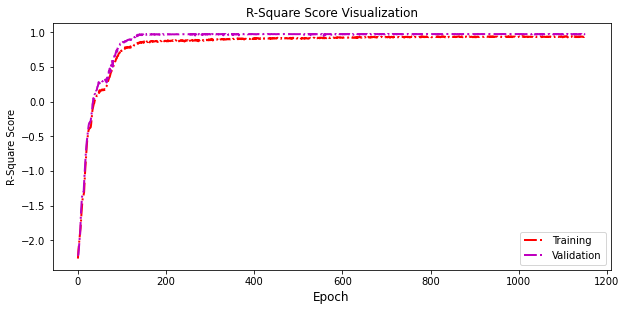

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(train_r2scores, color ='r', linestyle = '-.', linewidth=2, label='Training')
plt.plot(val_r2scores, color ='m', linestyle = '-.', linewidth=2, label='Validation')
plt.title('R-Square Score Visualization')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("R-Square Score")
plt.legend()
plt.show()

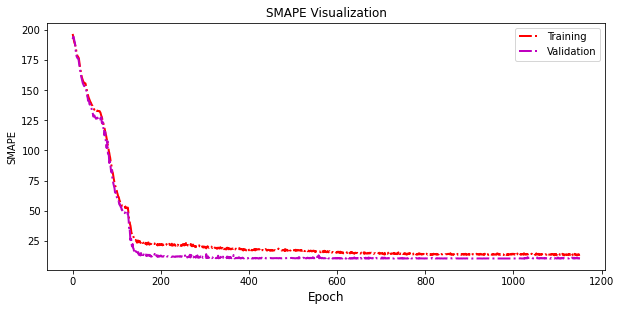

In [13]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(train_smapes, color ='r', linestyle = '-.', linewidth=2, label='Training')
plt.plot(val_smapes, color ='m', linestyle = '-.', linewidth=2, label='Validation')
plt.title('SMAPE Visualization')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("SMAPE")
plt.legend()
plt.show()

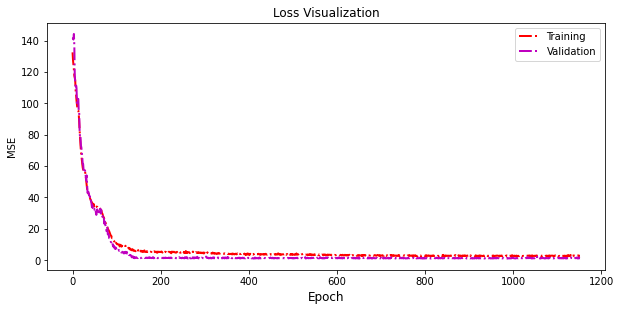

In [14]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(train_losses, color ='r', linestyle = '-.', linewidth=2, label='Training')
plt.plot(val_losses, color ='m', linestyle = '-.', linewidth=2, label='Validation')
plt.title('Loss Visualization')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE")
plt.legend()
plt.show()

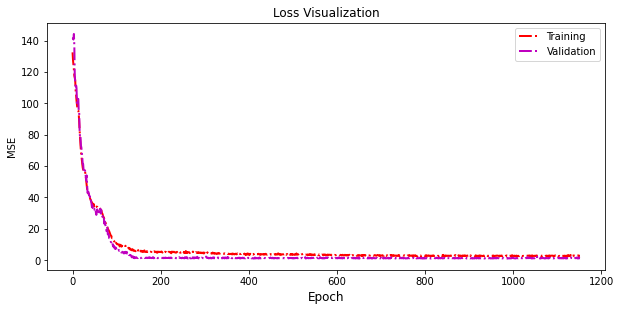

Text(0.5, 1.0, 'Val Loss')

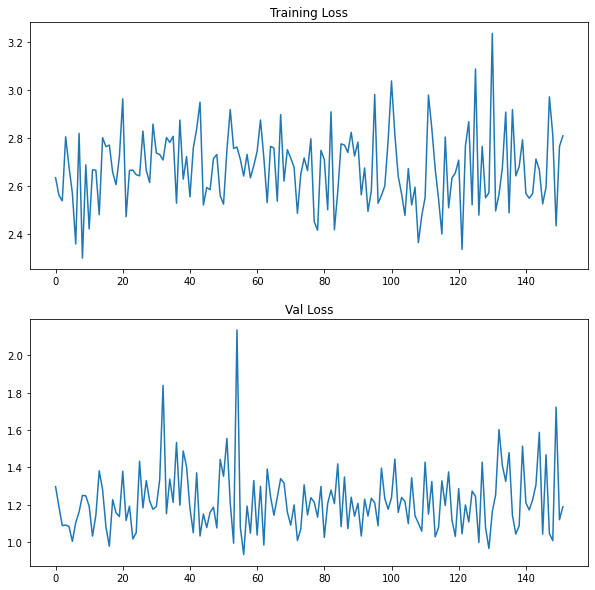

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(train_losses, color ='r', linestyle = '-.', linewidth=2, label='Training')
plt.plot(val_losses, color ='m', linestyle = '-.', linewidth=2, label='Validation')
plt.title('Loss Visualization')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE")#
plt.legend()
plt.show()


plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(train_losses[1000:])
plt.title('Training Loss')

plt.subplot(212)
plt.plot(val_losses[1000:])
plt.title('Val Loss')

# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [16]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device) 
save_pred(preds, 'pred.csv')         

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.89it/s]


# Reference
This notebook uses code written by Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)